# Lead Scoring Case Study 

- Supervised Learning Algorithm - Logistic Regression [ Classification ]
- Programming Language - Python
- Project Lead : Vignesh Kumar (oversee project delivery, build ML model, provide requirements)
- Contributors : Ujjwal Verma (code comments), Vinod Yadav (PPT)


## Initialization - Preprocessing - Visualization

### 1. Package Imports and Data Initialization

In [1]:
%pip install fast_ml    ## Required for constant feature identification package

# these are the libraries which will help to identify constant feature.
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_constant_features

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import all libraries numpy, pandas, matplotlib, seaborn. 
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set_theme(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

# Set custom display properties in pandas
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 900) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
# Import the necessary machine learning packages (sklearn, statsmodel) for performing logistic regression
import statsmodels.api as sm 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, recall_score,precision_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, precision_recall_curve

In [4]:
# Import the dataset from leads.csv
lead_score_df = pd.read_csv('Leads.csv')
lead_score_df.head(1)

Prospect ID  Lead Number Lead Origin Lead Source  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737         API  Olark Chat   

  Do Not Email Do Not Call  Converted  TotalVisits  \
0           No          No          0        0.000   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                 0.000  Page Visited on Website   

  Country Specialization How did you hear about X Education  \
0     NaN         Select                             Select   

  What is your current occupation  \
0                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   

                          Tags      Lead Quality  \
0  Interested in other courses  Low in Relevance   

  Update me on Supply Chain Content Get updates on DM Content Lead Profile  \
0                                No                        No       Select   

     City Asymmetrique Activity Index Asymmetrique Profile Index  \
0  Select                   02.Medium                  02.Medium   

   Asymmetrique Activity Score  Asymmetrique Profile Score  \
0                       15.000                      15.000   

  I agree to pay the amount through cheque  \
0                                       No   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified

In [5]:
# looking at the information of the dataset
lead_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

###  ----------------------------------------------------------------------

### 2. Data Preprocesing - Part 1

#### Custom Functions for Preprocessing and EDA

In [6]:
# To distinguish numerical columns either as categorical/discrete or non categorical and return as dict
def classify_feature_dtype(df, cols):
    d_categories = {'int_cat': [], "float_ts":[] }
    for col in cols:
        if (len(df[col].unique()) < 20) and (df[col].dtype != np.float64):
            d_categories['int_cat'].append(col)
        else:
            
            if not isinstance(df[col][df[col].notna()].unique()[0], str):
                d_categories['float_ts'].append(col)
            else:
                d_categories['int_cat'].append(col)
    return d_categories

# Print all statistical information for a given set of columns
def show_stats(df, cols):
    for col in list(cols):
        print("Total Nulls: {0},\nMode: {1}".format(df[col].isna().sum(), df[col].mode()[0]))
        if len(df[col].unique()) < 50:
            print("\nUnique: {0}\n".format(df[col].unique()))
        if (df[col].dtype == int) or (df[col].dtype == float):
            print("Median   : {0}, \nVariance: {1}, \n\nDescribe: {2} \n".format(df[col].median(), df[col].var(), df[col].describe()))
        print("ValueCounts: {0} \n\n\n".format((df[col].value_counts(normalize=True) * 100).head(5)))
        print("------------------------------------------------------------------")

# Return the percentage of null values in each columns in a dataframe
def check_cols_null_pct(df):
    df_non_na = df.count() / len(df)  # Ratio of non null values
    df_na_pct = (1 - df_non_na) * 100 # Find the Percentage of null values
    return df_na_pct.sort_values(ascending=False) # Sort the resulting values in descending order

# Generates charts based on the data type of the cols, as part of the univariate analysis 
# it takes dataframe, columns, train data 0,1, and feature type as args.
def univariate_plots(df, cols, target=None, ftype=None, l_dict = None):
    for col in cols:
        #generate plots and graphs for category type. (generates piechart, countplot, boxplot / if training data is provided it generates bar chart instead)
        if ftype == "categorical":
            fig, axs = plt.subplots(1, 3, figsize=(20, 6))
 
            col_idx = 0
            axs[col_idx].pie(x=df[col].value_counts().head(12), labels=df[col].value_counts().head(12).index.str[:10], autopct="%1.1f%%", 
                    radius=1, textprops={"fontsize": 10, "color": "Black"}, startangle=90, rotatelabels=False, )
            axs[col_idx].set_title("PieChart of {0}".format(col), y=1); plt.xticks(rotation=45); plt.ylabel("Percentage")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1
            sns.countplot(data=df, y=col, order=df[col].value_counts().head(15).index, palette="viridis",  ax=axs[col_idx])
            if (l_dict is not None) and (l_dict.get(col) is not None):
                axs[col_idx].legend([ f'{k} - {v}' for k,v in l_dict[col].items()])
            axs[col_idx].set_title("Countplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col); plt.ylabel("Count")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            col_idx += 1
            ax = sns.barplot(data=df, x=df[col].str[:10], y=target, order=df[col].value_counts().index.str[:10], palette="viridis",  ax=axs[col_idx], errwidth=0)
            for i in ax.containers:
                ax.bar_label(i,)
            axs[col_idx].set_title('Barplot against target'); plt.xticks(rotation=90); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show();
            plt.clf()

        #generate plots and graphs for numerical types. (generates boxplot, histplot, kdeplot, scatterplot)
        elif ftype == "non_categorical":        
            fig, axs = plt.subplots(1, 4, figsize=(20, 6))
            
            col_idx = 0
            
            sns.boxplot(data=df, y=col, palette="viridis", flierprops=dict(marker="o", markersize=6, markerfacecolor="red", markeredgecolor="black"),
                        medianprops=dict(linestyle="-", linewidth=3, color="#FF9900"), whiskerprops=dict(linestyle="-", linewidth=2, color="black"),
                        capprops=dict(linestyle="-", linewidth=2, color="black"), ax=axs[col_idx])
            axs[col_idx].set_title("Boxplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            axs[col_idx].hist(data=df, x=col, label=col)
            axs[col_idx].set_title("Histogram of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.kdeplot(df[col], shade=True, ax=axs[col_idx])
            axs[col_idx].set_title("KDE plot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.scatterplot(df[col], ax=axs[col_idx])
            axs[col_idx].set_title("Scatterplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()
            plt.clf()

# Perform Outlier analysis on the given dataframe.
# Find Lower threshold, Upper threshold and IQR values. 
# Return the Result as a dataframe. 
# find_outlier = True argument: restricts the output df to outlier columns. whereas find_outlier = False: returns results for all columns
def get_extremeval_threshld(df, find_outlier=False):
    outlier_df = pd.DataFrame(columns=[i for i in df.columns if find_outlier == True], data=None)
    
    for col in df.columns:
        thirdq, firstq = df[col].quantile(0.75), df[col].quantile(0.25)
        iqr = 1.5 * (thirdq - firstq)
        extvalhigh, extvallow = iqr + thirdq, firstq - iqr
        
        if find_outlier == True:
            dfout = df.loc[(df[col] > extvalhigh) | (df[col] < extvallow)]
            dfout = dfout.assign(name=col, thresh_low=extvallow, thresh_high=extvalhigh)
        else:
            dfout = pd.DataFrame([[col, extvallow, extvalhigh]], columns=['name', 'thresh_low', 'thresh_high'])
            
        outlier_df = pd.concat([outlier_df, dfout])
    # outlier_df = outlier_df.reset_index(drop=True)
    outlier_df = outlier_df.set_index('name',drop=True)
    return outlier_df

#### Data Cleaning, Column Renaming, Missing Value Imputation, Feature Selection

In [7]:
#duplicates row validation by id cols
print(f"{lead_score_df.index.is_unique}, {lead_score_df.columns.is_unique}, {lead_score_df['Prospect ID'].is_unique}, {lead_score_df['Lead Number'].is_unique}")

True, True, True, True


In [8]:
# drop unnecessary columns
lead_score_df = lead_score_df.drop(columns=['Prospect ID','Lead Number', 'I agree to pay the amount through cheque', 'Last Notable Activity'])

In [9]:
# rename columns that are too long
lead_score_df = lead_score_df.rename(columns={'Total Time Spent on Website':'ttime_on_site', 'Page Views Per Visit':'pg_view_pv', 'How did you hear about X Education':'info_abt_X_Edu', 'What is your current occupation':'curr_occupation',
    'What matters most to you in choosing a course':'reason_behind_course', 'Receive More Updates About Our Courses':'more_course_updates', 'Update me on Supply Chain Content':'supply_chain_info', 'Get updates on DM Content':'get_dm',
    'Asymmetrique Activity Index':'asym_activ_idx', 'Asymmetrique Profile Index':'asym_prof_idx', 'Asymmetrique Activity Score':'asym_activ_score', 'Asymmetrique Profile Score':'asym_prof_score',
    'A free copy of Mastering The Interview':'avail_free_copy'})

In [10]:
# replace unnecessary space in columns with underscore and covert it to lower case
lead_score_df.columns = lead_score_df.columns.str.replace(pat=' ',repl='_', regex=True)
lead_score_df.columns = lead_score_df.columns.str.lower()

In [11]:
# Check the shape and size of the data frame
lead_score_df.head(1)
lead_score_df.dtypes

lead_origin lead_source do_not_email do_not_call  converted  totalvisits  \
0         API  Olark Chat           No          No          0        0.000   

   ttime_on_site  pg_view_pv            last_activity country specialization  \
0              0       0.000  Page Visited on Website     NaN         Select   

  info_abt_x_edu curr_occupation     reason_behind_course search magazine  \
0         Select      Unemployed  Better Career Prospects     No       No   

  newspaper_article x_education_forums newspaper digital_advertisement  \
0                No                 No        No                    No   

  through_recommendations more_course_updates                         tags  \
0                      No                  No  Interested in other courses   

       lead_quality supply_chain_info get_dm lead_profile    city  \
0  Low in Relevance                No     No       Select  Select   

  asym_activ_idx asym_prof_idx  asym_activ_score  asym_prof_score  \
0      02.Medium     02.Medium            15.000           15.000   

  avail_free_copy  
0              No

lead_origin                 object
lead_source                 object
do_not_email                object
do_not_call                 object
converted                    int64
totalvisits                float64
ttime_on_site                int64
pg_view_pv                 float64
last_activity               object
country                     object
specialization              object
info_abt_x_edu              object
curr_occupation             object
reason_behind_course        object
search                      object
magazine                    object
newspaper_article           object
x_education_forums          object
newspaper                   object
digital_advertisement       object
through_recommendations     object
more_course_updates         object
tags                        object
lead_quality                object
supply_chain_info           object
get_dm                      object
lead_profile                object
city                        object
asym_activ_idx      

In [12]:
print(f'{lead_score_df.shape}, {lead_score_df.size}')

(9240, 33), 304920


##### Constant Feature Identification

In [13]:
# check constant features that has only one values
# In the given data set there are a lot of features that have only single value as a category
# These are called as constant features and these features are of little relevance for the machine learning model hence we dropped those features

constant_features = get_constant_features(lead_score_df)
constant_features.head(10)
"','".join(constant_features['Var'].to_list())

Desc                      Var Value    Perc
0        Constant                 magazine    No 100.000
1        Constant      more_course_updates    No 100.000
2        Constant        supply_chain_info    No 100.000
3        Constant                   get_dm    No 100.000
4  Quasi Constant       x_education_forums    No  99.989
5  Quasi Constant                newspaper    No  99.989
6  Quasi Constant              do_not_call    No  99.978
7  Quasi Constant        newspaper_article    No  99.978
8  Quasi Constant    digital_advertisement    No  99.957
9  Quasi Constant  through_recommendations    No  99.924

"magazine','more_course_updates','supply_chain_info','get_dm','x_education_forums','newspaper','do_not_call','newspaper_article','digital_advertisement','through_recommendations','search"

In [14]:
# drop all the constant_features
lead_score_df = lead_score_df.drop(['magazine', 'more_course_updates', 'supply_chain_info', 'get_dm', 'x_education_forums', 
                                    'newspaper', 'do_not_call', 'newspaper_article', 'digital_advertisement', 'through_recommendations', 'search',], axis=1)

In [15]:
# seeing the values of reason_behind_course column
# since this has also almost same value means constant value then we will drop this column too
lead_score_df['reason_behind_course'].value_counts(normalize=True)*100
lead_score_df = lead_score_df.drop(['reason_behind_course'], axis=1)

# dropping country column too since this doesn't have much input in the model
# and then checking if there any null values present in any column or not.
lead_score_df[['country']].value_counts(normalize=True)*100
lead_score_df = lead_score_df.drop(['country'], axis=1)

reason_behind_course
Better Career Prospects     99.954
Flexibility & Convenience    0.031
Other                        0.015
Name: proportion, dtype: float64

country             
India                  95.766
United States           1.018
United Arab Emirates    0.782
Singapore               0.354
Saudi Arabia            0.310
United Kingdom          0.221
Australia               0.192
Qatar                   0.148
Bahrain                 0.103
Hong Kong               0.103
France                  0.089
Oman                    0.089
unknown                 0.074
Kuwait                  0.059
Nigeria                 0.059
South Africa            0.059
Germany                 0.059
Canada                  0.059
Sweden                  0.044
Uganda                  0.030
Philippines             0.030
Asia/Pacific Region     0.030
Italy                   0.030
Ghana                   0.030
China                   0.030
Belgium                 0.030
Bangladesh              0.030
Netherlands             0.030
Malaysia                0.015
Liberia                 0.015
Russia                  0.015
Kenya                   0.015
Indonesia          

##### Missing Value Imputation

In [16]:
# check null val percentage
# After checking the null value percentage for all the features
# We could see that there are many features that have more than 45% of non values

null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]

lead_quality       51.591
asym_activ_idx     45.649
asym_prof_score    45.649
asym_activ_score   45.649
asym_prof_idx      45.649
tags               36.288
lead_profile       29.318
curr_occupation    29.113
info_abt_x_edu     23.885
specialization     15.563
city               15.368
totalvisits         1.483
pg_view_pv          1.483
last_activity       1.115
lead_source         0.390
dtype: float64

In [17]:
# check null val percentage
# Since we have replaced select as null value for certain columns we are seeing increase in the null value percentage for those features
# Therefore we dropped all the features that have more than 40 of null values

null_pct = check_cols_null_pct(lead_score_df)
lead_score_df = lead_score_df.drop(null_pct[null_pct > 40].index, axis=1)

null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]

tags              36.288
lead_profile      29.318
curr_occupation   29.113
info_abt_x_edu    23.885
specialization    15.563
city              15.368
totalvisits        1.483
pg_view_pv         1.483
last_activity      1.115
lead_source        0.390
dtype: float64

In [18]:
show_stats(lead_score_df,['tags','specialization'])

Total Nulls: 3353,
Mode: Will revert after reading the email

Unique: ['Interested in other courses' 'Ringing'
 'Will revert after reading the email' nan 'Lost to EINS'
 'In confusion whether part time or DLP' 'Busy' 'switched off'
 'in touch with EINS' 'Already a student' 'Diploma holder (Not Eligible)'
 'Graduation in progress' 'Closed by Horizzon' 'number not provided'
 'opp hangup' 'Not doing further education' 'invalid number'
 'wrong number given' 'Interested  in full time MBA' 'Still Thinking'
 'Lost to Others' 'Shall take in the next coming month' 'Lateral student'
 'Interested in Next batch' 'Recognition issue (DEC approval)'
 'Want to take admission but has financial problems'
 'University not recognized']

ValueCounts: tags
Will revert after reading the email   35.196
Ringing                               20.435
Interested in other courses            8.714
Already a student                      7.899
Closed by Horizzon                     6.081
Name: proportion, dtype: float

In [19]:
# replacing select and imputing null value of the 'tags','specialization','info_abt_x_edu', 'lead_profile', 'city', 'curr_occupation' columns as unknown
lead_score_df[['tags','specialization','info_abt_x_edu', 'lead_profile', 'city', 'curr_occupation']] = lead_score_df[['tags','specialization','info_abt_x_edu', 'lead_profile', 'city', 'curr_occupation']].replace(to_replace=['select', 'Select', np.nan], value='unknown') 

# validate select str is replaced
[i for i in lead_score_df.columns if 'select' in (lead_score_df[i].astype(str).str.lower()).str.findall('select').value_counts().index.map(''.join).to_list()]

[]

In [20]:
null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]

totalvisits     1.483
pg_view_pv      1.483
last_activity   1.115
lead_source     0.390
dtype: float64

In [21]:
# convert dtypes
# Convert the data type of certain features from object to category type
obj_cols = lead_score_df.select_dtypes(include='object').columns
lead_score_df[obj_cols] = lead_score_df[obj_cols].astype(dtype='category')

In [22]:
# impute missing categorical values using mode, if a particular value in that column has higher frequency say > 60%
for i in lead_score_df.select_dtypes(include='category'):
    temp = lead_score_df[i].value_counts(normalize=True, ascending=False) * 100
    if temp.iloc[0] > 60:
        if lead_score_df[i].isna().sum()>0:
            print(i)
            lead_score_df[i] = lead_score_df[i].fillna(temp.index[0])

In [23]:
# Now there are only four numerical columns with very few null values

null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]

totalvisits     1.483
pg_view_pv      1.483
last_activity   1.115
lead_source     0.390
dtype: float64

###  ----------------------------------------------------------------------

### 3. Data Visualization - EDA

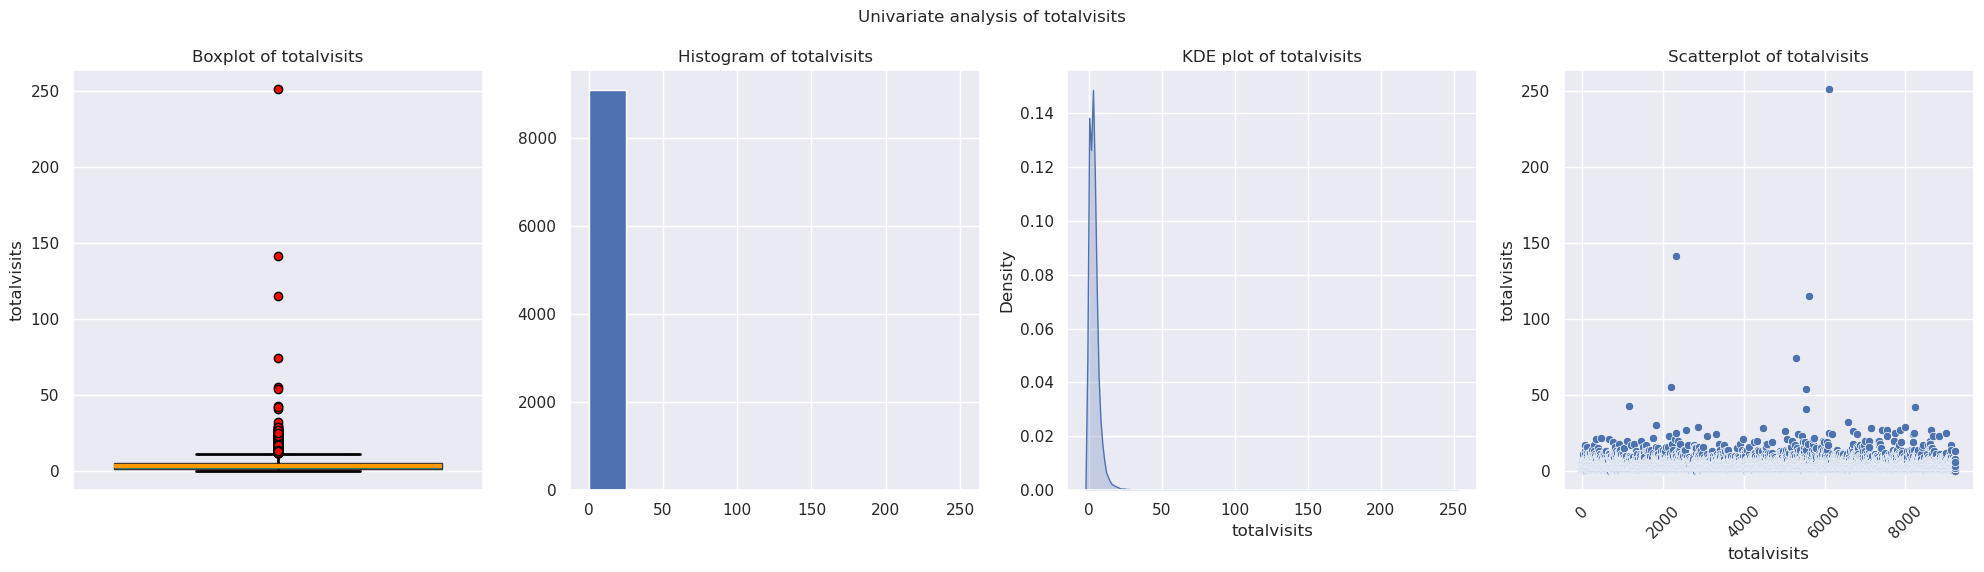

<Figure size 640x480 with 0 Axes>

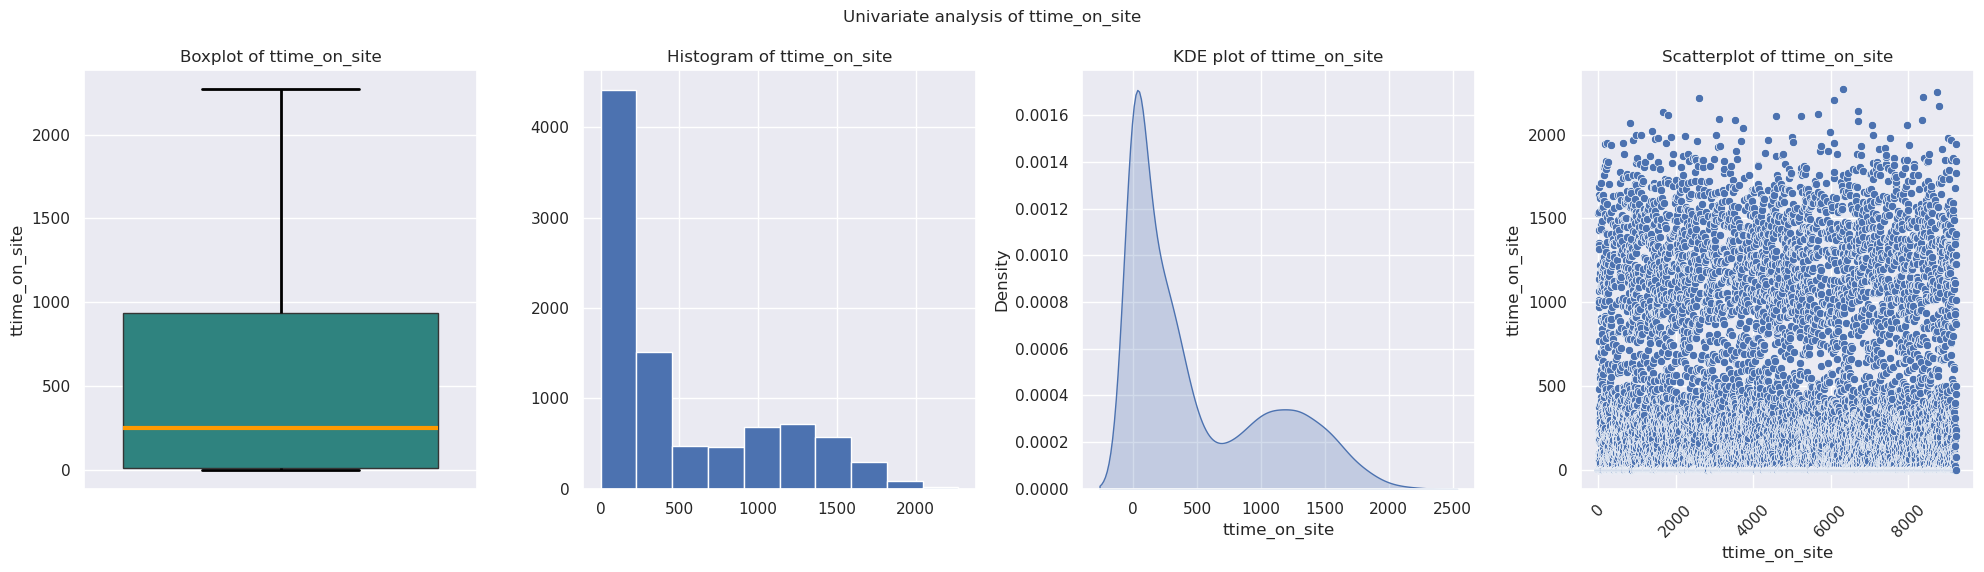

<Figure size 640x480 with 0 Axes>

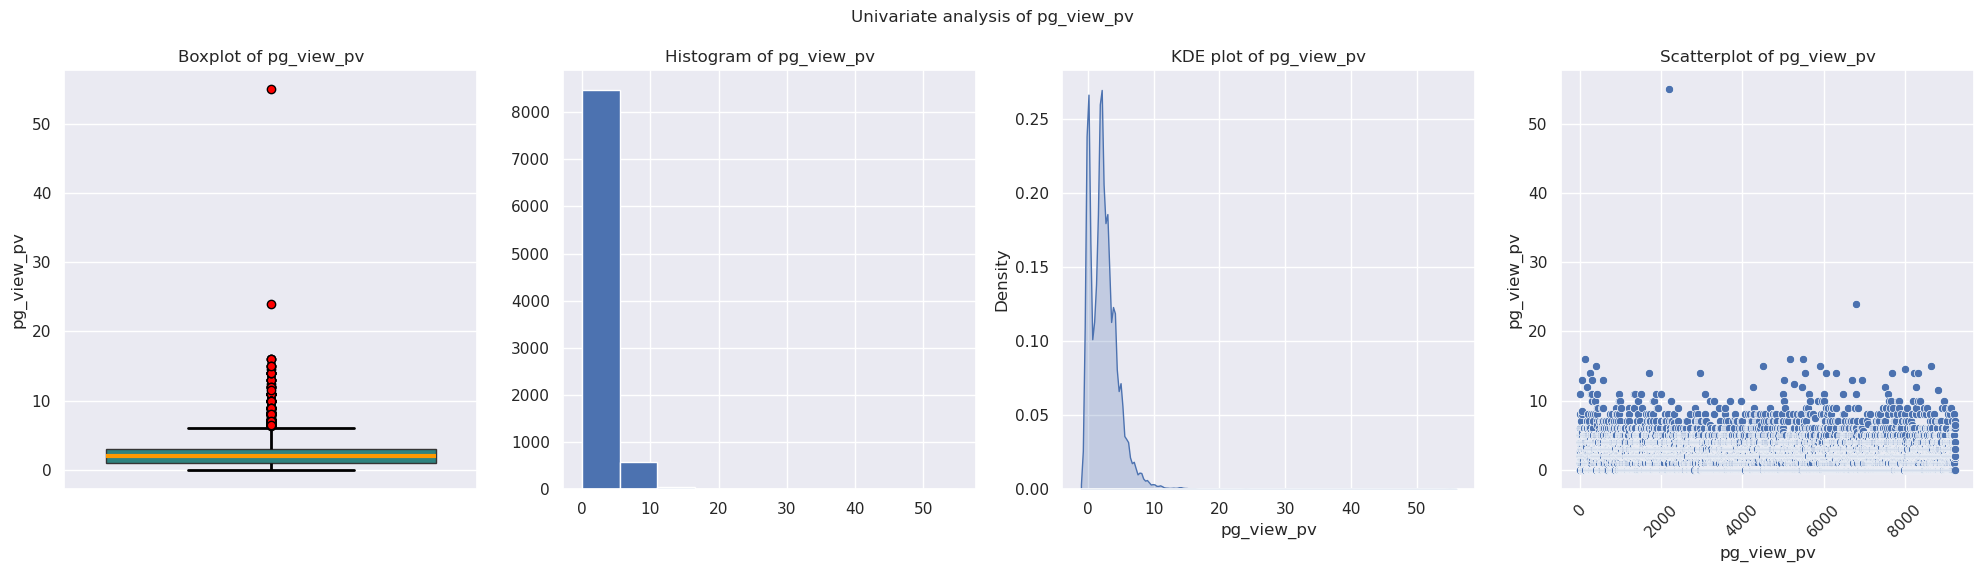

<Figure size 640x480 with 0 Axes>

In [24]:
# univariate plots#
# Now we perform Univariate analysis on both categorical and numerical variables
dtype_dict = classify_feature_dtype(lead_score_df, lead_score_df.columns )
univariate_plots(lead_score_df, dtype_dict['float_ts'], ftype='non_categorical', target='converted')

#####  Observations

- There are outlier in total_visits, page view per visit features.

- The Target feature "converted" has more 1's than 0's
- The box plot for total visits shows that there are outliers and the majority of the total visits fall between 0 and 30
- The box plot for page view per visit shows that there are outliers majority of them fall between 0 and 20

#####

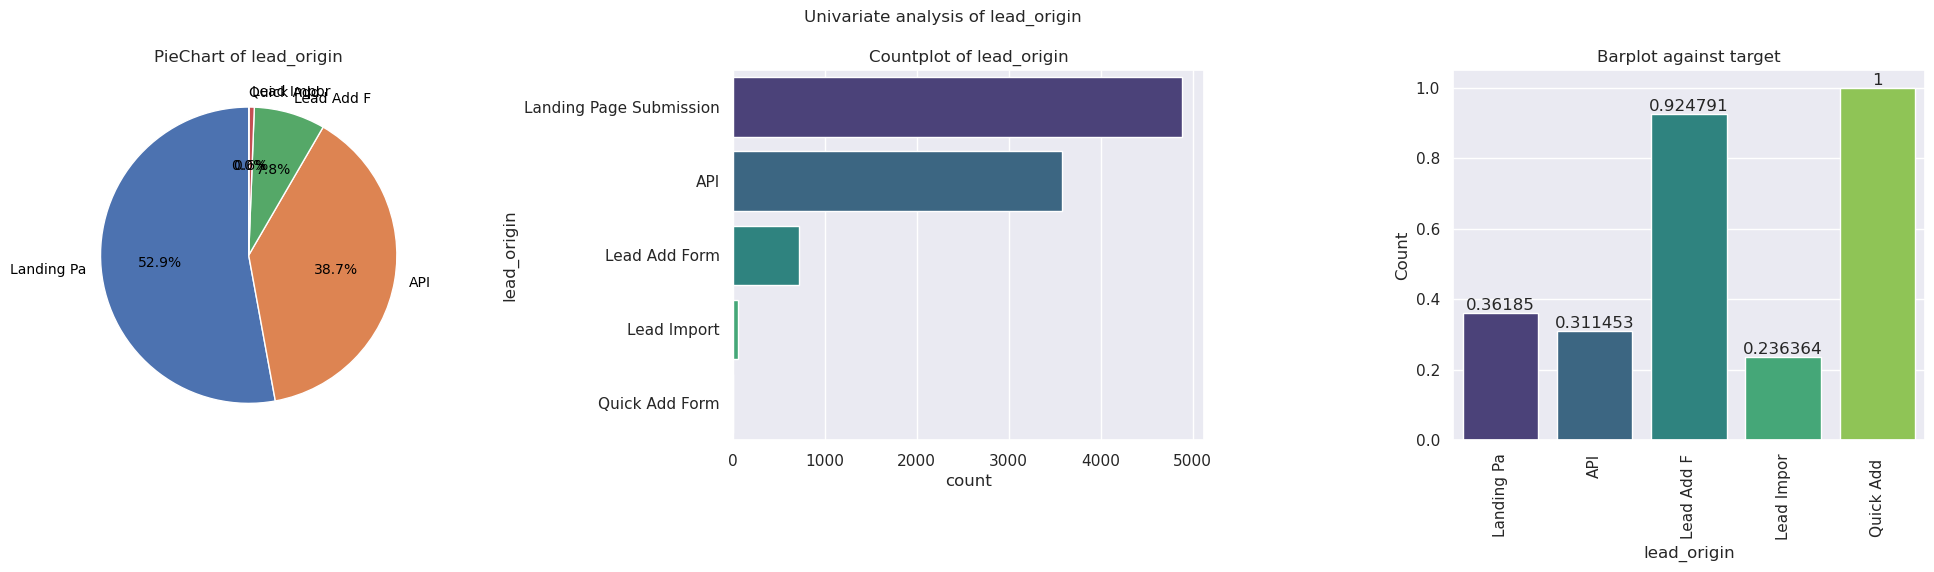

<Figure size 640x480 with 0 Axes>

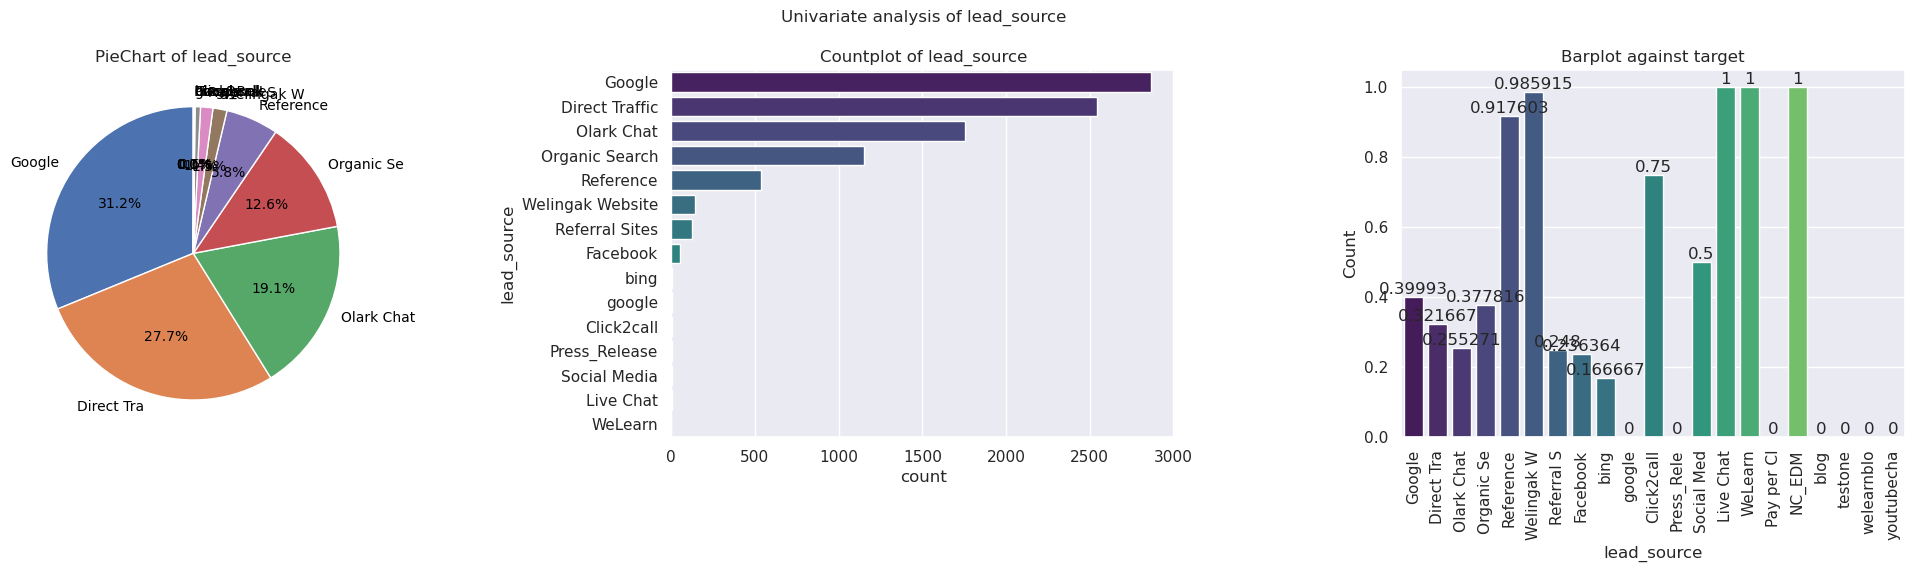

<Figure size 640x480 with 0 Axes>

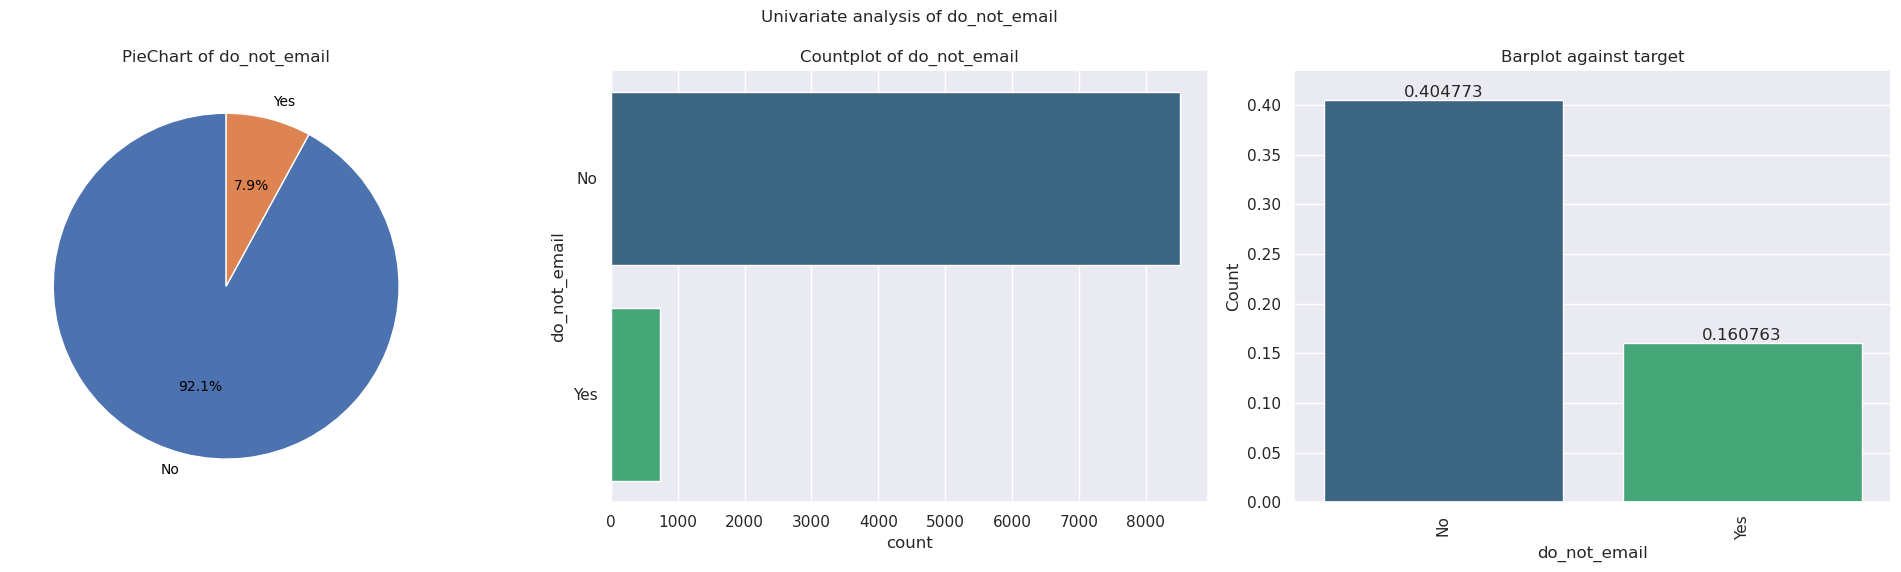

<Figure size 640x480 with 0 Axes>

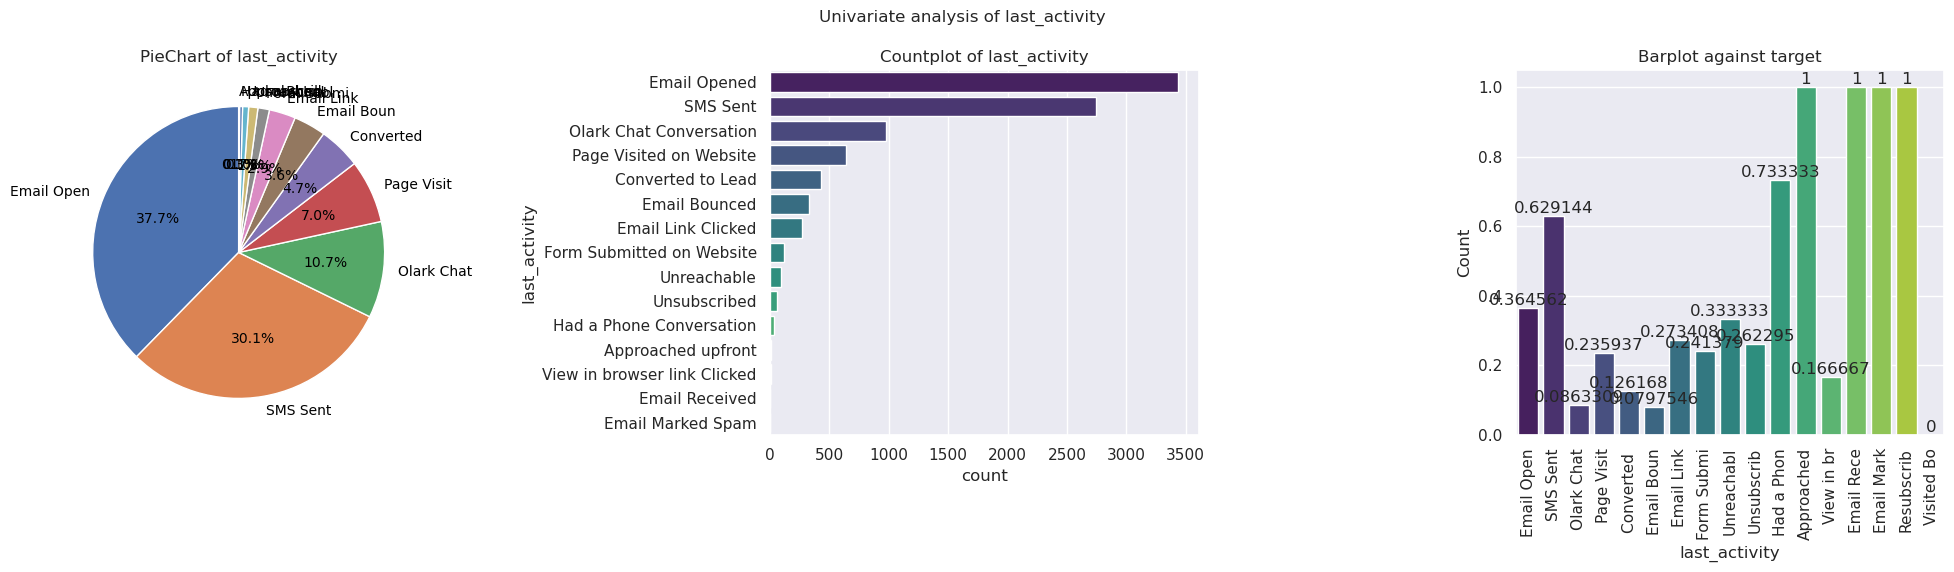

<Figure size 640x480 with 0 Axes>

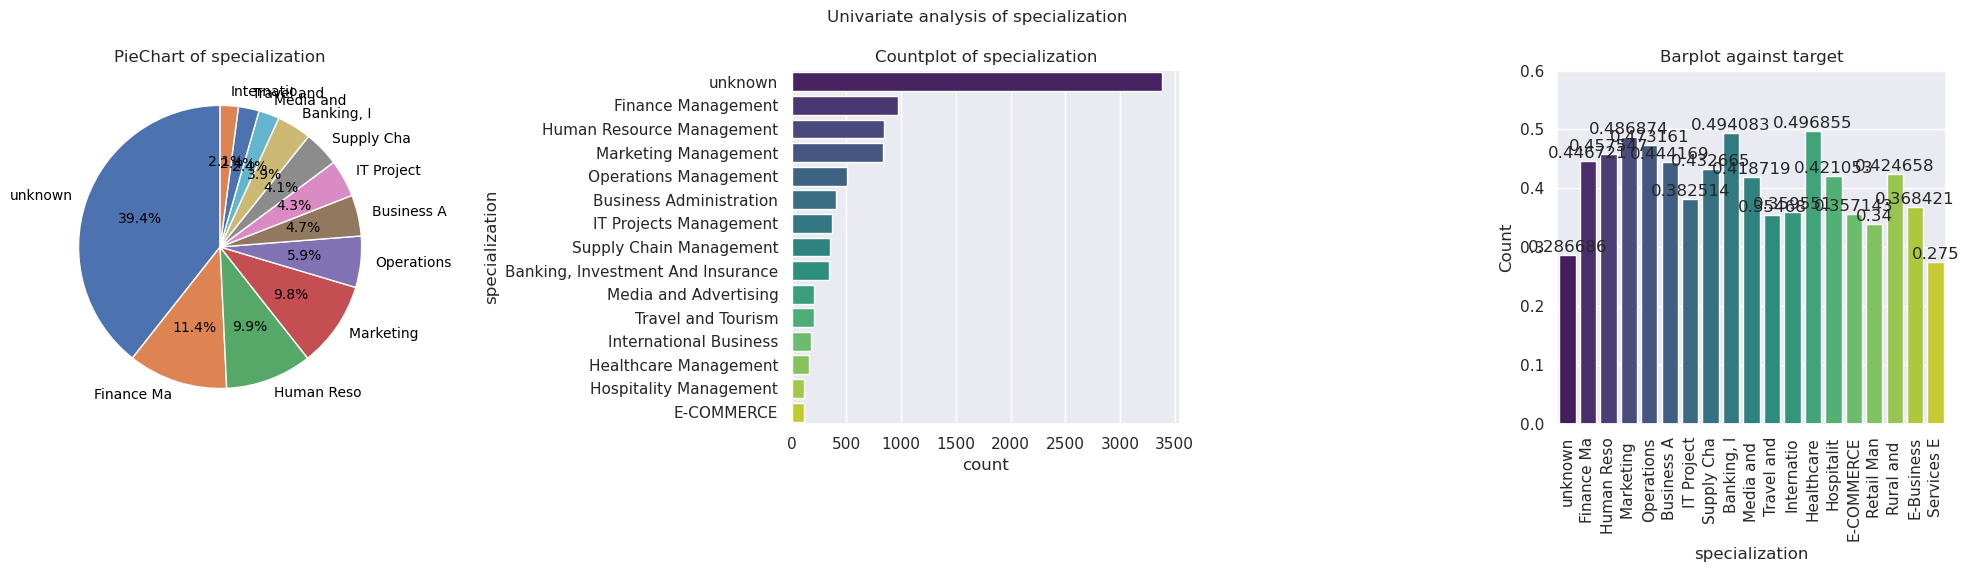

<Figure size 640x480 with 0 Axes>

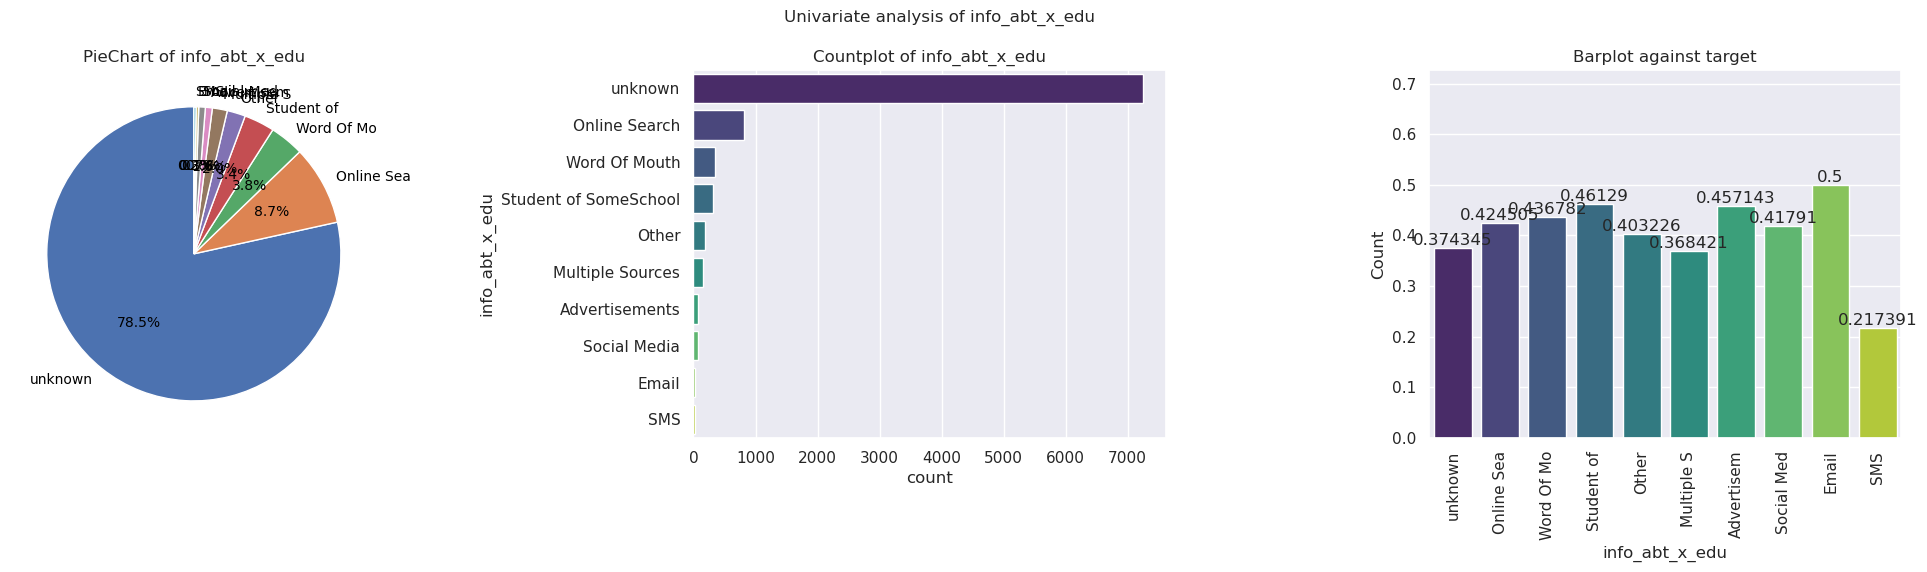

<Figure size 640x480 with 0 Axes>

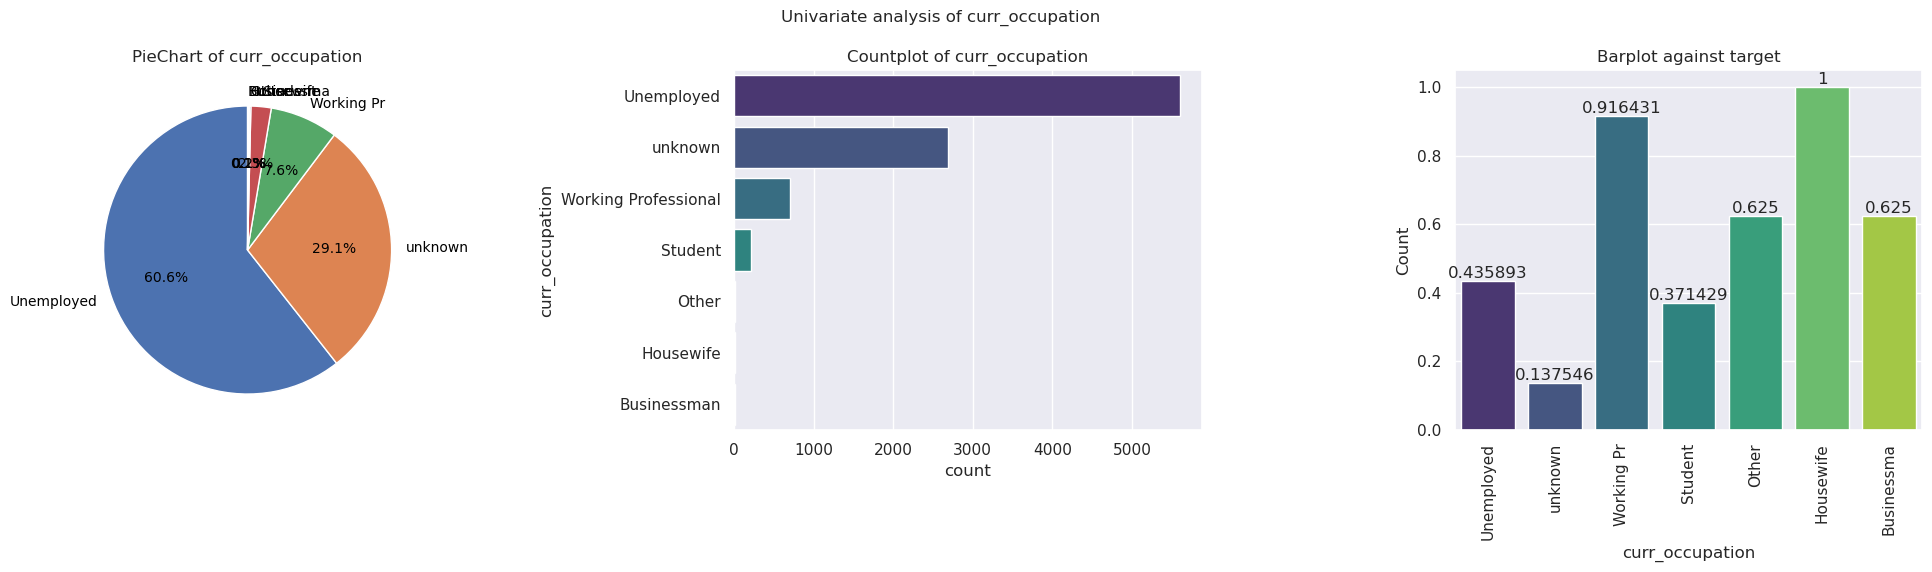

<Figure size 640x480 with 0 Axes>

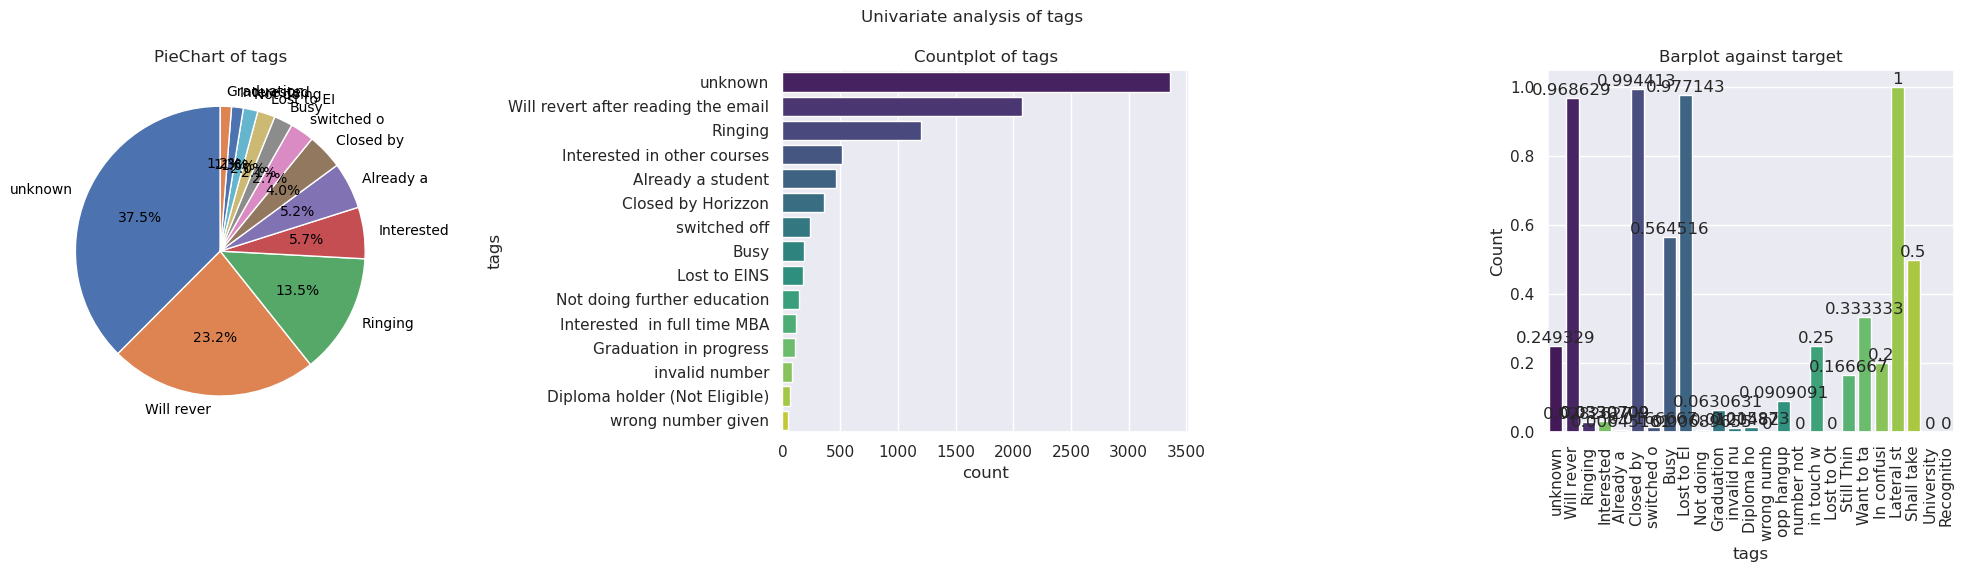

<Figure size 640x480 with 0 Axes>

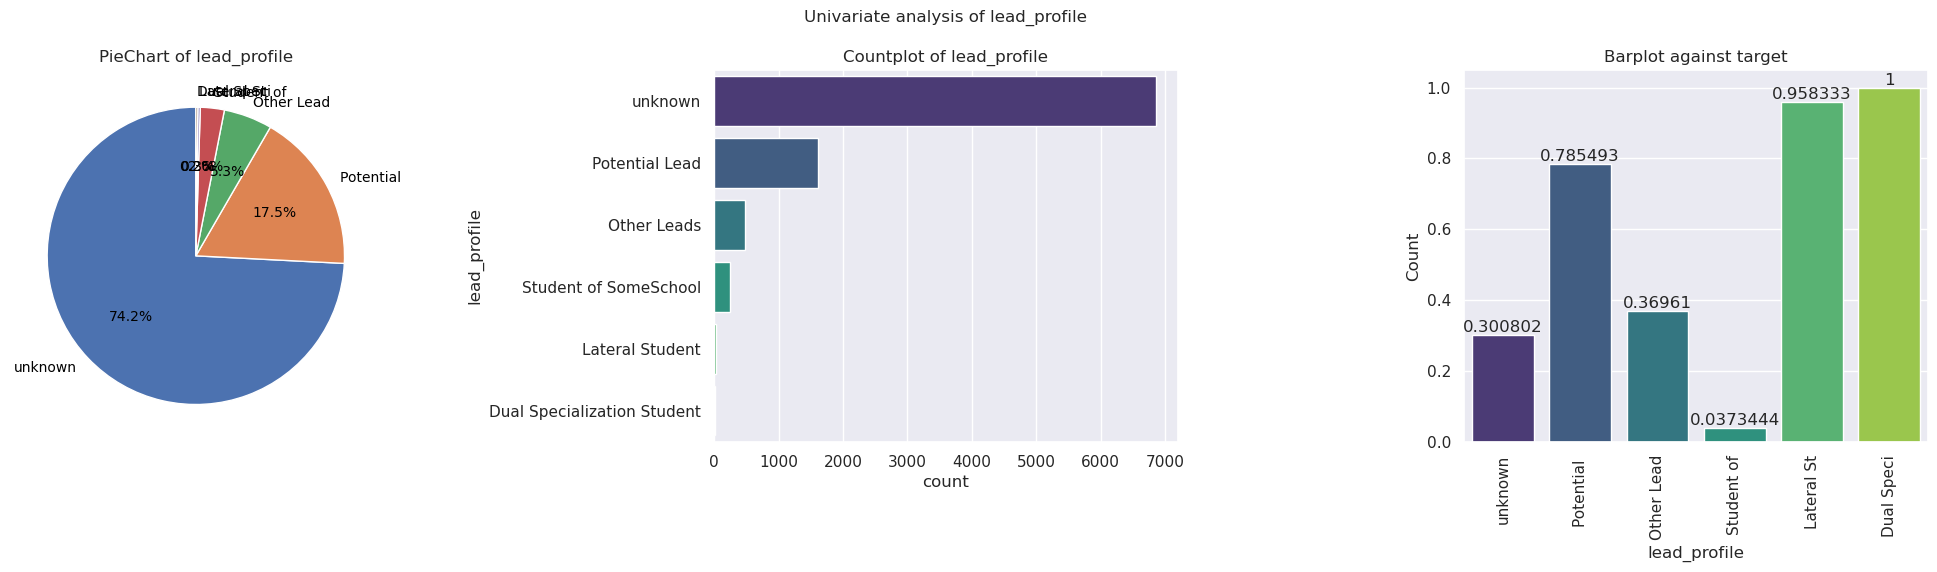

<Figure size 640x480 with 0 Axes>

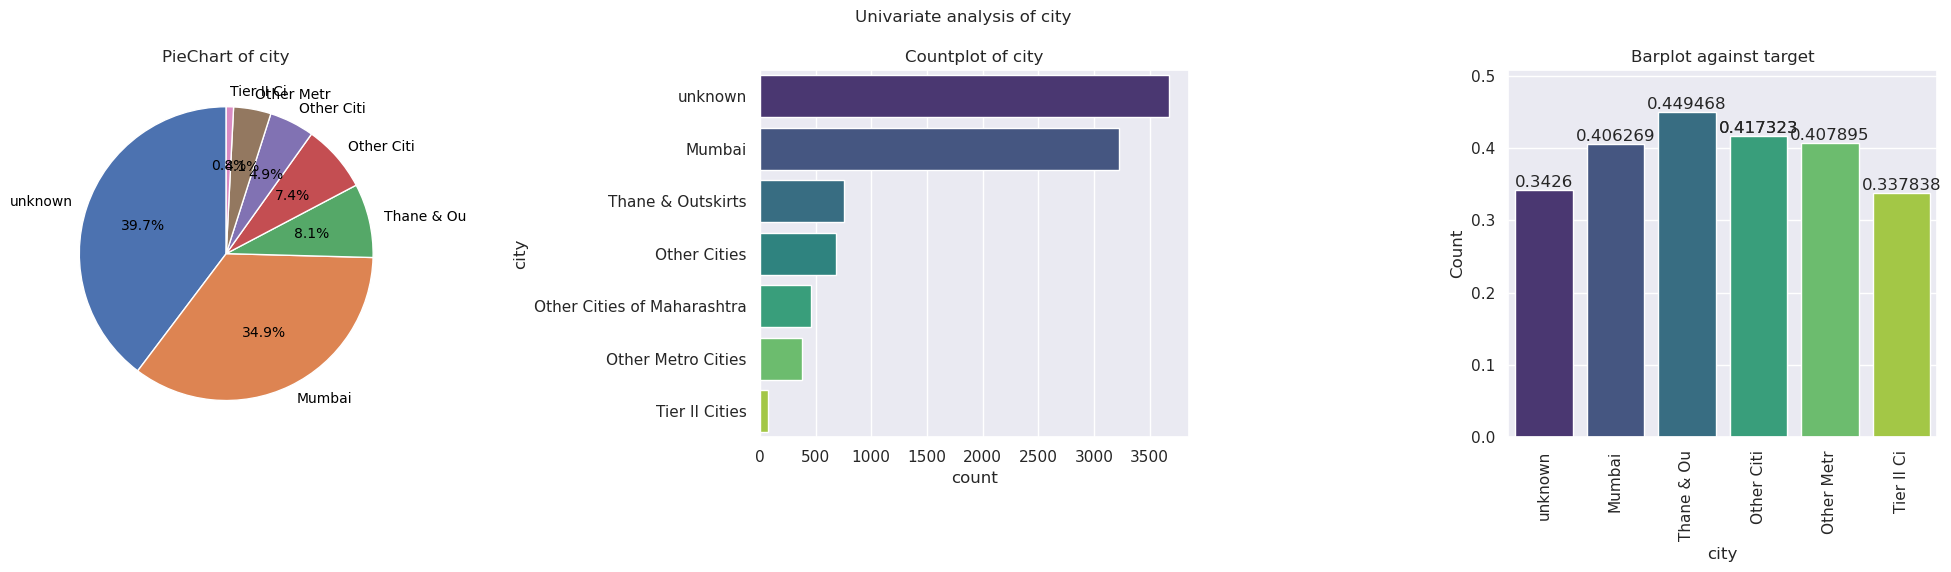

<Figure size 640x480 with 0 Axes>

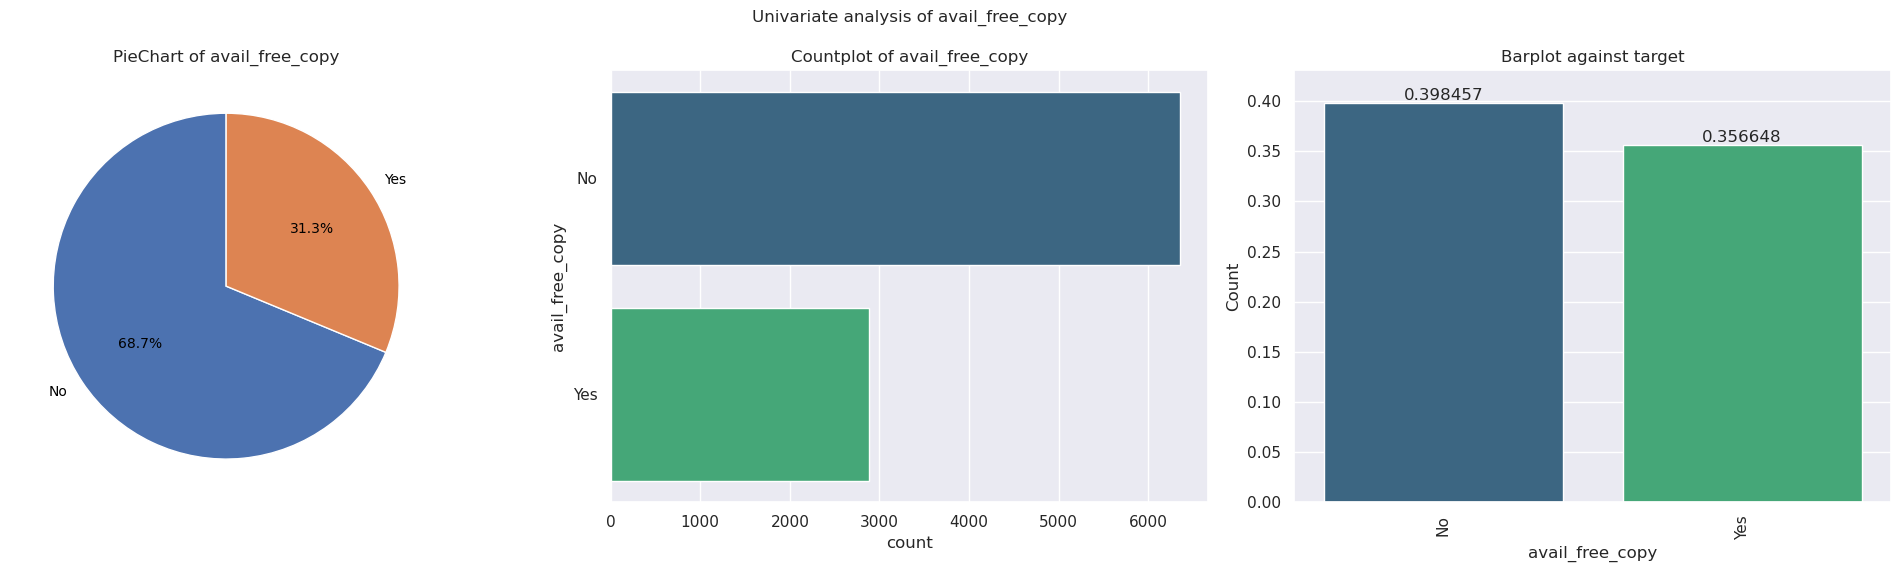

<Figure size 640x480 with 0 Axes>

In [25]:
# univariate plots
cols = dtype_dict['int_cat'].copy()
cols.remove('converted')
univariate_plots(lead_score_df, cols, ftype='categorical', target='converted')

####  Observations

##### The categorical analysis
 - More than 50 per cent of the users have originated via landing page following which the apis have 38% of leads
 - When it comes to lead origin conversion rates, lead_add_form has higher conversion rates, holistically all have similar probability rate
 
 - When it comes to lead source 30% are from google, 27% are from direct traffic, 19% are from olark chat
 
 - For the do not email feature, 90% of them chose no, while 7% of them chose yes therefore majority of them are interested in the edtech platform.
 - Also the people who have said no have a higher percent of conversion rate.
  
 - The last activity feature majority of the users, 38% of users have email opened followed by sms sent, therefore we can say that Majority of the users are active on email conversations
  
 - Majority of the users are from india, We can we can assume that edtech has a higher popularity/interest in india
 
 - Among the employed users most of the interested users have finance management as a specialization, followed by human resource management and marketing management, almost all specialization has a similar conversion rate.
 
 - Majority of the users are unemployed, followed by working professionals
 - Working professionals have a higher conversion rates, while the user count is low in comparison to unemployed.
  
 - Majority of the users have chosen better career prospects as a reason for opting for the course.
 
 - The majority of the leads have been tagged under "will revert after reading the email".
 
 - Maximum number of leads have been from the city of mumbai followed by thane, almost all categories have similar probabilities of conversion.
  
 - 58% of the leads have opted not to avail free copy of the interview while 31 are opted for interview copy
 

####

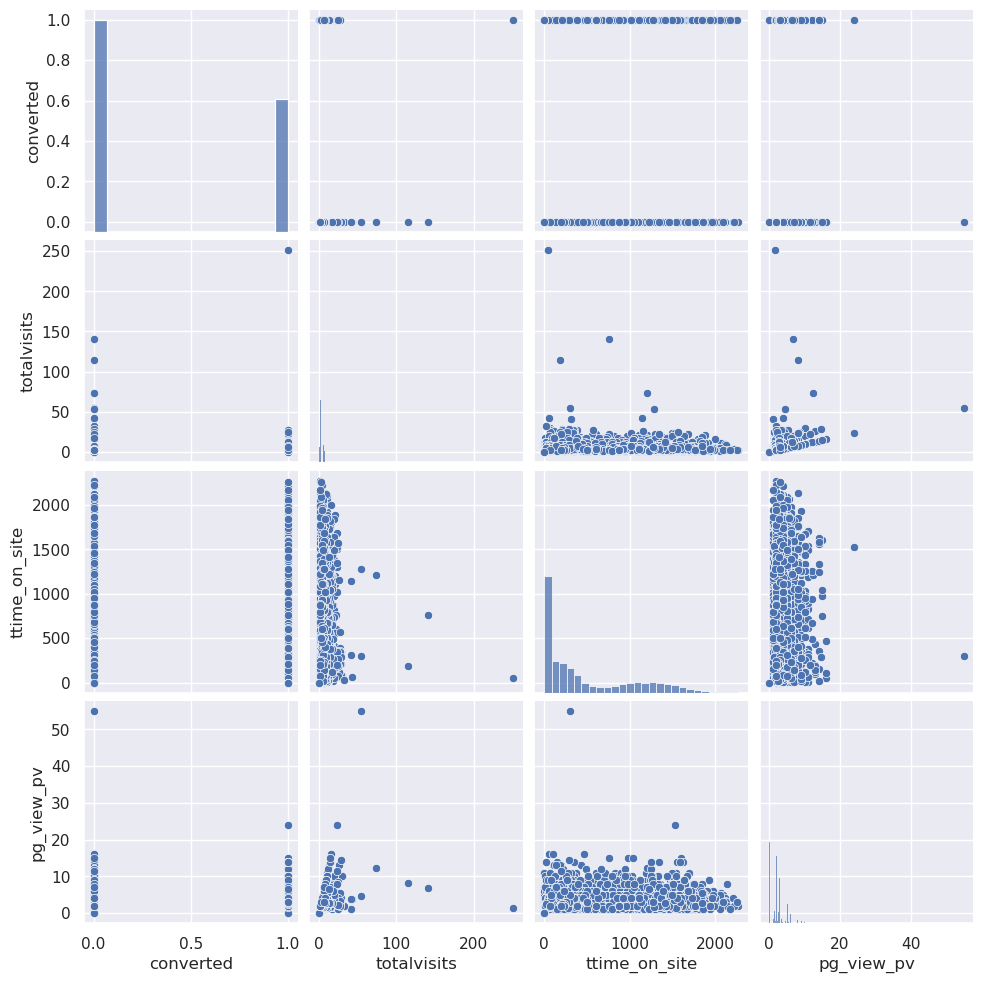

In [26]:
# Bivariate plots
# The pair plot view shows that there is a slight correlation between total visits and page view per visit
sns.pairplot(lead_score_df)
plt.show();

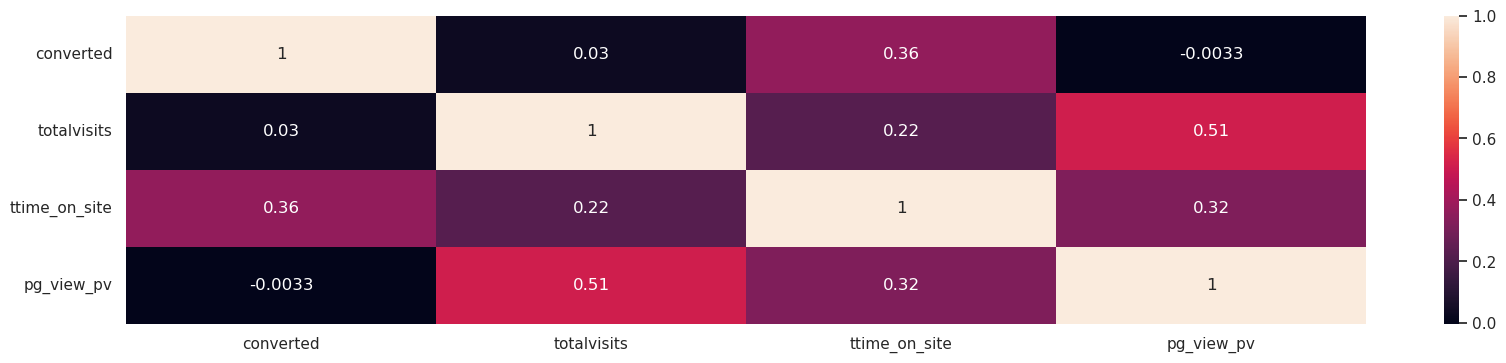

In [27]:
# multivariate plots
# The heat map shows that majority of the features have no correlation or has lesser than 0 5 correlation

plt.figure(figsize = (20, 4)) # Size of the figure
sns.heatmap(lead_score_df.select_dtypes(exclude='category').corr(), annot = True)
plt.show();

Observations:
- There are not much correlations between variables

#### 3.1 Other Bivariate - Multivariate plots (computationally intensive)

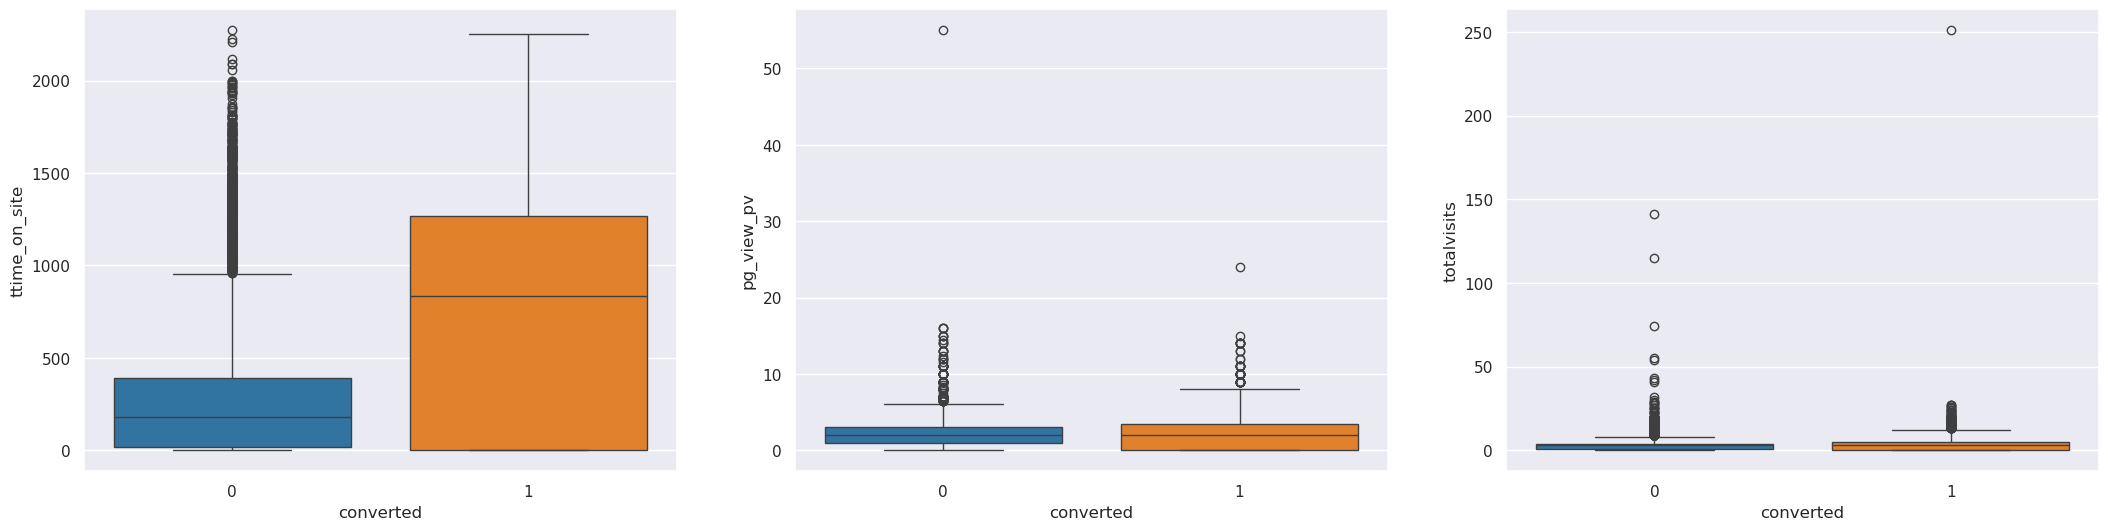

In [28]:
# # Boxplots - numerical features against target

axs = 131
plt.figure(figsize=(26, 6))
for i in list(set(dtype_dict['float_ts']) - set(['date','converted','lead_number'])):
    plt.subplot(axs)
    sns.boxplot(y=i, x='converted', data=lead_score_df, palette='tab10')
    axs += 1
plt.show();

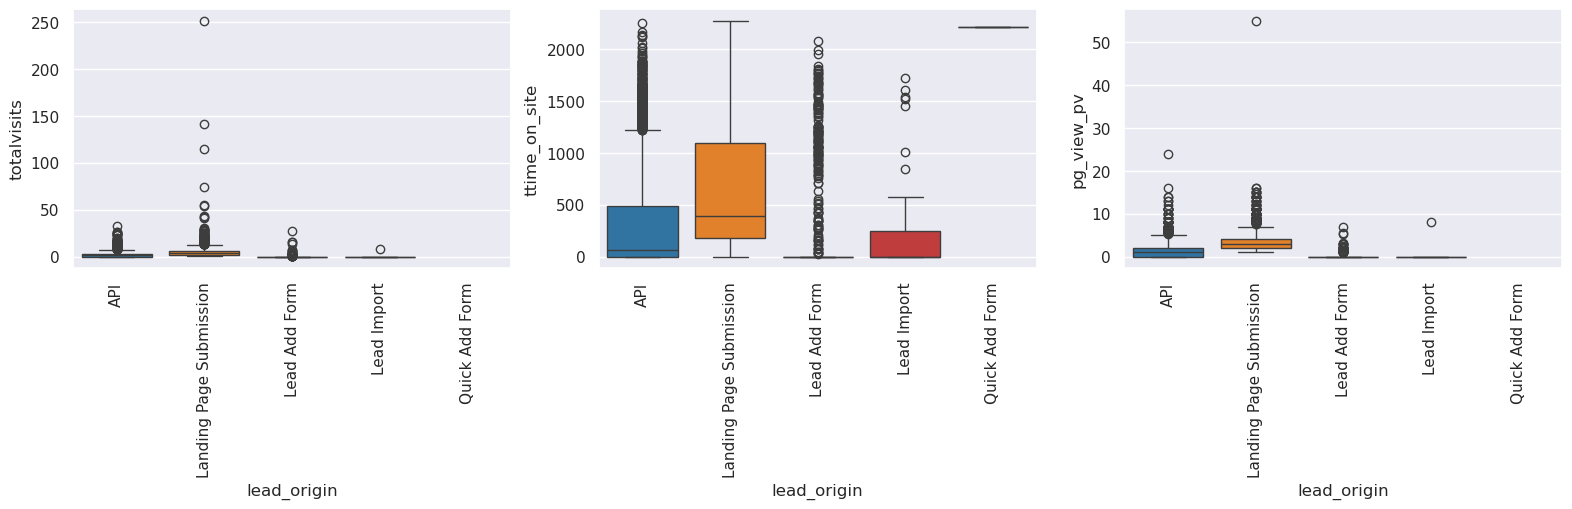

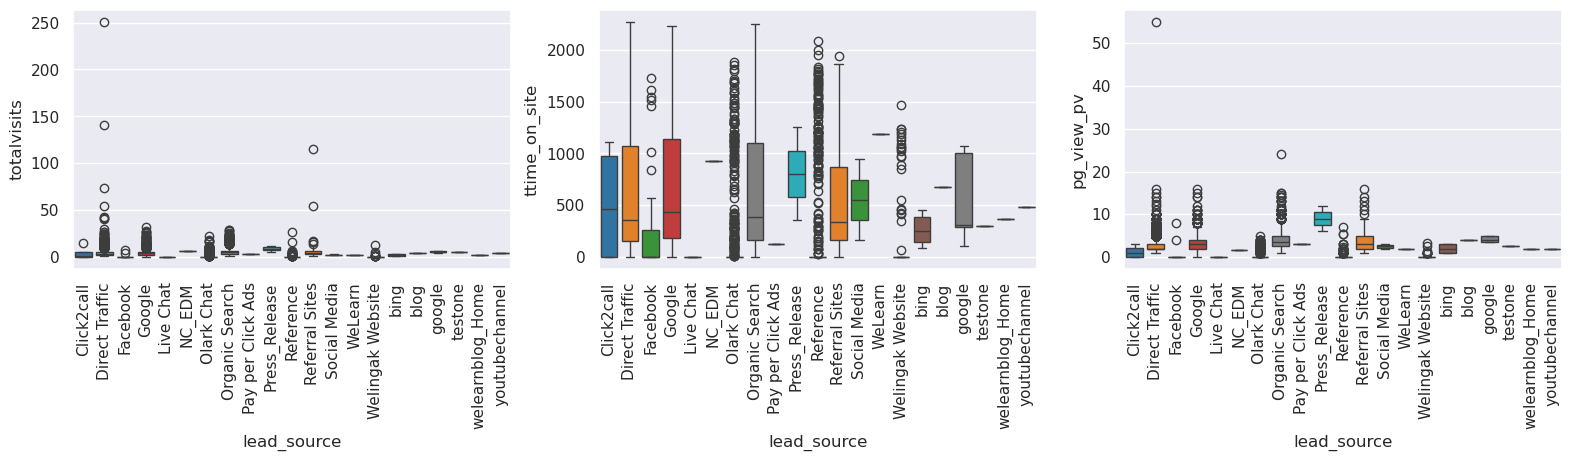

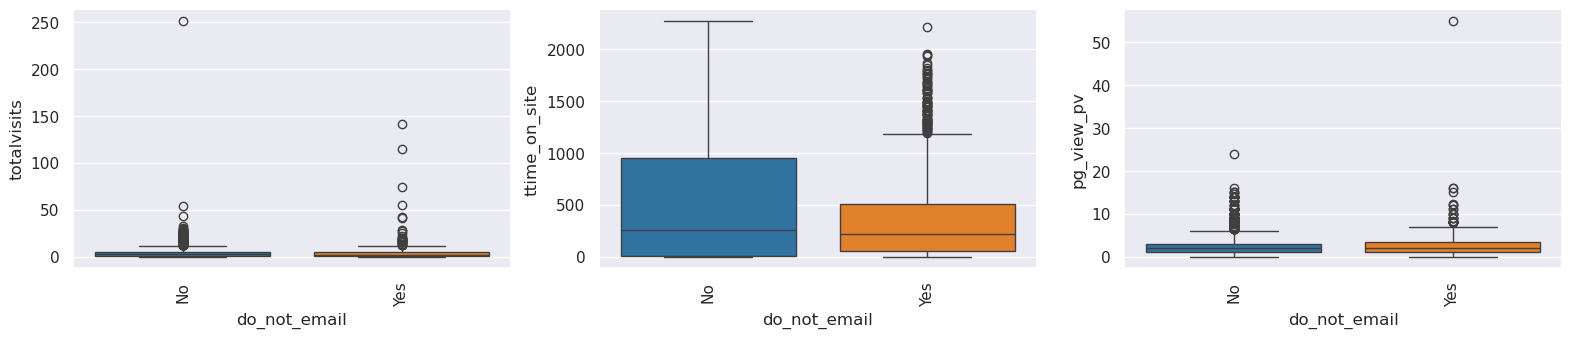

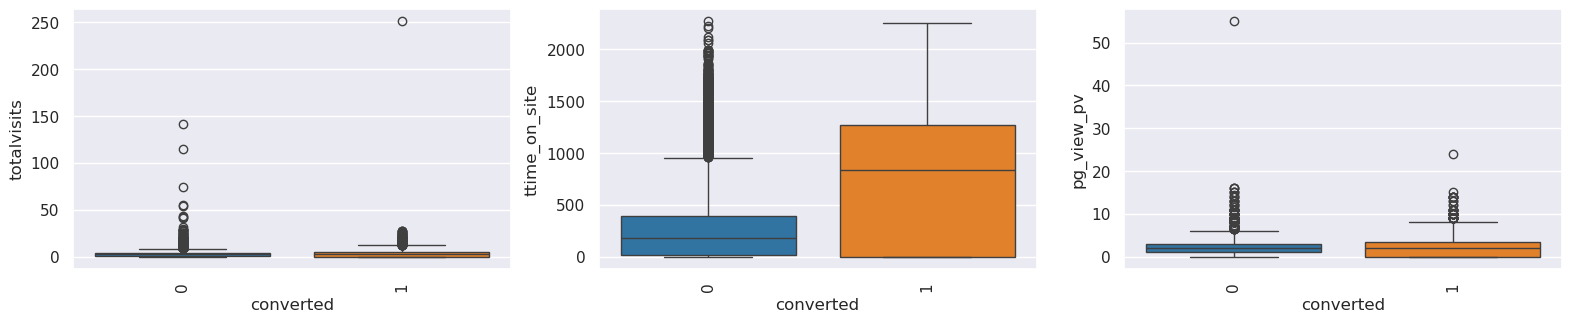

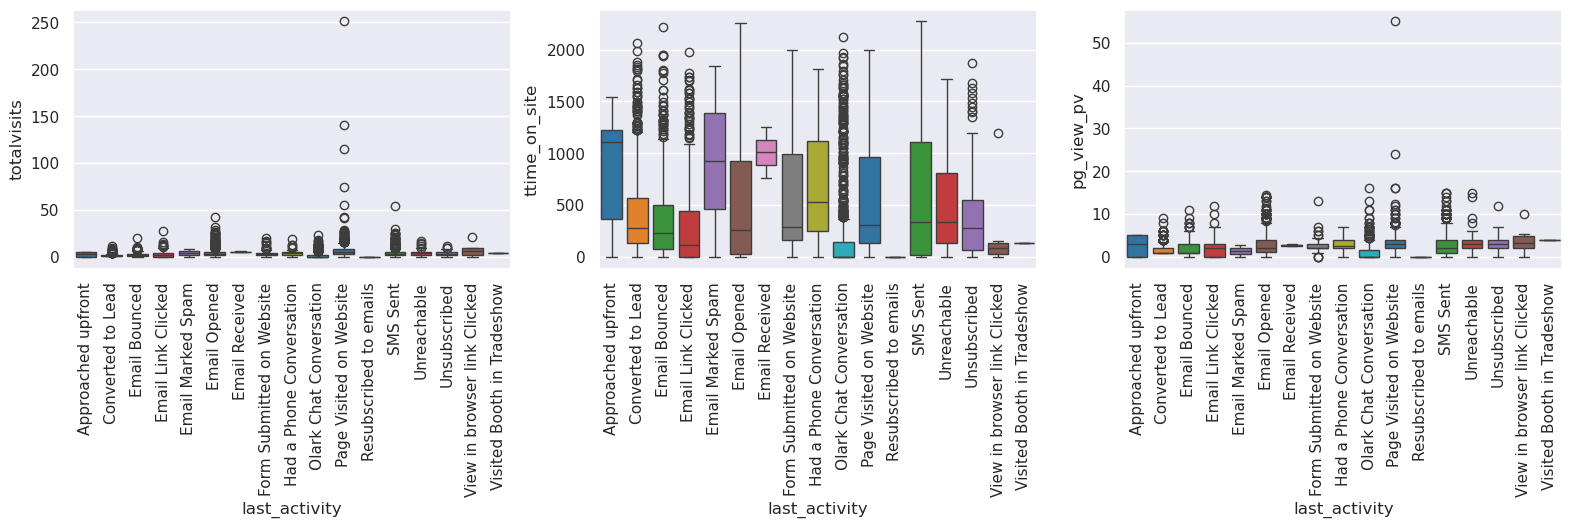

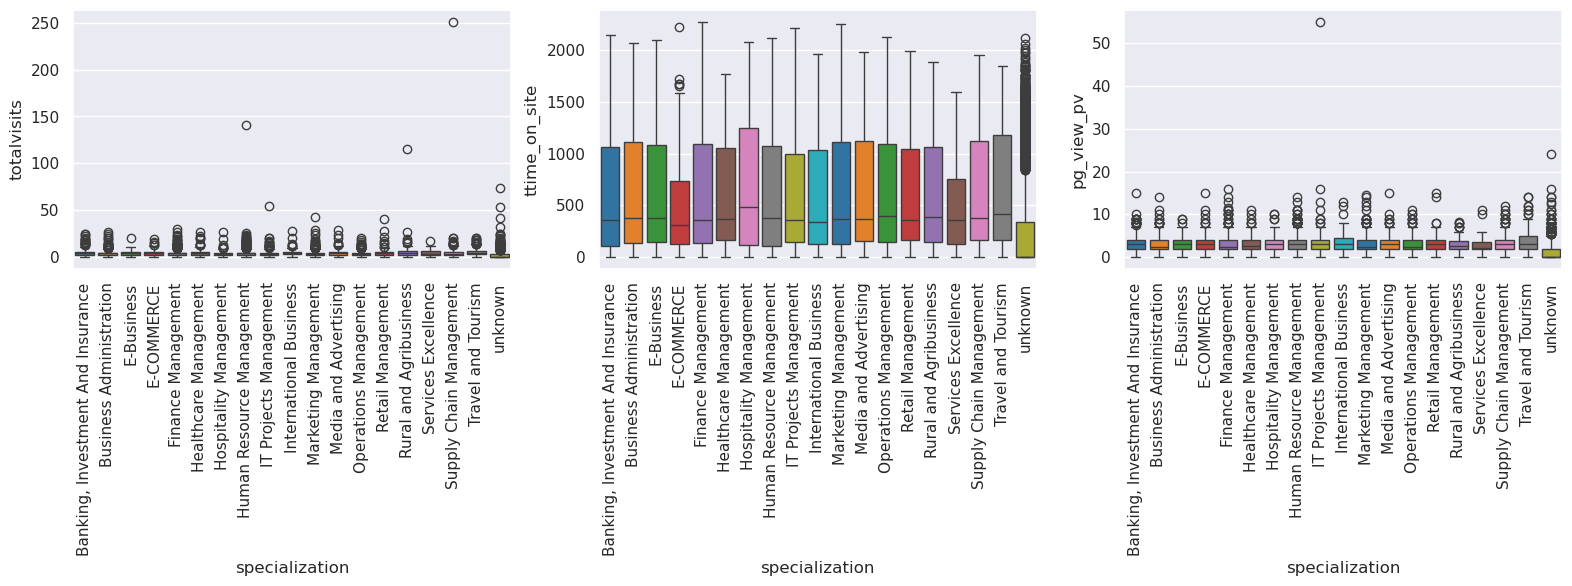

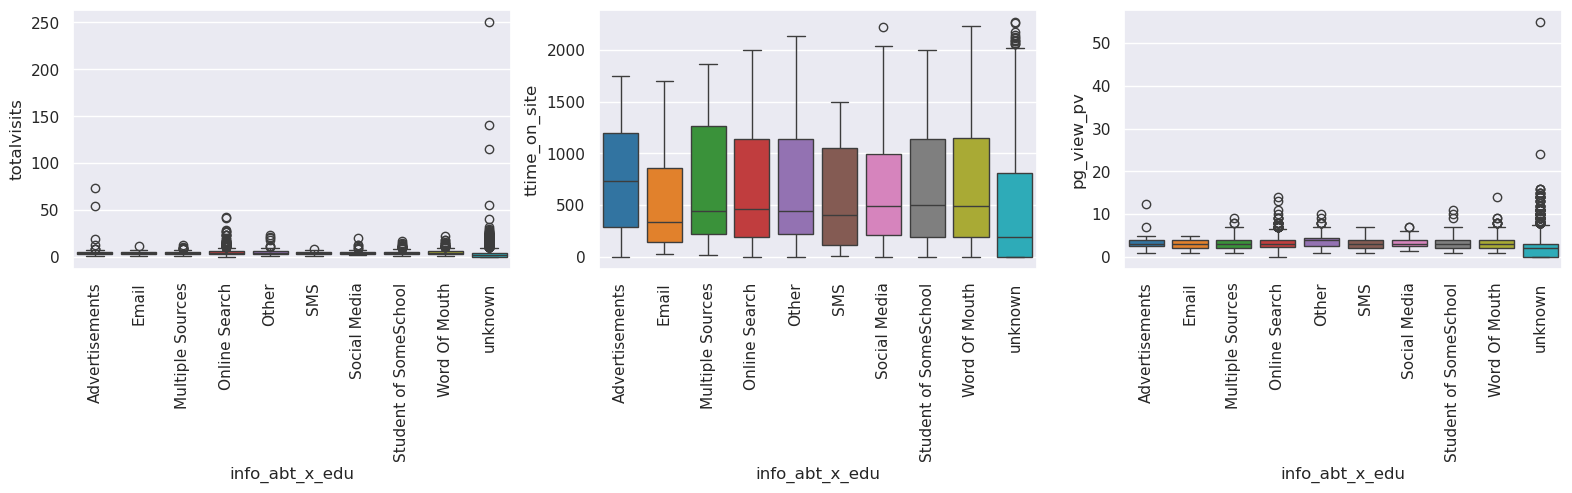

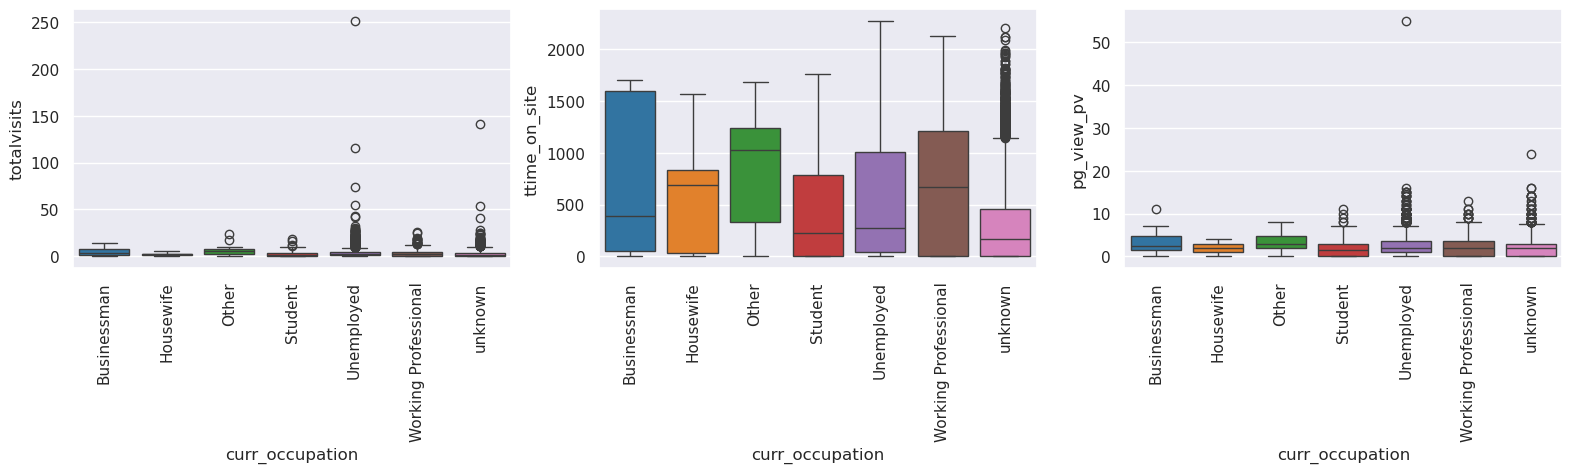

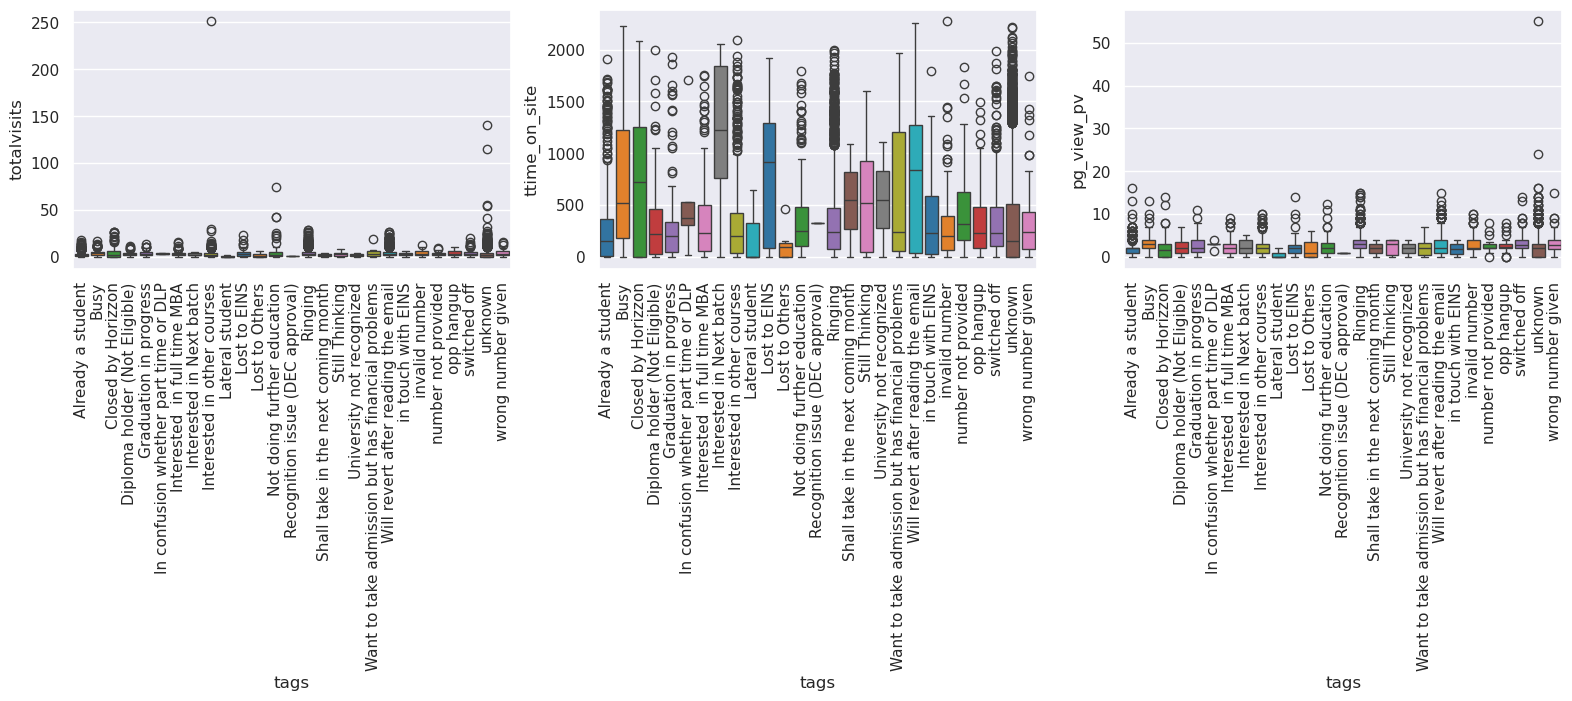

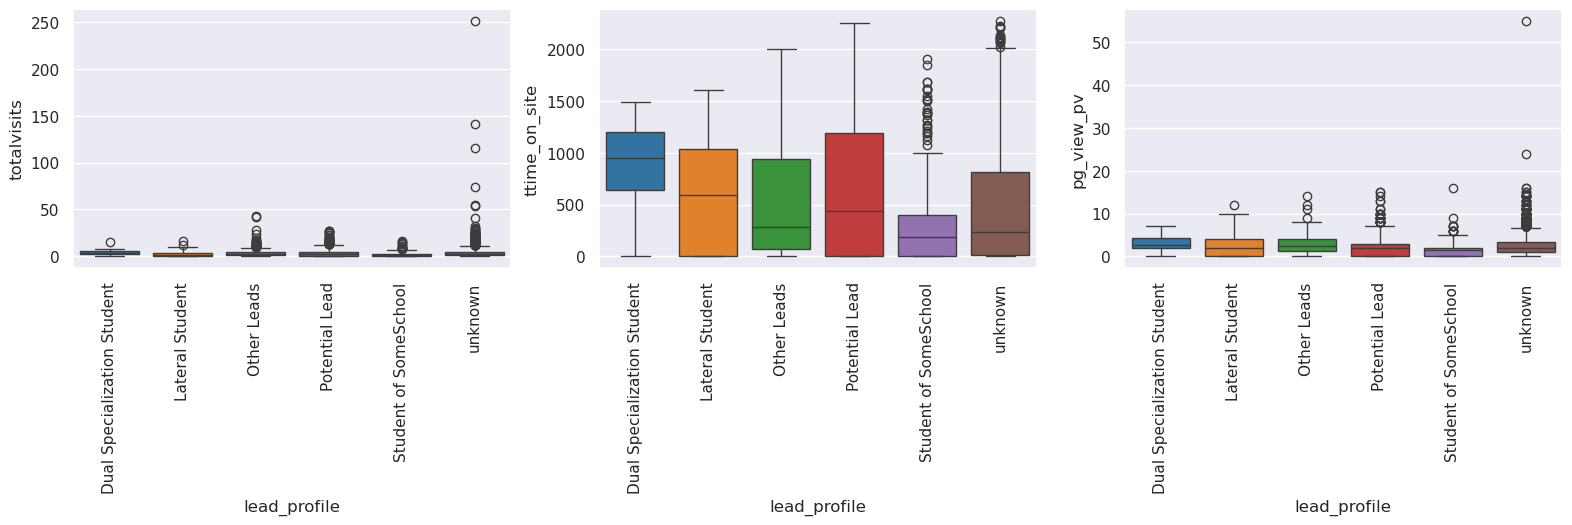

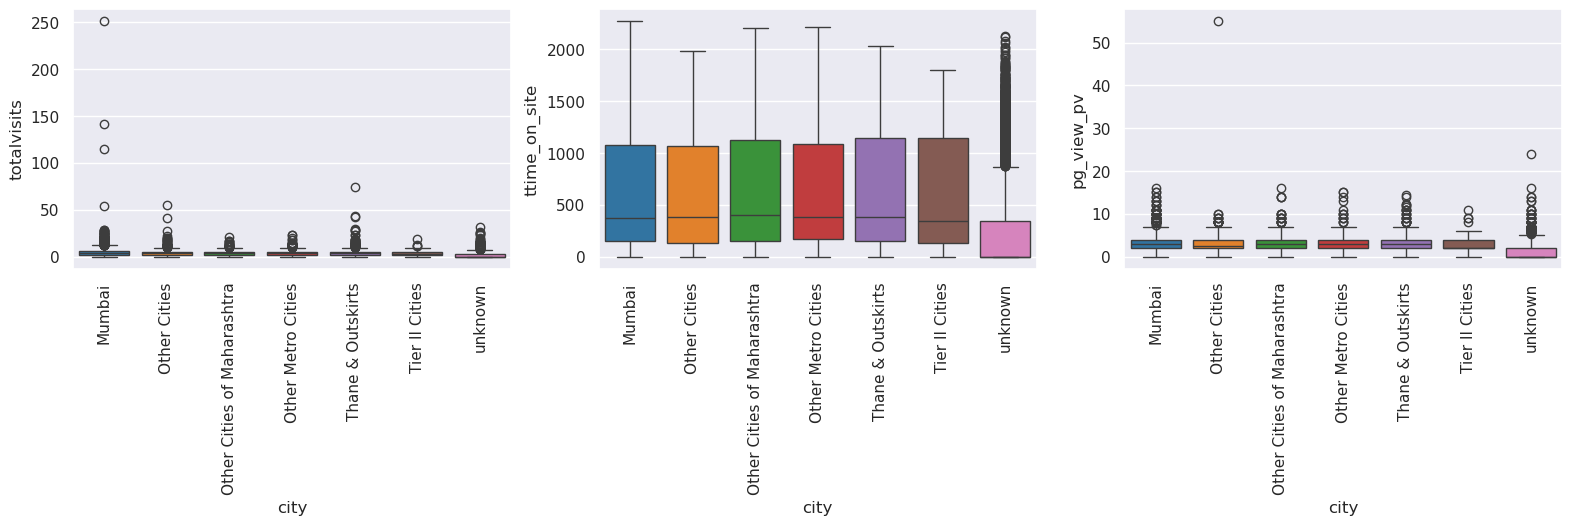

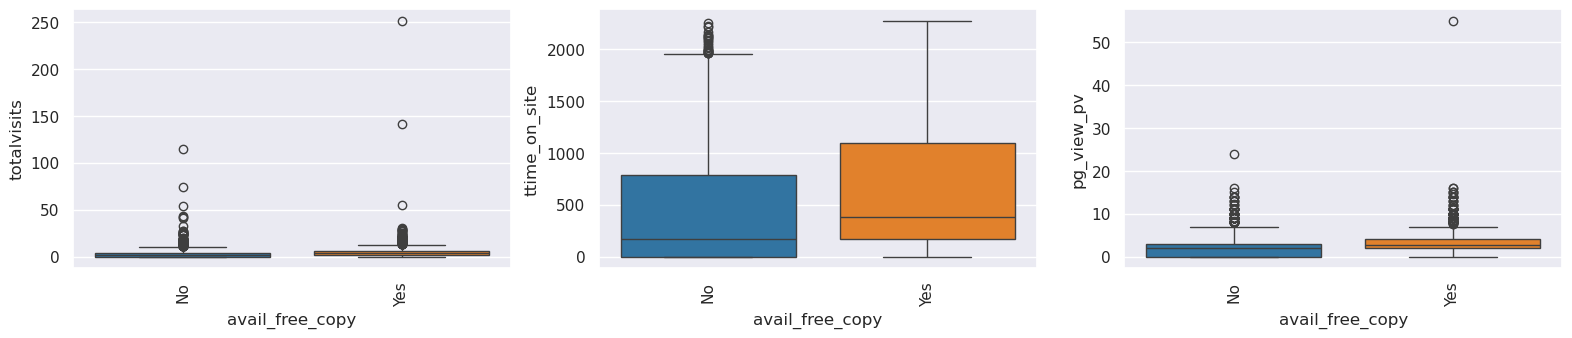

In [29]:
# # Generate Bivariate Boxplots combinations for all the categorical vs continuous columns

x_lst = list(dtype_dict['int_cat']) # x_list variable contains all the categorical Columns 
y_lst = list(dtype_dict['float_ts'])# y_list contains all Continuous feature type columns 
axs = 1
for x_col in x_lst:
    plt.figure(figsize=(26,72))
    for y_col in y_lst:
        plt.subplot(18,4,axs)
        sns.boxplot(x=x_col, y=y_col, data=lead_score_df, palette='tab10')
        plt.xticks(rotation=90)
        axs += 1
    plt.show();
    axs = 1
plt.show();

Observations:
- the leads which has converted value as 1's has higher time spent on site
- the leads which originated via landing page submission has spent more time on site, also have the higher totalvistis to ths site.
- users who opted for email also spent more time on site.
- leads who's totalvistis are high also has higher conversion, and enrolled for course.
- users who are unemployed, spent more time on site also opted for course 

###  ----------------------------------------------------------------------

### 4. Data Preprocesing - Part 2

#### Outlier Analysis and Capping

In [30]:
# After performing eda we identified outliers in "page view per visit" "totalvisits" "ttime on site" columns we therefore cap all the values to the upper cut off and lower cut off of the iqr range

ex_val_df = get_extremeval_threshld(df=lead_score_df.select_dtypes(exclude=['category','object']) )
ex_val_df
lead_score_df.describe(percentiles=[.05,.1,.2,.5,.8,.9])

thresh_low  thresh_high
name                                  
converted          -1.500        2.500
totalvisits        -5.000       11.000
ttime_on_site   -1374.000     2322.000
pg_view_pv         -2.000        6.000

converted  totalvisits  ttime_on_site  pg_view_pv
count   9240.000     9103.000       9240.000    9103.000
mean       0.385        3.445        487.698       2.363
std        0.487        4.855        548.021       2.161
min        0.000        0.000          0.000       0.000
5%         0.000        0.000          0.000       0.000
10%        0.000        0.000          0.000       0.000
20%        0.000        0.000          0.000       0.000
50%        0.000        3.000        248.000       2.000
80%        1.000        5.000       1087.200       4.000
90%        1.000        7.000       1380.000       5.000
max        1.000      251.000       2272.000      55.000

In [31]:
# Fix Outliers by setting either thresh low or thresh low for both extremes 
lower_cutoff = ex_val_df.loc['pg_view_pv','thresh_low']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] < lower_cutoff), lower_cutoff, lead_score_df['pg_view_pv'])
upper_cutoff = ex_val_df.loc['pg_view_pv','thresh_high']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] > upper_cutoff), upper_cutoff, lead_score_df['pg_view_pv'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['totalvisits','thresh_low']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] < lower_cutoff), lower_cutoff, lead_score_df['totalvisits'])
upper_cutoff = ex_val_df.loc['totalvisits','thresh_high']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] > upper_cutoff), upper_cutoff, lead_score_df['totalvisits'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['ttime_on_site','thresh_low']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] < lower_cutoff), lower_cutoff, lead_score_df['ttime_on_site'])
upper_cutoff = ex_val_df.loc['ttime_on_site','thresh_high']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] > upper_cutoff), upper_cutoff, lead_score_df['ttime_on_site'])

In [32]:
lead_score_df.describe()

converted  totalvisits  ttime_on_site  pg_view_pv
count   9240.000     9103.000       9240.000    9103.000
mean       0.385        3.221        487.698       2.259
std        0.487        2.882        548.021       1.793
min        0.000        0.000          0.000       0.000
25%        0.000        1.000         12.000       1.000
50%        0.000        3.000        248.000       2.000
75%        1.000        5.000        936.000       3.000
max        1.000       11.000       2272.000       6.000

In [33]:
# our null values have significantly reduced
null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct>0]
lead_score_df.shape

totalvisits     1.483
pg_view_pv      1.483
last_activity   1.115
lead_source     0.390
dtype: float64

(9240, 15)

In [34]:
# dropping the rows from the 'last_activity','lead_source','totalvisits','pg_view_pv' columns as they are small in number
lead_score_df = lead_score_df.dropna(subset=['last_activity','lead_source','totalvisits','pg_view_pv'])

In [35]:
### there are no null values

null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct>0] 

Series([], dtype: float64)

In [36]:
lead_score_df.shape
lead_score_df.dtypes

(9074, 15)

lead_origin        category
lead_source        category
do_not_email       category
converted             int64
totalvisits         float64
ttime_on_site       float64
pg_view_pv          float64
last_activity      category
specialization     category
info_abt_x_edu     category
curr_occupation    category
tags               category
lead_profile       category
city               category
avail_free_copy    category
dtype: object

##### Univariate analysis Post Missing value Imputation and Outlier Capping

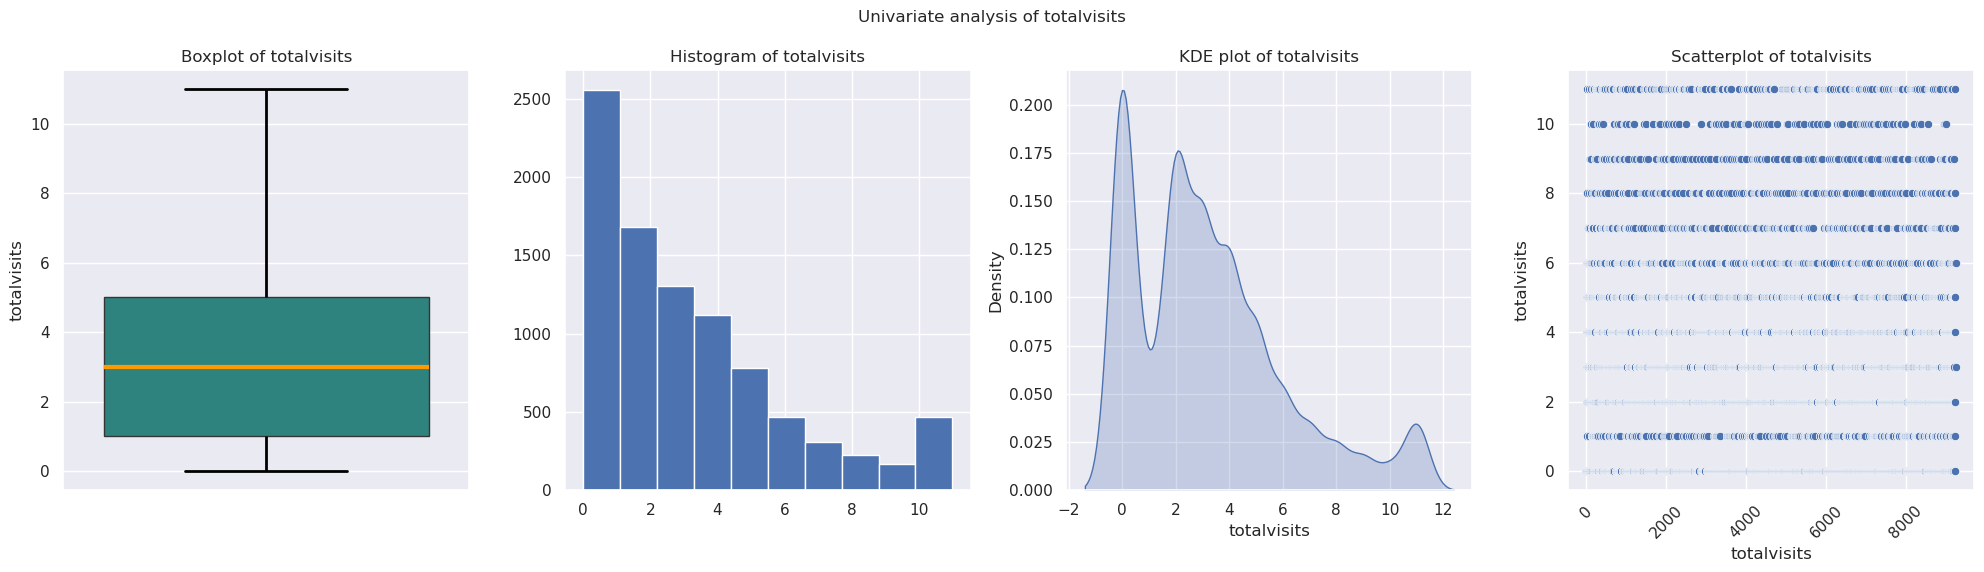

<Figure size 640x480 with 0 Axes>

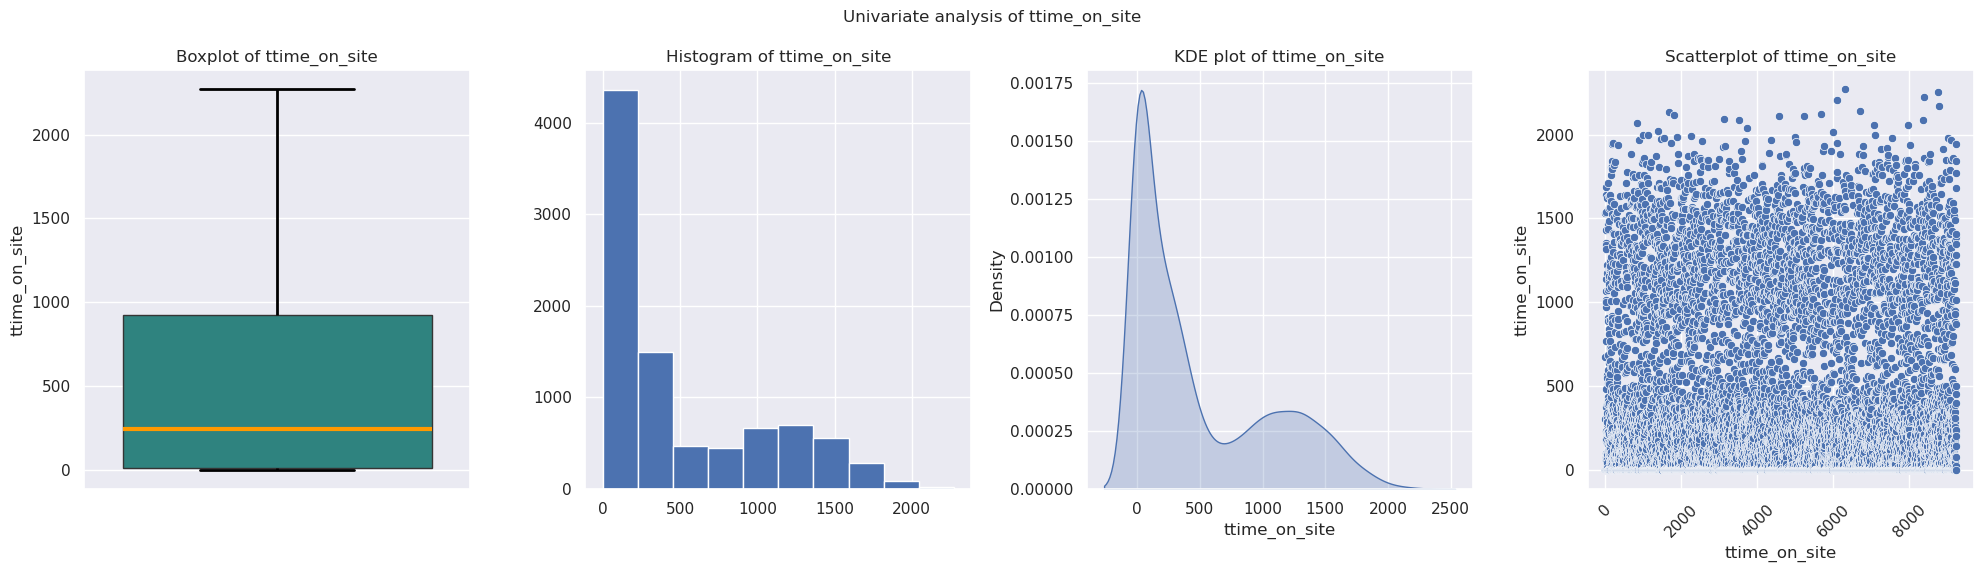

<Figure size 640x480 with 0 Axes>

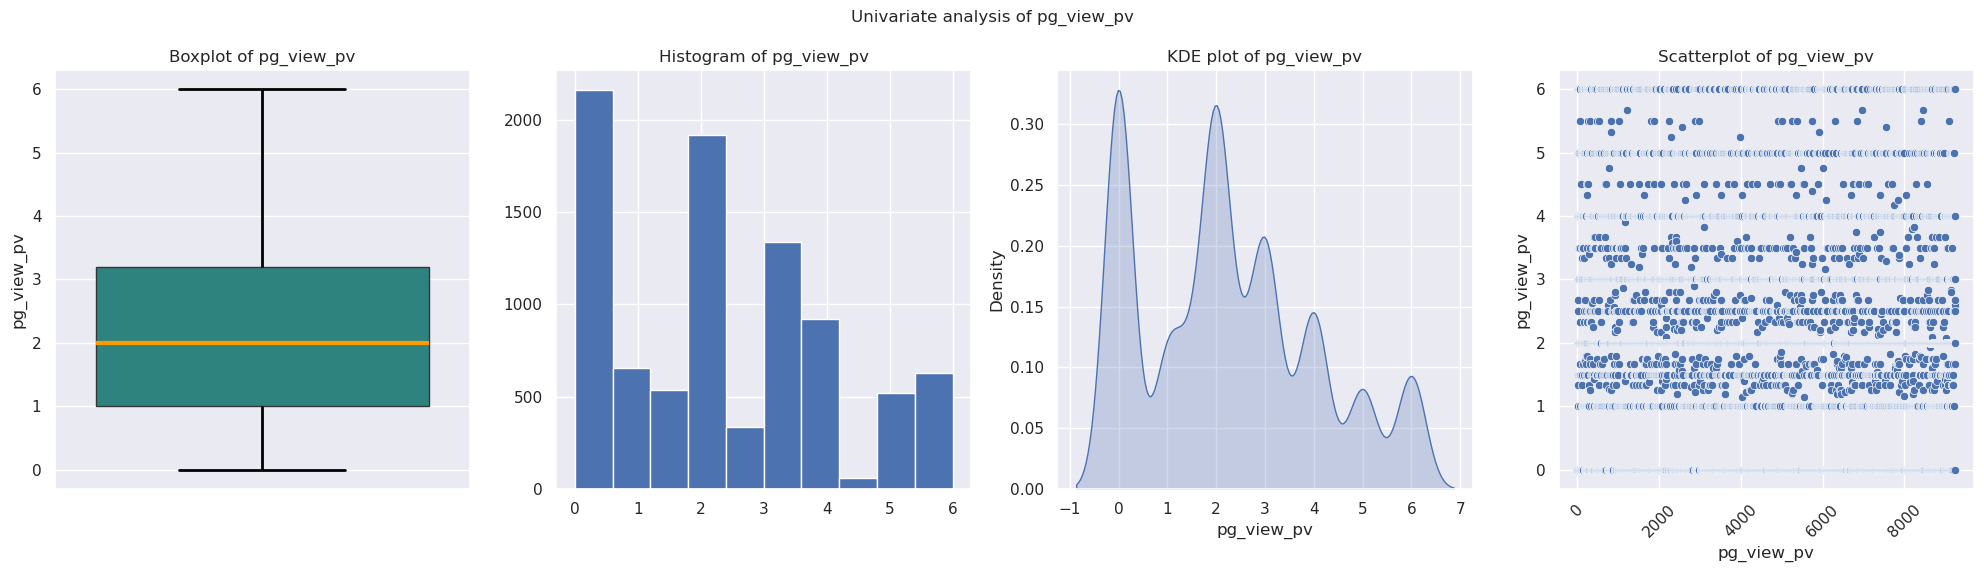

<Figure size 640x480 with 0 Axes>

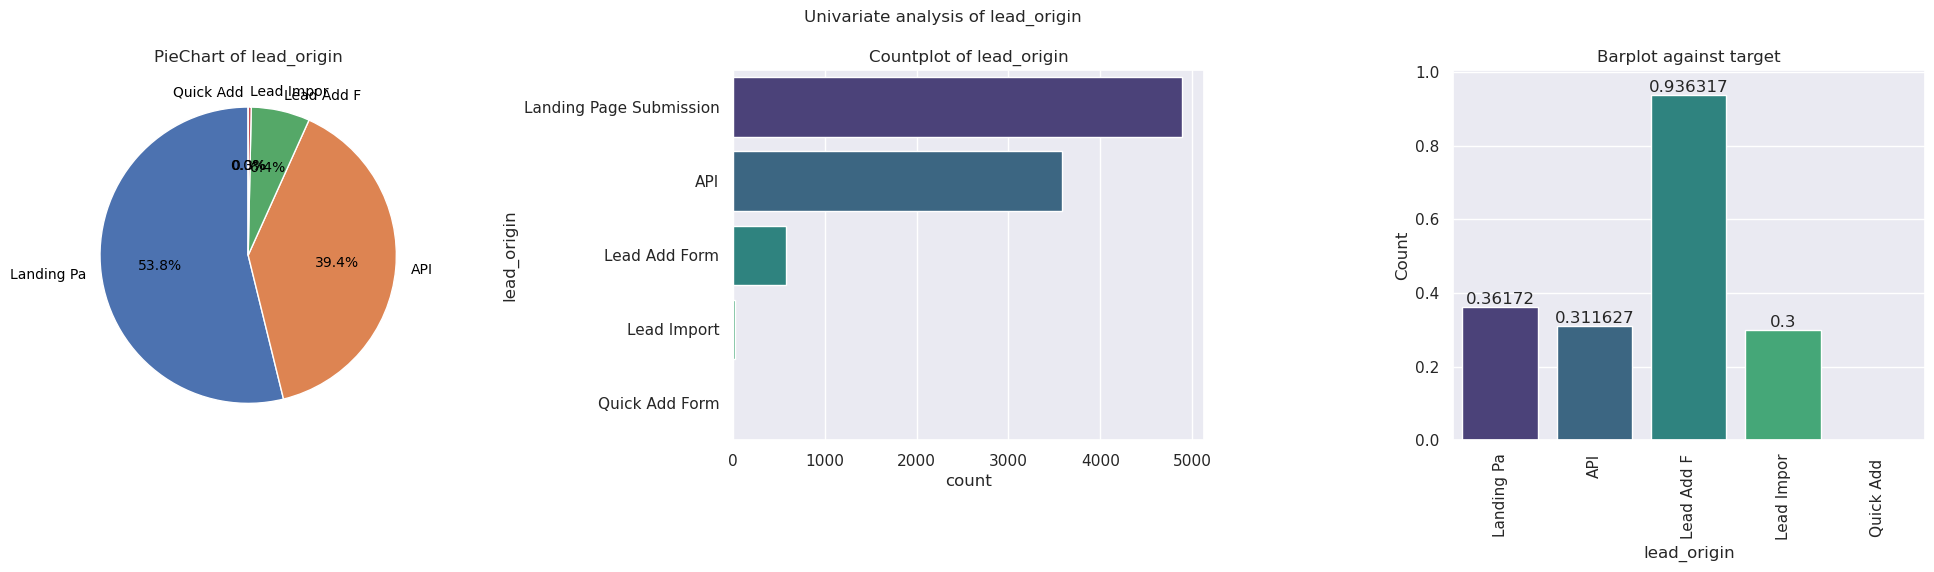

<Figure size 640x480 with 0 Axes>

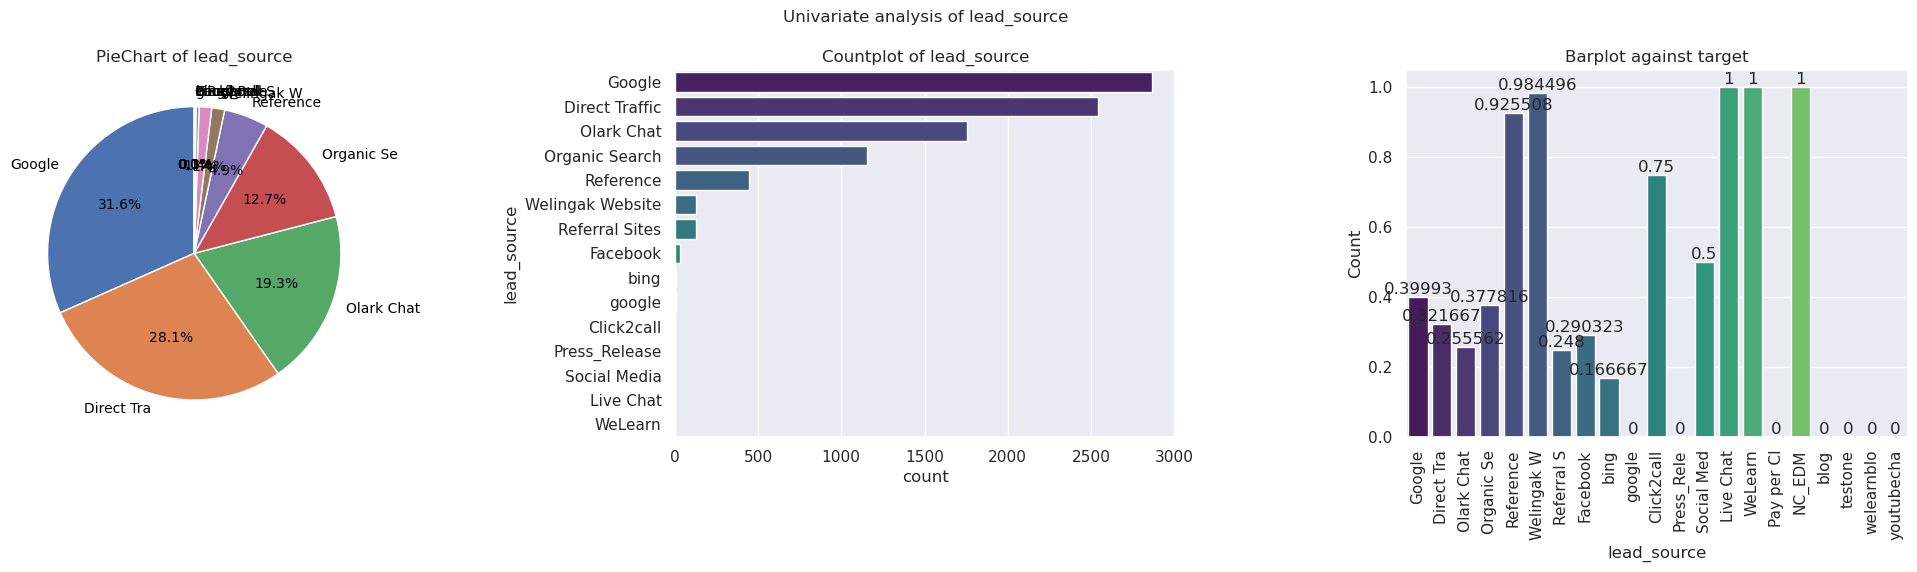

<Figure size 640x480 with 0 Axes>

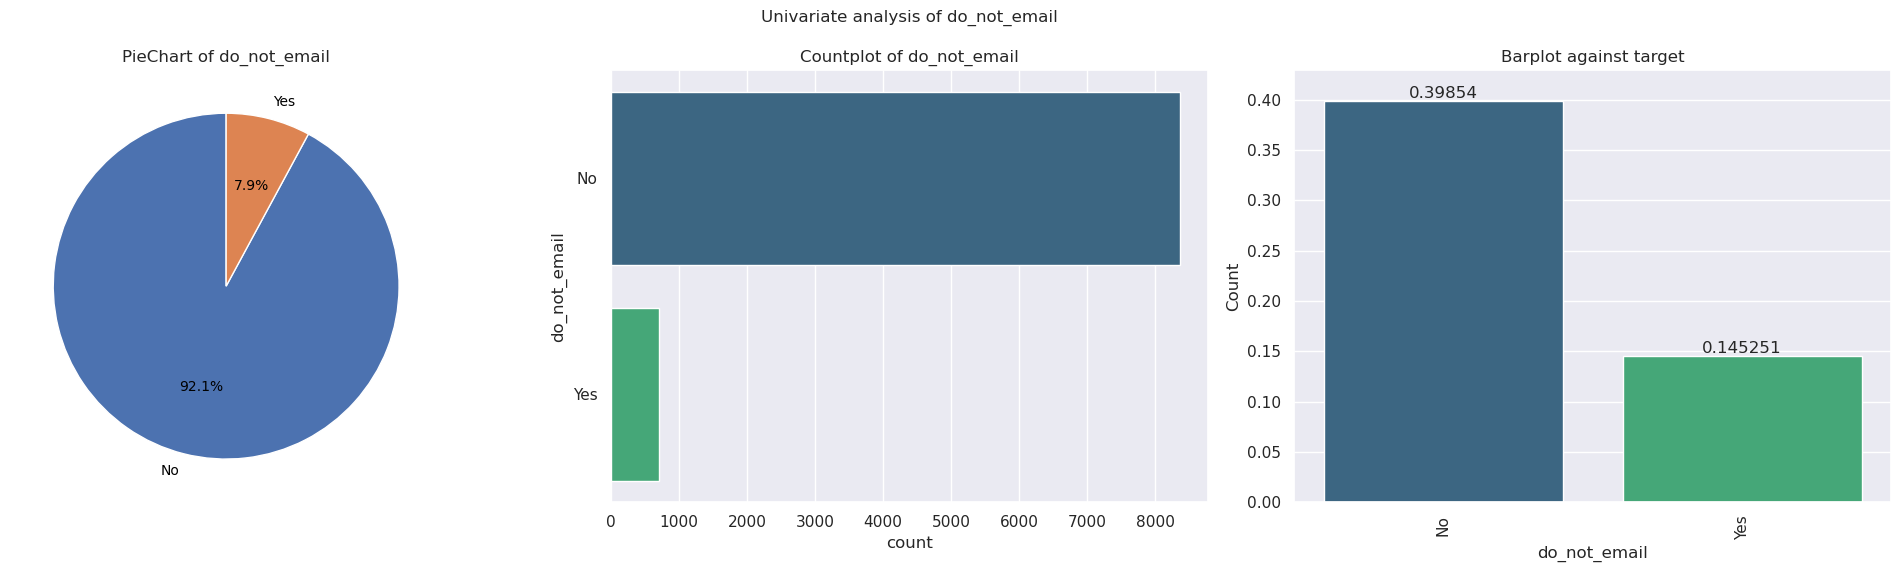

<Figure size 640x480 with 0 Axes>

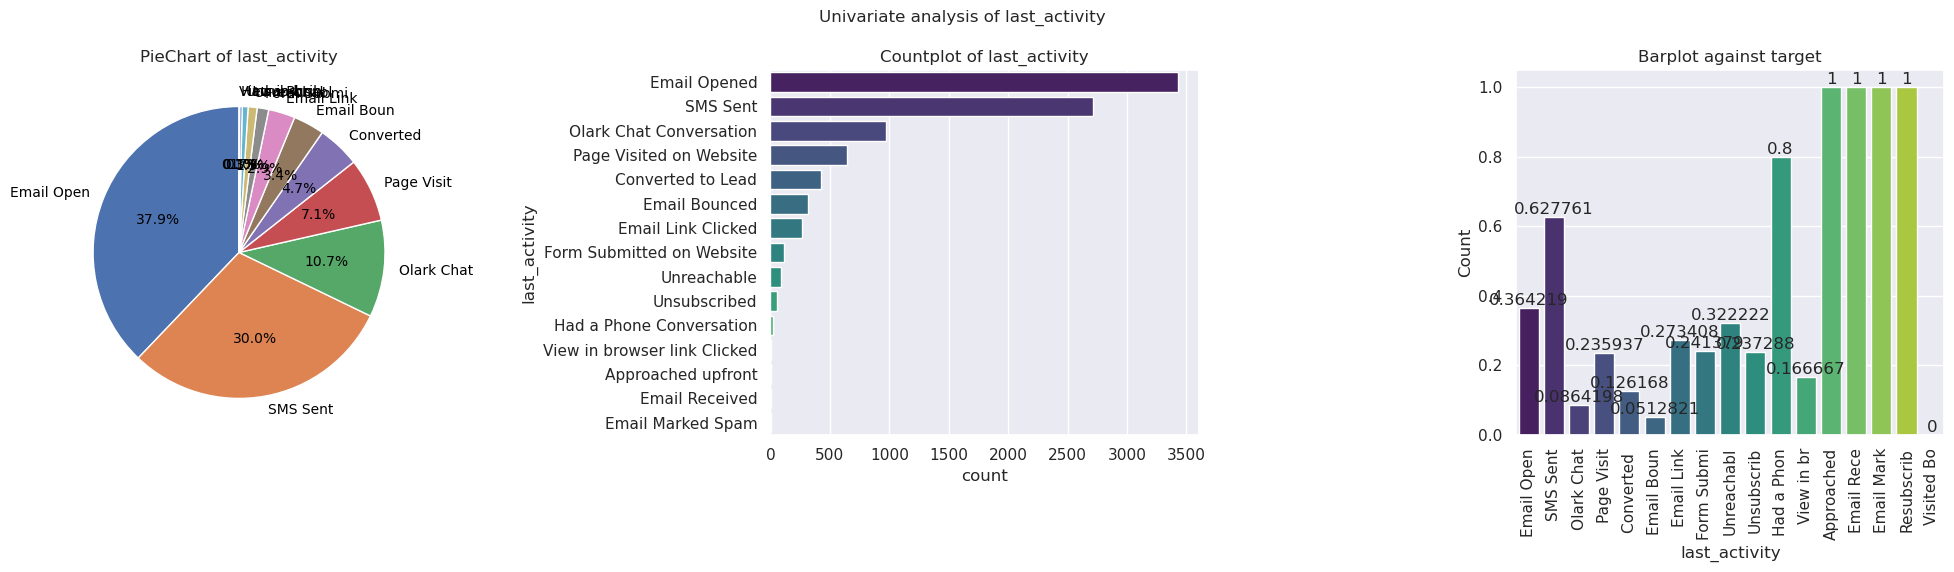

<Figure size 640x480 with 0 Axes>

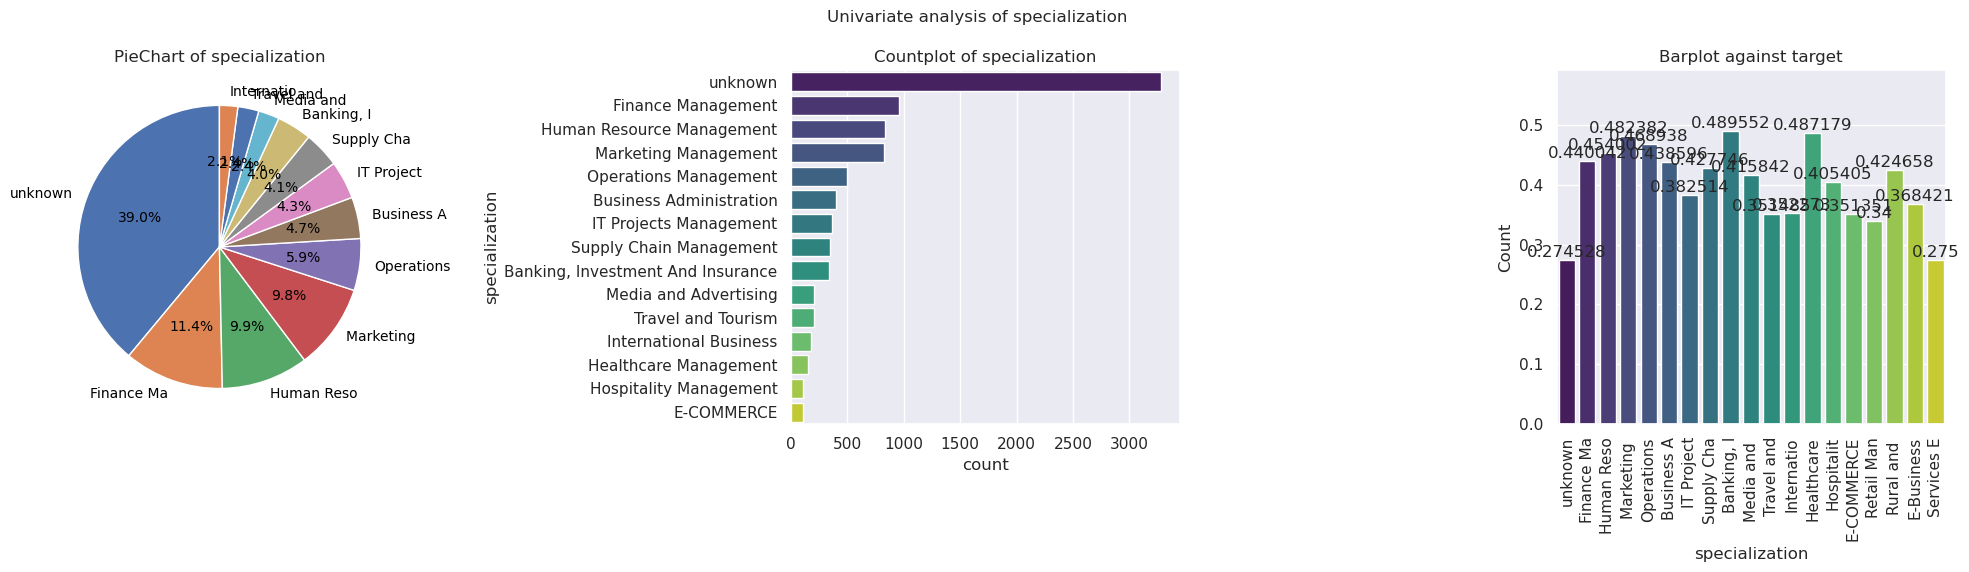

<Figure size 640x480 with 0 Axes>

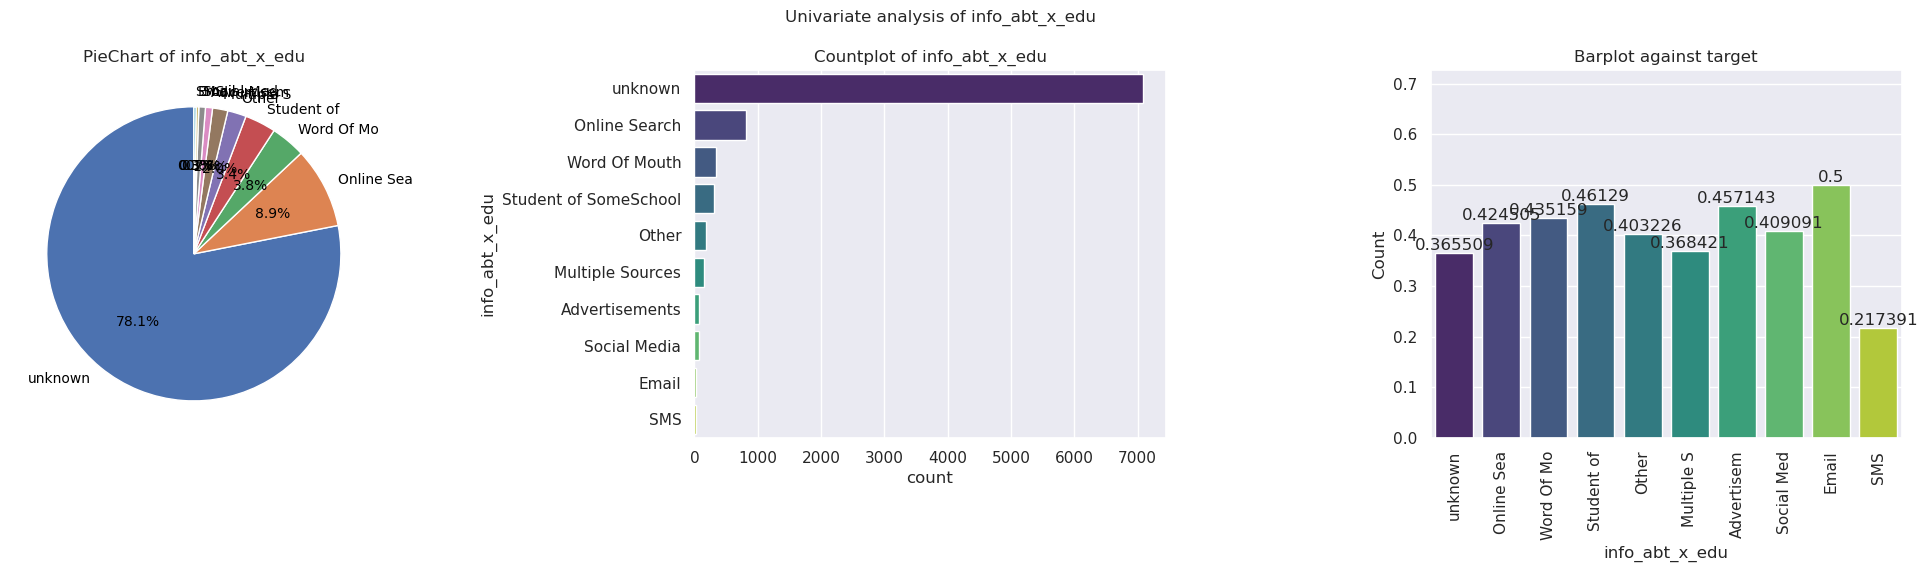

<Figure size 640x480 with 0 Axes>

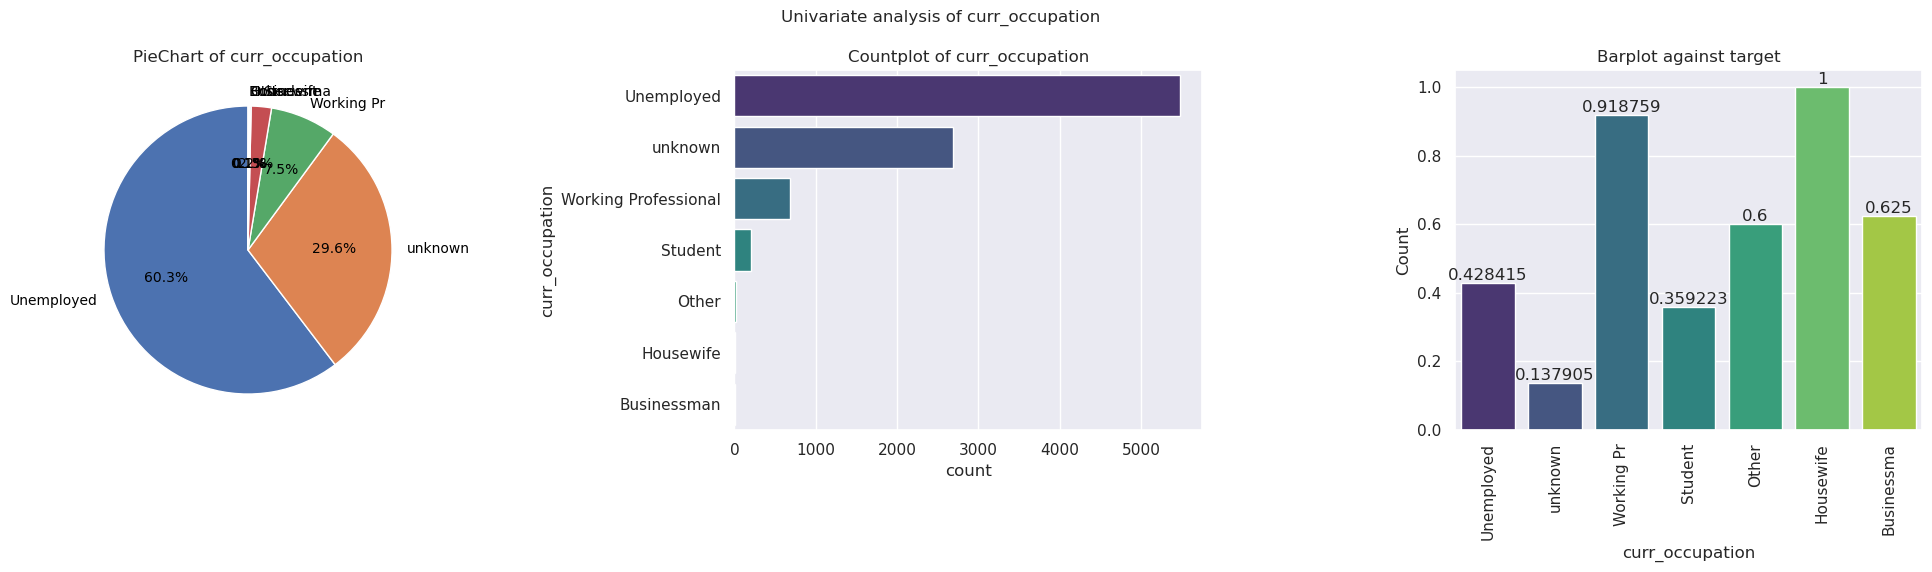

<Figure size 640x480 with 0 Axes>

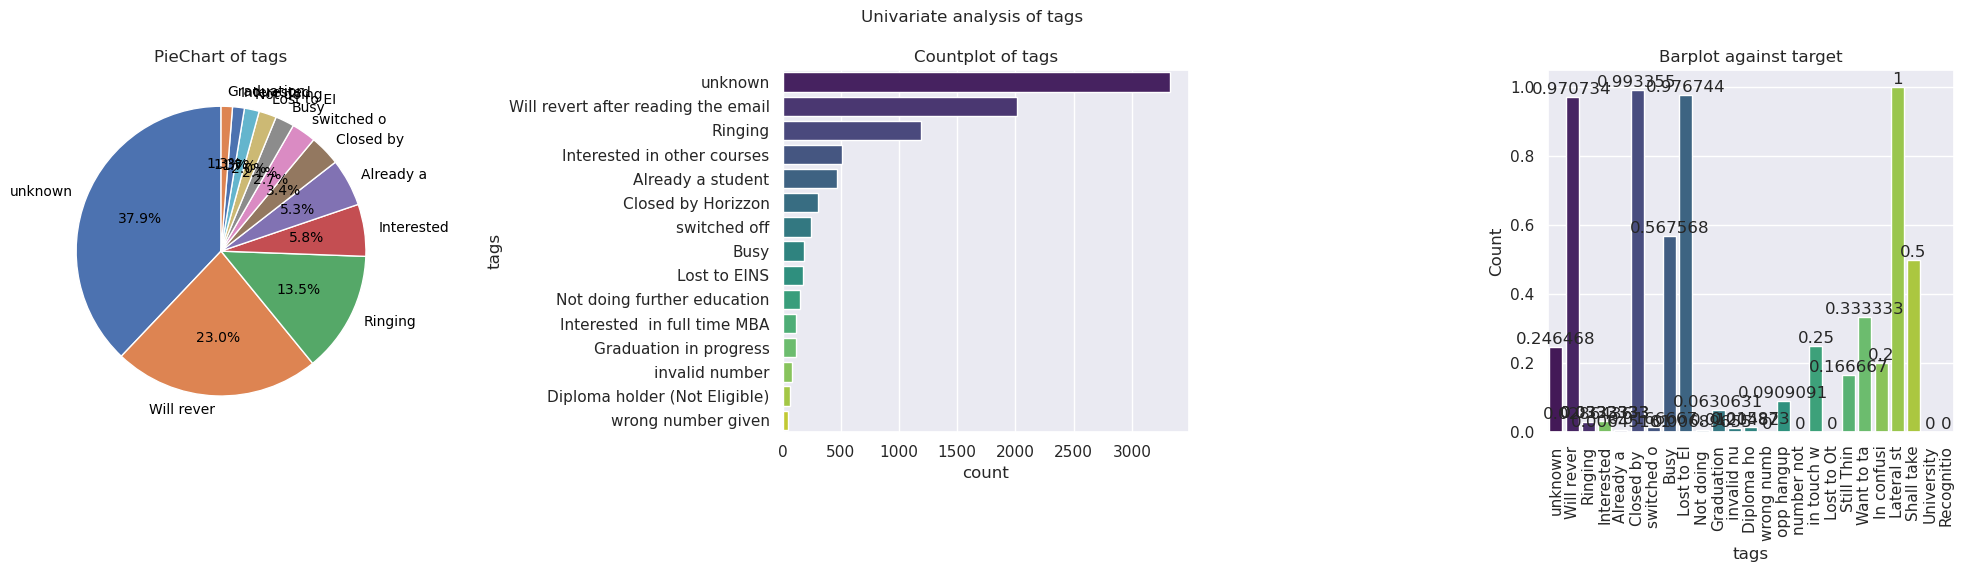

<Figure size 640x480 with 0 Axes>

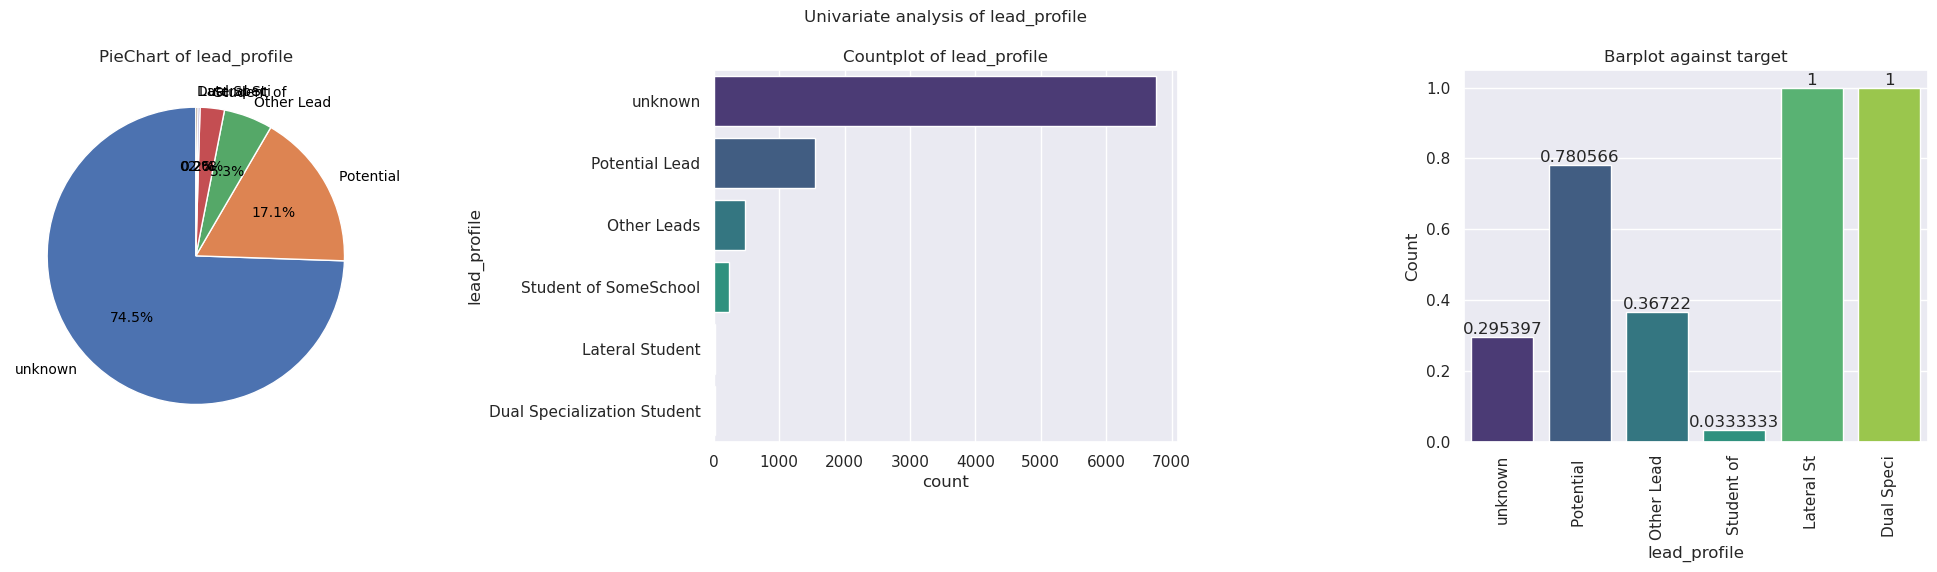

<Figure size 640x480 with 0 Axes>

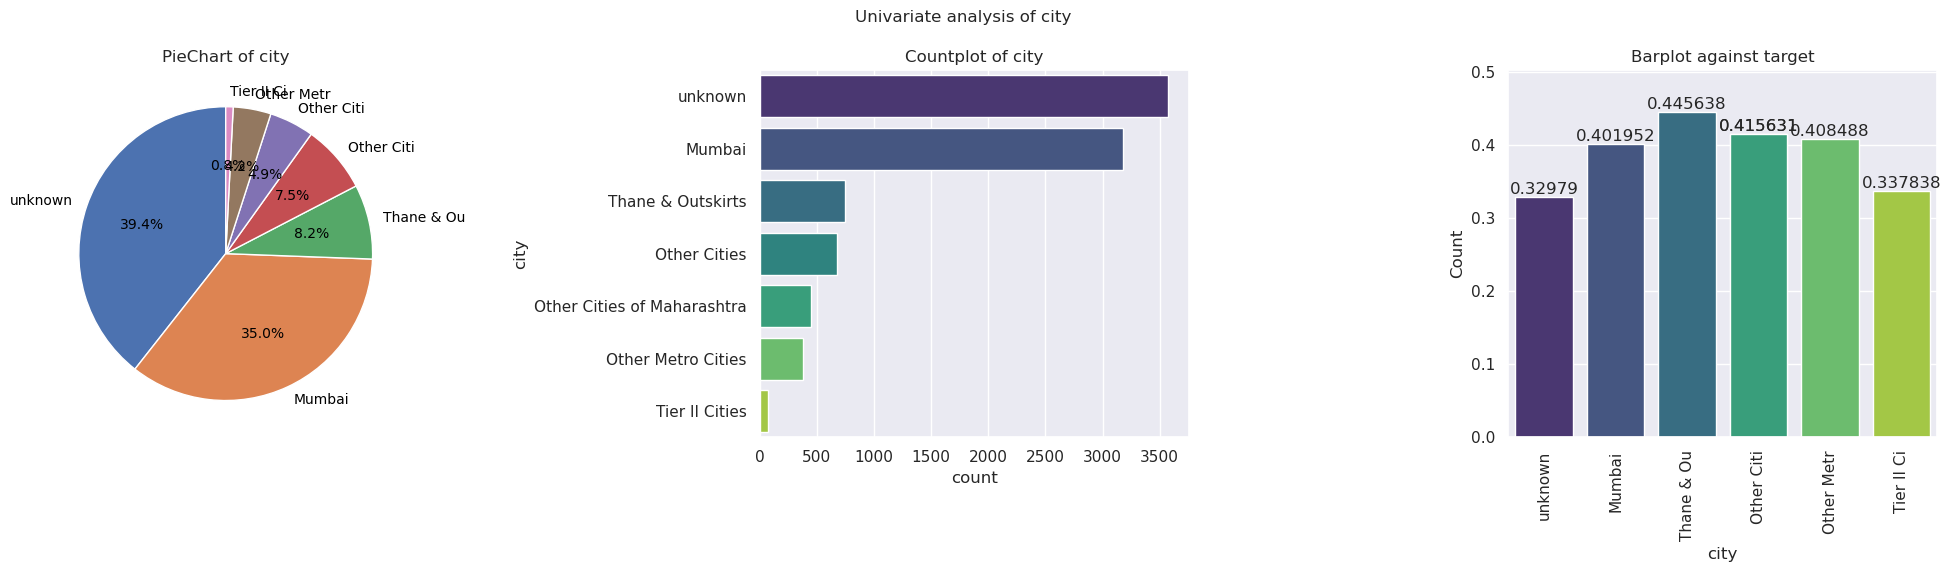

<Figure size 640x480 with 0 Axes>

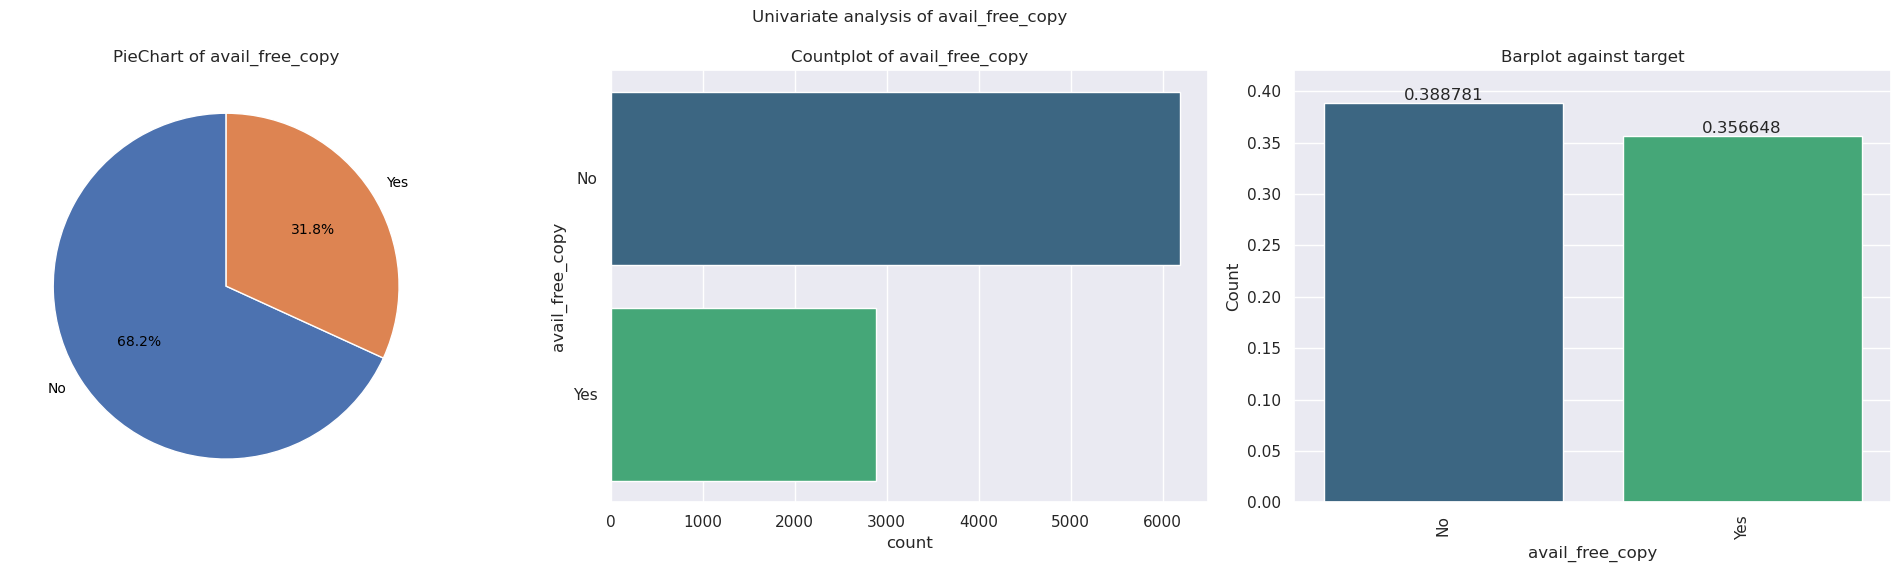

<Figure size 640x480 with 0 Axes>

In [37]:
dtype_dict = classify_feature_dtype(lead_score_df, lead_score_df.columns )
univariate_plots(lead_score_df, dtype_dict['float_ts'], ftype='non_categorical', target='converted')

cols = dtype_dict['int_cat'].copy()
cols.remove('converted')
univariate_plots(lead_score_df, cols, ftype='categorical', target='converted')

In [38]:
# replace Yes, No with 1 and 0
lead_score_df = lead_score_df.replace(to_replace=['Yes', 'No'], value=[1, 0])

In [39]:
lead_score_df.describe(include=np.number)
lead_score_df.describe(exclude=np.number)

converted  totalvisits  ttime_on_site  pg_view_pv
count   9074.000     9074.000       9074.000    9074.000
mean       0.379        3.231        482.887       2.266
std        0.485        2.881        545.257       1.791
min        0.000        0.000          0.000       0.000
25%        0.000        1.000         11.000       1.000
50%        0.000        3.000        246.000       2.000
75%        1.000        5.000        922.750       3.200
max        1.000       11.000       2272.000       6.000

lead_origin lead_source  do_not_email last_activity  \
count                      9074        9074          9074          9074   
unique                        4          21             2            17   
top     Landing Page Submission      Google             0  Email Opened   
freq                       4885        2868          8358          3432   

       specialization info_abt_x_edu curr_occupation     tags lead_profile  \
count            9074           9074            9074     9074         9074   
unique             19             10               7       27            6   
top           unknown        unknown      Unemployed  unknown      unknown   
freq             3282           7086            5476     3327         6757   

           city  avail_free_copy  
count      9074             9074  
unique        7                2  
top     unknown                0  
freq       3575             6186

###  ----------------------------------------------------------------------

### 5. Data Imbalance & Conversion Ratio

In [40]:
# Data Imbalance
# From the target variable we have found out the imbalance ratios around 60 therefore we decide not to rebalance

imbalance_ratio = sum(lead_score_df['converted'] == 1)/sum(lead_score_df['converted'] == 0) * 100
print(f'{round(imbalance_ratio, 2)}%')

60.92%


In [41]:
# Conversion Ratio 
# From the target variable the conversion ratio is around 38 it shows that there is a very high probability of failure in conversion

converted = (sum(lead_score_df['converted'])/len(lead_score_df['converted'].index))*100
print(f'{round(converted, 2)}%')

37.86%


##  -----------------------------------------------------

In [42]:
# errorline # do no remove this line

## -----------------------------------------------------

## Approach - 01 
- (Dummy Encoding, Standard Scaling)
.

### Dummy Encoding

In [43]:
#  we perform dummy encoding
new_ls_df = pd.get_dummies(lead_score_df, columns=lead_score_df.select_dtypes('category').columns.difference(['tags','specialization','info_abt_x_edu', 'lead_profile', 'city', 'curr_occupation']), drop_first=True, dtype=float)
new_ls_df.head(1)
new_ls_df.shape

converted  totalvisits  ttime_on_site  pg_view_pv specialization  \
0          0        0.000          0.000       0.000        unknown   

  info_abt_x_edu curr_occupation                         tags lead_profile  \
0        unknown      Unemployed  Interested in other courses      unknown   

      city  avail_free_copy_1  do_not_email_1  \
0  unknown              0.000           0.000   

   last_activity_Converted to Lead  last_activity_Email Bounced  \
0                            0.000                        0.000   

   last_activity_Email Link Clicked  last_activity_Email Marked Spam  \
0                             0.000                            0.000   

   last_activity_Email Opened  last_activity_Email Received  \
0                       0.000                         0.000   

   last_activity_Form Submitted on Website  \
0                                    0.000   

   last_activity_Had a Phone Conversation  \
0                                   0.000   

   last_activity_Olark Chat Conversation  \
0                                  0.000   

   last_activity_Page Visited on Website  \
0                                  1.000   

   last_activity_Resubscribed to emails  last_activity_SMS Sent  \
0                                 0.000                   0.000   

   last_activity_Unreachable  last_activity_Unsubscribed  \
0                      0.000                       0.000   

   last_activity_View in browser link Clicked  \
0                                       0.000   

   last_activity_Visited Booth in Tradeshow  \
0                                     0.000   

   lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
0                                0.000                      0.000   

   lead_origin_Lead Import  lead_origin_Quick Add Form  \
0                    0.000                       0.000   

   lead_source_Direct Traffic  lead_source_Facebook  lead_source_Google  \
0                       0.000                 0.000               0.000   

   lead_source_Live Chat  lead_source_NC_EDM  lead_source_Olark Chat  \
0                  0.000               0.000                   1.000   

   lead_source_Organic Search  lead_source_Pay per Click Ads  \
0                       0.000                          0.000   

   lead_source_Press_Release  lead_source_Reference  \
0                      0.000                  0.000   

   lead_source_Referral Sites  lead_source_Social Media  lead_source_WeLearn  \
0                       0.000                     0.000                0.000   

   lead_source_Welingak Website  lead_source_bing  lead_source_blog  \
0                         0.000             0.000             0.000   

   lead_source_google  lead_source_testone  lead_source_welearnblog_Home  \
0               0.000                0.000                         0.000   

   lead_source_youtubechannel  
0                       0.000

(9074, 52)

In [44]:
# Creating dummy variable separately for the variable 'tags', 'specialization', 'info_abt_x_edu', 'lead_profile', 'city', 'curr_occupation' since it has the level 'Select' 
# which is useless so we # drop that level by specifying it explicitly
new_ls_df = pd.get_dummies(new_ls_df, columns=['tags', 'specialization', 'info_abt_x_edu', 'lead_profile', 'city', 'curr_occupation'], dtype=float)

# Drop the variables for which the dummy variables have been created
new_ls_df = new_ls_df.drop(new_ls_df.filter(like='unknown',axis=1).columns, axis=1)
new_ls_df.shape


(9074, 116)

In [45]:
new_ls_df.head(2)

converted  totalvisits  ttime_on_site  pg_view_pv  avail_free_copy_1  \
0          0        0.000          0.000       0.000              0.000   
1          0        5.000        674.000       2.500              0.000   

   do_not_email_1  last_activity_Converted to Lead  \
0           0.000                            0.000   
1           0.000                            0.000   

   last_activity_Email Bounced  last_activity_Email Link Clicked  \
0                        0.000                             0.000   
1                        0.000                             0.000   

   last_activity_Email Marked Spam  last_activity_Email Opened  \
0                            0.000                       0.000   
1                            0.000                       1.000   

   last_activity_Email Received  last_activity_Form Submitted on Website  \
0                         0.000                                    0.000   
1                         0.000                                    0.000   

   last_activity_Had a Phone Conversation  \
0                                   0.000   
1                                   0.000   

   last_activity_Olark Chat Conversation  \
0                                  0.000   
1                                  0.000   

   last_activity_Page Visited on Website  \
0                                  1.000   
1                                  0.000   

   last_activity_Resubscribed to emails  last_activity_SMS Sent  \
0                                 0.000                   0.000   
1                                 0.000                   0.000   

   last_activity_Unreachable  last_activity_Unsubscribed  \
0                      0.000                       0.000   
1                      0.000                       0.000   

   last_activity_View in browser link Clicked  \
0                                       0.000   
1                                       0.000   

   last_activity_Visited Booth in Tradeshow  \
0                                     0.000   
1                                     0.000   

   lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
0                                0.000                      0.000   
1                                0.000                      0.000   

   lead_origin_Lead Import  lead_origin_Quick Add Form  \
0                    0.000                       0.000   
1                    0.000                       0.000   

   lead_source_Direct Traffic  lead_source_Facebook  lead_source_Google  \
0                       0.000                 0.000               0.000   
1                       0.000                 0.000               0.000   

   lead_source_Live Chat  lead_source_NC_EDM  lead_source_Olark Chat  \
0                  0.000               0.000                   1.000   
1                  0.000               0.000                   0.000   

   lead_source_Organic Search  lead_source_Pay per Click Ads  \
0                       0.000                          0.000   
1                       1.000                          0.000   

   lead_source_Press_Release  lead_source_Reference  \
0                      0.000                  0.000   
1                      0.000                  0.000   

   lead_source_Referral Sites  lead_source_Social Media  lead_source_WeLearn  \
0                       0.000                     0.000                0.000   
1                       0.000                     0.000                0.000   

   lead_source_Welingak Website  lead_source_bing  lead_source_blog  \
0                         0.000             0.000             0.000   
1                         0.000             0.000             0.000   

   lead_source_google  lead_source_testone  lead_source_welearnblog_Home  \
0               0.000                0.000                         0.000   
1               0.000                0.000                         0.000   

   lead_source_youtubechannel  tags_A

###  ----------------------------------------------------------------------

### Train and Test Split
- split the dataset into training an testing sets.

In [46]:
# spliting the data into independent and target variable
X = new_ls_df.drop(['converted'], axis=1)
y = new_ls_df['converted']

In [47]:
# Split the dataset into 70% train and 30% test, and set the random state to 100
# np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=100)

# Check the shape of the train dataset and the test dataset
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6351, 115)
(2723, 115)
(6351,)
(2723,)


###  ----------------------------------------------------------------------

### Feature Scaling
- Now there are a few numeric variables present in the dataset which have different scales

In [48]:
# Post split we perform standard scaling they fit and transform the train data set
# to_scale = ['totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = list(X.columns)

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale], y_train)
X_train.head(5)

totalvisits  ttime_on_site  pg_view_pv  avail_free_copy_1  \
3009       -0.431         -0.160      -0.155              1.473   
1012       -0.431         -0.540      -0.155             -0.679   
9226       -1.125         -0.889      -1.266             -0.679   
4750       -0.431          1.643      -0.155             -0.679   
7987        0.609          2.018       0.123             -0.679   

      do_not_email_1  last_activity_Converted to Lead  \
3009          -0.293                           -0.216   
1012           3.417                           -0.216   
9226          -0.293                           -0.216   
4750          -0.293                           -0.216   
7987          -0.293                           -0.216   

      last_activity_Email Bounced  last_activity_Email Link Clicked  \
3009                       -0.189                            -0.170   
1012                        5.279                            -0.170   
9226                       -0.189                            -0.170   
4750                       -0.189                            -0.170   
7987                       -0.189                            -0.170   

      last_activity_Email Marked Spam  last_activity_Email Opened  \
3009                           -0.018                       1.294   
1012                           -0.018                      -0.773   
9226                           -0.018                      -0.773   
4750                           -0.018                      -0.773   
7987                           -0.018                      -0.773   

      last_activity_Email Received  last_activity_Form Submitted on Website  \
3009                        -0.018                                   -0.109   
1012                        -0.018                                   -0.109   
9226                        -0.018                                   -0.109   
4750                        -0.018                                   -0.109   
7987                        -0.018                                   -0.109   

      last_activity_Had a Phone Conversation  \
3009                                  -0.052   
1012                                  -0.052   
9226                                  -0.052   
4750                                  -0.052   
7987                                  -0.052   

      last_activity_Olark Chat Conversation  \
3009                                 -0.343   
1012                                 -0.343   
9226                                 -0.343   
4750                                 -0.343   
7987                                 -0.343   

      last_activity_Page Visited on Website  \
3009                                 -0.276   
1012                                 -0.276   
9226                                 -0.276   
4750                                 -0.276   
7987                                 -0.276   

      last_activity_Resubscribed to emails  last_activity_SMS Sent  \
3009                                -0.013                  -0.668   
1012                                -0.013                  -0.668   
9226                                -0.013                   1.498   
4750                                -0.013                   1.498   
7987                                -0.013                   1.498   

      last_activity_Unreachable  last_activity_Unsubscribed  \
3009                     -0.106                      -0.079   
1012                     -0.106                      -0.079   
9226                     -0.106                      -0.079   
4750                     -0.106                      -0.079   
7987                     -0.106                      -0.079   

      last_activity_View in browser link Clicked  \
3009                                      -0.031   
1012                                      -0.031   
9226                                      -0.031   
4750                                      -0.031   
7987                        

###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [49]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
   
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model

In [50]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm1.fit()
# res.summary()

##### RFE - Recursive Feature Elimination

In [51]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features
logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

# Let's take a look at which features have been selected by RFE
rfe_feature_Ranking = list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [52]:
rfe_sorted = sorted(rfe_feature_Ranking, key=lambda x : x[2])
rfe_sorted[:15]

[('ttime_on_site', True, 1),
 ('last_activity_SMS Sent', True, 1),
 ('lead_origin_Landing Page Submission', True, 1),
 ('lead_source_Welingak Website', True, 1),
 ('tags_Already a student', True, 1),
 ('tags_Closed by Horizzon', True, 1),
 ('tags_Interested in other courses', True, 1),
 ('tags_Lost to EINS', True, 1),
 ('tags_Ringing', True, 1),
 ('tags_Will revert after reading the email', True, 1),
 ('tags_invalid number', True, 1),
 ('tags_switched off', True, 1),
 ('tags_wrong number given', True, 1),
 ('curr_occupation_Unemployed', True, 1),
 ('curr_occupation_Working Professional', True, 1)]

In [53]:
# Put all the columns selected by RFE in the variable 'col'
col = X_train.columns[rfe.support_]
# X_train.columns[~rfe.support_]

##### Model 1

In [54]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6335
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1244.6
Date:                Tue, 22 Oct 2024   Deviance:                       2489.1
Time:                        10:00:25   Pearson chi2:                 8.96e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.6098
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -1.0033    178.985     -0.006      0.996    -351.808     349.802
ttime_on_site                                0.9779      0.055     17.775      0.000       0.870       1.086
last_activity_SMS Sent                       1.0486      0.054     19.397      0.000       0.943       1.155
lead_origin_Landing Page Submission         -0.6088      0.058    -10.470      0.000      -0.723      -0.495
lead_source_Welingak Website                 0.5220      0.092      5.682      0.000       0.342       0.702
tags_Already a student                      -0.8063      0.156     -5.185      0.000      -1.111      -0.502
tags_Closed by Horizzon                      1.0797      0.132      8.196      0.000       0.821       1.338
tags_Interested in other courses            -0.6854      0.081     -8.507      0.000      -0.843      -0.527
tags_Lost to EINS                            0.7695      0.098      7.877      0.000       0.578       0.961
tags_Ringing                                -1.3190      0.087    -15.086      0.000      -1.490      -1.148
tags_Will revert after reading the email     1.8542      0.086     21.609      0.000       1.686       2.022
tags_invalid number                         -2.2802   1516.845     -0.002      0.999   -2975.241    2970.680
tags_switched off                           -0.6183      0.084     -7.331      0.000      -0.784      -0.453
tags_wrong number given                     -1.7134   1485.914     -0.001      0.999   -2914.051    2910.625
curr_occupation_Unemployed                   0.7247      0.056     12.881      0.000       0.614       0.835
curr_occupation_Working Professional         0.4284      0.095      4.490      0.000       0.241       0.615
============================================================================================================
"""


VIF Score:


Features   VIF
13                curr_occupation_Unemployed 1.960
9   tags_Will revert after reading the email 1.950
14      curr_occupation_Working Professional 1.680
8                               tags_Ringing 1.560
6           tags_Interested in other courses 1.240
0                              ttime_on_site 1.210
5                    tags_Closed by Horizzon 1.180
4                     tags_Already a student 1.160
1                     last_activity_SMS Sent 1.150
2        lead_origin_Landing Page Submission 1.150
11                         tags_switched off 1.130
3               lead_source_Welingak Website 1.080
7                          tags_Lost to EINS 1.050
10                       tags_invalid number 1.050
12                   tags_wrong number given 1.030

There are quite a few variable which have a p-value greater than `0.05`. We will need to take care of them.

##### Model 2

In [55]:
# the 'tags_wrong number given' has higher p-value therefore we drop it.
# after dropping we will again make a model and see the stats

col = col.drop('tags_wrong number given', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion_Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy: {accuracy}\n')   # Accuracy Score:

Index(['ttime_on_site', 'last_activity_SMS Sent',
       'lead_origin_Landing Page Submission', 'lead_source_Welingak Website',
       'tags_Already a student', 'tags_Closed by Horizzon',
       'tags_Interested in other courses', 'tags_Lost to EINS', 'tags_Ringing',
       'tags_Will revert after reading the email', 'tags_invalid number',
       'tags_switched off', 'curr_occupation_Unemployed',
       'curr_occupation_Working Professional'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6336
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1263.2
Date:                Tue, 22 Oct 2024   Deviance:                       2526.4
Time:                        10:00:25   Pearson chi2:                 8.79e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.6075
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.8942    145.863     -0.006      0.995    -286.781     284.992
ttime_on_site                                0.9733      0.054     17.874      0.000       0.867       1.080
last_activity_SMS Sent                       1.0284      0.053     19.260      0.000       0.924       1.133
lead_origin_Landing Page Submission         -0.6234      0.058    -10.777      0.000      -0.737      -0.510
lead_source_Welingak Website                 0.5291      0.092      5.762      0.000       0.349       0.709
tags_Already a student                      -0.7912      0.155     -5.089      0.000      -1.096      -0.486
tags_Closed by Horizzon                      1.0891      0.132      8.270      0.000       0.831       1.347
tags_Interested in other courses            -0.6686      0.080     -8.325      0.000      -0.826      -0.511
tags_Lost to EINS                            0.7727      0.098      7.919      0.000       0.581       0.964
tags_Ringing                                -1.2828      0.087    -14.761      0.000      -1.453      -1.112
tags_Will revert after reading the email     1.8771      0.086     21.923      0.000       1.709       2.045
tags_invalid number                         -2.2705   1519.358     -0.001      0.999   -2980.158    2975.617
tags_switched off                           -0.6011      0.084     -7.140      0.000      -0.766      -0.436
curr_occupation_Unemployed                   0.6840      0.056     12.300      0.000       0.575       0.793
curr_occupation_Working Professional         0.4163      0.096      4.349      0.000       0.229       0.604
============================================================================================================
"""


VIF Score:


Features   VIF
9   tags_Will revert after reading the email 1.930
12                curr_occupation_Unemployed 1.930
13      curr_occupation_Working Professional 1.670
8                               tags_Ringing 1.540
6           tags_Interested in other courses 1.230
0                              ttime_on_site 1.210
5                    tags_Closed by Horizzon 1.170
1                     last_activity_SMS Sent 1.150
2        lead_origin_Landing Page Submission 1.150
4                     tags_Already a student 1.150
11                         tags_switched off 1.120
3               lead_source_Welingak Website 1.080
7                          tags_Lost to EINS 1.050
10                       tags_invalid number 1.050


Confusion_Matrix:


array([[3757,  148],
       [ 313, 2133]])


Accuracy: 0.9274130058258542



#####  Model 3

In [56]:
# the 'tags_invalid number' has higher p-value therefore we drop it.
# we will again make a model and see the stats

col = col.drop('tags_invalid number', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion_Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy: {accuracy}\n')   # Accuracy Score:

Index(['ttime_on_site', 'last_activity_SMS Sent',
       'lead_origin_Landing Page Submission', 'lead_source_Welingak Website',
       'tags_Already a student', 'tags_Closed by Horizzon',
       'tags_Interested in other courses', 'tags_Lost to EINS', 'tags_Ringing',
       'tags_Will revert after reading the email', 'tags_switched off',
       'curr_occupation_Unemployed', 'curr_occupation_Working Professional'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6337
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1284.1
Date:                Tue, 22 Oct 2024   Deviance:                       2568.3
Time:                        10:00:25   Pearson chi2:                 8.78e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.6049
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.6964      0.079     -8.866      0.000      -0.850      -0.542
ttime_on_site                                0.9925      0.054     18.340      0.000       0.886       1.099
last_activity_SMS Sent                       1.0110      0.053     19.180      0.000       0.908       1.114
lead_origin_Landing Page Submission         -0.6454      0.057    -11.233      0.000      -0.758      -0.533
lead_source_Welingak Website                 0.5408      0.092      5.893      0.000       0.361       0.721
tags_Already a student                      -0.7737      0.156     -4.975      0.000      -1.079      -0.469
tags_Closed by Horizzon                      1.1040      0.132      8.384      0.000       0.846       1.362
tags_Interested in other courses            -0.6503      0.080     -8.100      0.000      -0.808      -0.493
tags_Lost to EINS                            0.7786      0.098      7.985      0.000       0.587       0.970
tags_Ringing                                -1.2450      0.087    -14.376      0.000      -1.415      -1.075
tags_Will revert after reading the email     1.9114      0.085     22.371      0.000       1.744       2.079
tags_switched off                           -0.5829      0.084     -6.923      0.000      -0.748      -0.418
curr_occupation_Unemployed                   0.6352      0.055     11.553      0.000       0.527       0.743
curr_occupation_Working Professional         0.4025      0.096      4.175      0.000       0.214       0.592
============================================================================================================
"""


VIF Score:


Features   VIF
9   tags_Will revert after reading the email 1.890
11                curr_occupation_Unemployed 1.870
12      curr_occupation_Working Professional 1.660
8                               tags_Ringing 1.500
6           tags_Interested in other courses 1.220
0                              ttime_on_site 1.210
5                    tags_Closed by Horizzon 1.170
1                     last_activity_SMS Sent 1.150
2        lead_origin_Landing Page Submission 1.150
4                     tags_Already a student 1.140
10                         tags_switched off 1.120
3               lead_source_Welingak Website 1.080
7                          tags_Lost to EINS 1.050


Confusion_Matrix:


array([[3759,  146],
       [ 320, 2126]])


Accuracy: 0.9266257282317745



In [57]:
# taking values for TP , TN, FP, FN
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
Sensitivity = TP/(TP+FN)
# Calculate the specificity
Specificity = TN/(TN+FP)
# Calculate Precision
Precision = TP/(TP+FP)
# Calculate Recall
Recall = TP/(TP+FN)

print(f'Sensitivity - {round(Sensitivity,3)}\nspecificity - {round(Specificity,3)}\nPrecision - {round(Precision,3)}\nRecall - {round(Recall,3)}')

Sensitivity - 0.869
specificity - 0.963
Precision - 0.936
Recall - 0.869


#### Finding Optimal Cutoff Point
- Now 0.5 was just arbitrary to loosely check the model performace. But in order to get good results, you need to optimise the threshold. So first let's plot an ROC curve to see what AUC we get.

In [58]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           0       0.028  3009           0      1      0      0      0   
1           0       0.083  1012           0      1      0      0      0   
2           0       0.040  9226           0      1      0      0      0   
3           1       0.608  4750           1      1      1      1      1   
4           1       1.000  7987           1      1      1      1      1   

   0.400  0.500  0.600  0.700  0.800  0.900  
0      0      0      0      0      0      0  
1      0      0      0      0      0      0  
2      0      0      0      0      0      0  
3      1      1      1      0      0      0  
4      1      1      1      1      1      1

In [59]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.385  1.000  0.000
0.100 0.100     0.846  0.974  0.765
0.200 0.200     0.900  0.933  0.880
0.300 0.300     0.916  0.917  0.914
0.400 0.400     0.923  0.887  0.945
0.500 0.500     0.927  0.869  0.963
0.600 0.600     0.924  0.852  0.969
0.700 0.700     0.910  0.805  0.977
0.800 0.800     0.904  0.781  0.982
0.900 0.900     0.889  0.728  0.991


<Axes: xlabel='prob'>

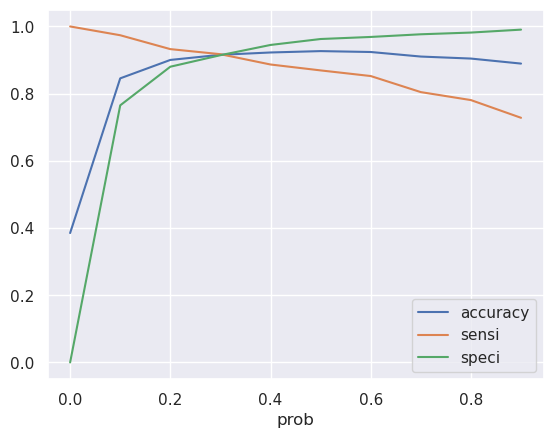

In [60]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

As you can see that around 0.30, you get the optimal values of the three metrics. So let's choose 0.30 as our cutoff now.

In [61]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.30 else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           0       0.028  3009           0      1      0      0      0   
1           0       0.083  1012           0      1      0      0      0   
2           0       0.040  9226           0      1      0      0      0   
3           1       0.608  4750           1      1      1      1      1   
4           1       1.000  7987           1      1      1      1      1   

   0.400  0.500  0.600  0.700  0.800  0.900   final_predicted  
0      0      0      0      0      0      0                 0  
1      0      0      0      0      0      0                 0  
2      0      0      0      0      0      0                 0  
3      1      1      1      0      0      0                 1  
4      1      1      1      1      1      1                 1

In [62]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

0.9156038419146592

array([[3571,  334],
       [ 202, 2244]])

In [63]:
# taking values for TP , TN, FP, FN
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
Sensitivity = TP/(TP+FN)
# Calculate the specificity
Specificity = TN/(TN+FP)
# Calculate Precision
Precision = TP/(TP+FP)
# Calculate Recall
Recall = TP/(TP+FN)

print(f'Sensitivity - {round(Sensitivity,3)}\nspecificity - {round(Specificity,3)}\nPrecision - {round(Precision,3)}\nRecall - {round(Recall,3)}')

Sensitivity - 0.917
specificity - 0.914
Precision - 0.87
Recall - 0.917


#### ROC Curve 

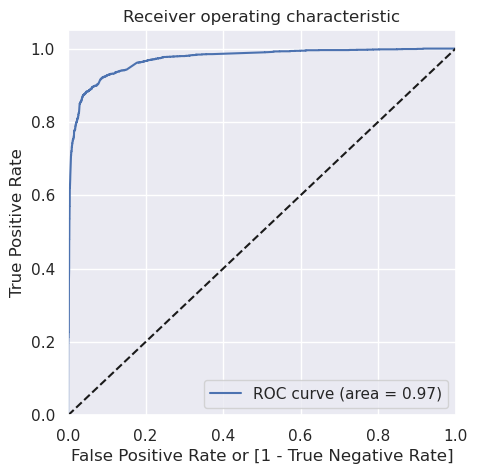

In [64]:
# created a function for the ROC curve creation and see the lables 
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

The area under the curve of the ROC is 0.97 which is quite good. So we seem to have a good model. 

#### Precision - Recall Curve

In [65]:
# we are looking for precision recall score using inbuilt function
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.9357394366197183

0.8691741618969746

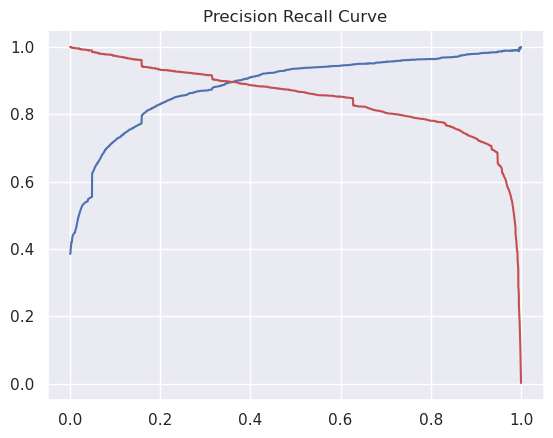

In [66]:
# plotting Presicion and Recall curve and finding the cutoff for this.
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

since we can see here that precision recall having high value than sensitivity and specificity, so we are gonna use this cutoff only to find out accuracy.

In [67]:
# used the cutoff value to see the prediction on train dataset.
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.38 else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           0       0.028  3009           0      1      0      0      0   
1           0       0.083  1012           0      1      0      0      0   
2           0       0.040  9226           0      1      0      0      0   
3           1       0.608  4750           1      1      1      1      1   
4           1       1.000  7987           1      1      1      1      1   

   0.400  0.500  0.600  0.700  0.800  0.900   final_predicted  
0      0      0      0      0      0      0                 0  
1      0      0      0      0      0      0                 0  
2      0      0      0      0      0      0                 0  
3      1      1      1      0      0      0                 1  
4      1      1      1      1      1      1                 1

In [68]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

0.9209573295544009

array([[3669,  236],
       [ 266, 2180]])

In [69]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
Sensitivity = TP/(TP+FN)
# Calculate the specificity
Specificity = TN/(TN+FP)
# Calculate Precision
Precision = TP/(TP+FP)
# Calculate Recall
Recall = TP/(TP+FN)

print(f'Sensitivity - {round(Sensitivity,3)}\nspecificity - {round(Specificity,3)}\nPrecision - {round(Precision,3)}\nRecall - {round(Recall,3)}')

Sensitivity - 0.891
specificity - 0.94
Precision - 0.902
Recall - 0.891


###  ---------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [70]:
# we use these function to do the prediction on test data.
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

# this function is used to generate metrics.
def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
# using this function we can see VIF score for multicollinearity
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [71]:
# scaling for test data
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head(2)
X_test.shape

ttime_on_site  last_activity_SMS Sent  \
3271         -0.601                  -0.668   
1490          1.887                  -0.668   

      lead_origin_Landing Page Submission  lead_source_Welingak Website  \
3271                               -1.075                        -0.127   
1490                                0.930                        -0.127   

      tags_Already a student  tags_Closed by Horizzon  \
3271                  -0.227                   -0.189   
1490                  -0.227                   -0.189   

      tags_Interested in other courses  tags_Lost to EINS  tags_Ringing  \
3271                            -0.249             -0.135        -0.386   
1490                            -0.249             -0.135        -0.386   

      tags_Will revert after reading the email  tags_switched off  \
3271                                    -0.541             -0.160   
1490                                     1.848             -0.160   

      curr_occupation_Unemployed  curr_occupation_Working Professional  
3271                      -1.239                                -0.287  
1490                      -1.239                                 3.489

(2723, 115)

In [72]:
# we got the cutoff as 0.30 for sensitivity specificity, so we are gonna use that as threshold.
cutoff = 0.30
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

print('\nConfusion_Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy: {accuracy}\n')  # Accuracy Score:


Confusion_Matrix:


array([[1563,  171],
       [  99,  890]])


Accuracy: 0.9008446566287184



In [73]:
# we measure confusion matrix metrics
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
Sensitivity = TP/(TP+FN)
# Calculate the specificity
Specificity = TN/(TN+FP)
# Calculate Precision
Precision = TP/(TP+FP)
# Calculate Recall
Recall = TP/(TP+FN)

print(f'Sensitivity - {round(Sensitivity,3)}\nspecificity - {round(Specificity,3)}\nPrecision - {round(Precision,3)}\nRecall - {round(Recall,3)}')

Sensitivity - 0.9
specificity - 0.901
Precision - 0.839
Recall - 0.9


In [74]:
# we got the cutoff as 0.38 for Precision Recall, so we are gonna use that as threshold.

cutoff = 0.38
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

print('\nConfusion_Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy: {accuracy}\n')  # Accuracy Score:


Confusion_Matrix:


array([[1612,  122],
       [ 131,  858]])


Accuracy: 0.9070877708409842



In [75]:
# we measure confusion matrix metrics
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
Sensitivity = TP/(TP+FN)
# Calculate the specificity
Specificity = TN/(TN+FP)
# Calculate Precision
Precision = TP/(TP+FP)
# Calculate Recall
Recall = TP/(TP+FN)

print(f'Sensitivity - {round(Sensitivity,3)}\nspecificity - {round(Specificity,3)}\nPrecision - {round(Precision,3)}\nRecall - {round(Recall,3)}')

Sensitivity - 0.868
specificity - 0.93
Precision - 0.876
Recall - 0.868


The Overall accuracy for Approach 01 is ~90%, the precision recall curve provides a higher cutoff value compared to sensitivity and specificity
The metrics Sensitivity Pecision are in the range the of 86 - 87% while specificity is 93%

## -----------------------------------------------------

## ------------------------------------------------------

## Approach - 02 
- (Additional Feature Elimination)

In [76]:
# the dataset has features such as city and tags 
# tags having higher null values 
# city is having a single label as high frequency, hence we drop those features 
new_ls_df = lead_score_df.drop(['city', 'tags'], axis = 1)

# we also drop all those rows that have curr_occupation as unknown
new_ls_df = new_ls_df[ ~(new_ls_df['curr_occupation'] == 'unknown') ]

In [77]:
# size of our dataset is now reduced, in comparison to original dataset.
print(len(new_ls_df.index)/9240)

0.6916666666666667


### Data Encoding

#### Dummy Encoding

In [78]:
#  we perform dummy encoding
new_ls_df = pd.get_dummies(new_ls_df, columns=new_ls_df.select_dtypes('category').columns.difference(['tags','specialization','info_abt_x_edu', 'lead_profile', 'city', 'curr_occupation']), drop_first=True, dtype=float)
new_ls_df.head(1)
new_ls_df.shape

converted  totalvisits  ttime_on_site  pg_view_pv specialization  \
0          0        0.000          0.000       0.000        unknown   

  info_abt_x_edu curr_occupation lead_profile  avail_free_copy_1  \
0        unknown      Unemployed      unknown              0.000   

   do_not_email_1  last_activity_Converted to Lead  \
0           0.000                            0.000   

   last_activity_Email Bounced  last_activity_Email Link Clicked  \
0                        0.000                             0.000   

   last_activity_Email Marked Spam  last_activity_Email Opened  \
0                            0.000                       0.000   

   last_activity_Email Received  last_activity_Form Submitted on Website  \
0                         0.000                                    0.000   

   last_activity_Had a Phone Conversation  \
0                                   0.000   

   last_activity_Olark Chat Conversation  \
0                                  0.000   

   last_activity_Page Visited on Website  \
0                                  1.000   

   last_activity_Resubscribed to emails  last_activity_SMS Sent  \
0                                 0.000                   0.000   

   last_activity_Unreachable  last_activity_Unsubscribed  \
0                      0.000                       0.000   

   last_activity_View in browser link Clicked  \
0                                       0.000   

   last_activity_Visited Booth in Tradeshow  \
0                                     0.000   

   lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
0                                0.000                      0.000   

   lead_origin_Lead Import  lead_origin_Quick Add Form  \
0                    0.000                       0.000   

   lead_source_Direct Traffic  lead_source_Facebook  lead_source_Google  \
0                       0.000                 0.000               0.000   

   lead_source_Live Chat  lead_source_NC_EDM  lead_source_Olark Chat  \
0                  0.000               0.000                   1.000   

   lead_source_Organic Search  lead_source_Pay per Click Ads  \
0                       0.000                          0.000   

   lead_source_Press_Release  lead_source_Reference  \
0                      0.000                  0.000   

   lead_source_Referral Sites  lead_source_Social Media  lead_source_WeLearn  \
0                       0.000                     0.000                0.000   

   lead_source_Welingak Website  lead_source_bing  lead_source_blog  \
0                         0.000             0.000             0.000   

   lead_source_google  lead_source_testone  lead_source_welearnblog_Home  \
0               0.000                0.000                         0.000   

   lead_source_youtubechannel  
0                       0.000

(6391, 50)

In [79]:
new_ls_df = pd.get_dummies(new_ls_df, columns=[   'specialization', 'info_abt_x_edu', 'lead_profile' , 'curr_occupation'], dtype=float)
new_ls_df = new_ls_df.drop(new_ls_df.filter(like='unknown',axis=1).columns, axis=1)
new_ls_df.shape


(6391, 84)

In [80]:
new_ls_df.head(2)

converted  totalvisits  ttime_on_site  pg_view_pv  avail_free_copy_1  \
0          0        0.000          0.000       0.000              0.000   
1          0        5.000        674.000       2.500              0.000   

   do_not_email_1  last_activity_Converted to Lead  \
0           0.000                            0.000   
1           0.000                            0.000   

   last_activity_Email Bounced  last_activity_Email Link Clicked  \
0                        0.000                             0.000   
1                        0.000                             0.000   

   last_activity_Email Marked Spam  last_activity_Email Opened  \
0                            0.000                       0.000   
1                            0.000                       1.000   

   last_activity_Email Received  last_activity_Form Submitted on Website  \
0                         0.000                                    0.000   
1                         0.000                                    0.000   

   last_activity_Had a Phone Conversation  \
0                                   0.000   
1                                   0.000   

   last_activity_Olark Chat Conversation  \
0                                  0.000   
1                                  0.000   

   last_activity_Page Visited on Website  \
0                                  1.000   
1                                  0.000   

   last_activity_Resubscribed to emails  last_activity_SMS Sent  \
0                                 0.000                   0.000   
1                                 0.000                   0.000   

   last_activity_Unreachable  last_activity_Unsubscribed  \
0                      0.000                       0.000   
1                      0.000                       0.000   

   last_activity_View in browser link Clicked  \
0                                       0.000   
1                                       0.000   

   last_activity_Visited Booth in Tradeshow  \
0                                     0.000   
1                                     0.000   

   lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
0                                0.000                      0.000   
1                                0.000                      0.000   

   lead_origin_Lead Import  lead_origin_Quick Add Form  \
0                    0.000                       0.000   
1                    0.000                       0.000   

   lead_source_Direct Traffic  lead_source_Facebook  lead_source_Google  \
0                       0.000                 0.000               0.000   
1                       0.000                 0.000               0.000   

   lead_source_Live Chat  lead_source_NC_EDM  lead_source_Olark Chat  \
0                  0.000               0.000                   1.000   
1                  0.000               0.000                   0.000   

   lead_source_Organic Search  lead_source_Pay per Click Ads  \
0                       0.000                          0.000   
1                       1.000                          0.000   

   lead_source_Press_Release  lead_source_Reference  \
0                      0.000                  0.000   
1                      0.000                  0.000   

   lead_source_Referral Sites  lead_source_Social Media  lead_source_WeLearn  \
0                       0.000                     0.000                0.000   
1                       0.000                     0.000                0.000   

   lead_source_Welingak Website  lead_source_bing  lead_source_blog  \
0                         0.000             0.000             0.000   
1                         0.000             0.000             0.000   

   lead_source_google  lead_source_testone  lead_source_welearnblog_Home  \
0               0.000                0.000                         0.000   
1               0.000                0.000                         0.000   

   lead_source_youtubechannel  \
0   

###  ----------------------------------------------------------------------

### Train and Test Split

In [81]:
# spliting the data into independent and target variable
X = new_ls_df.drop(['converted'], axis=1)
y = new_ls_df['converted']

In [82]:
# Now we split the dataset into train and test set
# np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=100)

###  ----------------------------------------------------------------------

### Feature Scaling

In [83]:
# Post split we perform standard scaling they fit and transform the train data set
# to_scale = ['totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = list(X.columns)

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale], y_train)
X_train.head(5)

totalvisits  ttime_on_site  pg_view_pv  avail_free_copy_1  \
533        -0.131          0.524       0.363              1.395   
846        -1.163         -0.942      -1.331             -0.717   
7546        1.932          0.554       2.056              1.395   
8631        0.556          0.655       1.492             -0.717   
7824       -0.819         -0.613      -0.766             -0.717   

      do_not_email_1  last_activity_Converted to Lead  \
533           -0.269                           -0.220   
846           -0.269                           -0.220   
7546          -0.269                           -0.220   
8631          -0.269                           -0.220   
7824          -0.269                            4.551   

      last_activity_Email Bounced  last_activity_Email Link Clicked  \
533                        -0.167                            -0.182   
846                        -0.167                            -0.182   
7546                       -0.167                            -0.182   
8631                       -0.167                            -0.182   
7824                       -0.167                            -0.182   

      last_activity_Email Marked Spam  last_activity_Email Opened  \
533                             0.000                       1.262   
846                             0.000                       1.262   
7546                            0.000                      -0.792   
8631                            0.000                      -0.792   
7824                            0.000                      -0.792   

      last_activity_Email Received  last_activity_Form Submitted on Website  \
533                         -0.015                                   -0.120   
846                         -0.015                                   -0.120   
7546                        -0.015                                   -0.120   
8631                        -0.015                                   -0.120   
7824                        -0.015                                   -0.120   

      last_activity_Had a Phone Conversation  \
533                                   -0.062   
846                                   -0.062   
7546                                  -0.062   
8631                                  -0.062   
7824                                  -0.062   

      last_activity_Olark Chat Conversation  \
533                                  -0.269   
846                                  -0.269   
7546                                 -0.269   
8631                                 -0.269   
7824                                 -0.269   

      last_activity_Page Visited on Website  \
533                                  -0.271   
846                                  -0.271   
7546                                 -0.271   
8631                                 -0.271   
7824                                 -0.271   

      last_activity_Resubscribed to emails  last_activity_SMS Sent  \
533                                  0.000                  -0.714   
846                                  0.000                  -0.714   
7546                                 0.000                   1.402   
8631                                 0.000                   1.402   
7824                                 0.000                  -0.714   

      last_activity_Unreachable  last_activity_Unsubscribed  \
533                      -0.105                      -0.072   
846                      -0.105                      -0.072   
7546                     -0.105                      -0.072   
8631                     -0.105                      -0.072   
7824                     -0.105                      -0.072   

      last_activity_View in browser link Clicked  \
533                                       -0.030   
846                                       -0.030   
7546                                      -0.030   
8631                                      -0.030   
7824                        

###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [84]:
# We create custom functions for model building therefore we reuse certain functions again and again
# Train and predict_function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

# The matrix function returns confusion matrix and accuracy score
def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
   
# The vif function returns the vif score for the features
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model

In [85]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm1.fit()
# res.summary()

##### RFE - Recursive Feature Elimination

In [86]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features
logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
rfe_feature_Ranking = list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [87]:
rfe_sorted = sorted(rfe_feature_Ranking, key=lambda x : x[2])
rfe_sorted[:15]

[('ttime_on_site', True, 1),
 ('do_not_email_1', True, 1),
 ('last_activity_Converted to Lead', True, 1),
 ('last_activity_Email Bounced', True, 1),
 ('last_activity_Email Opened', True, 1),
 ('last_activity_Olark Chat Conversation', True, 1),
 ('last_activity_Page Visited on Website', True, 1),
 ('lead_origin_Lead Add Form', True, 1),
 ('lead_source_Olark Chat', True, 1),
 ('lead_source_Welingak Website', True, 1),
 ('lead_profile_Dual Specialization Student', True, 1),
 ('lead_profile_Lateral Student', True, 1),
 ('lead_profile_Potential Lead', True, 1),
 ('lead_profile_Student of SomeSchool', True, 1),
 ('curr_occupation_Working Professional', True, 1)]

In [88]:
col = X_train.columns[rfe.support_]
# X_train.columns[~rfe.support_]

##### Model 1

In [89]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 4473
Model:                            GLM   Df Residuals:                     4457
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1931.5
Date:                Tue, 22 Oct 2024   Deviance:                       3863.0
Time:                        10:00:28   Pearson chi2:                 4.66e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.4056
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                        0.0787     85.559      0.001      0.999    -167.613     167.770
ttime_on_site                                1.1035      0.048     23.063      0.000       1.010       1.197
do_not_email_1                              -0.3114      0.056     -5.548      0.000      -0.421      -0.201
last_activity_Converted to Lead             -0.3903      0.049     -7.920      0.000      -0.487      -0.294
last_activity_Email Bounced                 -0.2913      0.072     -4.069      0.000      -0.432      -0.151
last_activity_Email Opened                  -0.3885      0.043     -8.977      0.000      -0.473      -0.304
last_activity_Olark Chat Conversation       -0.4788      0.048     -9.929      0.000      -0.573      -0.384
last_activity_Page Visited on Website       -0.2793      0.043     -6.456      0.000      -0.364      -0.195
lead_origin_Lead Add Form                    0.9053      0.071     12.833      0.000       0.767       1.044
lead_source_Olark Chat                       0.5089      0.043     11.836      0.000       0.425       0.593
lead_source_Welingak Website                 0.3529      0.109      3.250      0.001       0.140       0.566
lead_profile_Dual Specialization Student     1.3589   1024.498      0.001      0.999   -2006.620    2009.337
lead_profile_Lateral Student                 1.3798   1027.316      0.001      0.999   -2012.122    2014.882
lead_profile_Potential Lead                  0.6317      0.043     14.716      0.000       0.548       0.716
lead_profile_Student of SomeSchool          -0.5945      0.116     -5.115      0.000      -0.822      -0.367
curr_occupation_Working Professional         0.6817      0.057     11.905      0.000       0.569       0.794
============================================================================================================
"""


VIF Score:


Features   VIF
7                  lead_origin_Lead Add Form 1.620
1                             do_not_email_1 1.570
3                last_activity_Email Bounced 1.510
9               lead_source_Welingak Website 1.330
0                              ttime_on_site 1.300
8                     lead_source_Olark Chat 1.290
4                 last_activity_Email Opened 1.260
5      last_activity_Olark Chat Conversation 1.220
12               lead_profile_Potential Lead 1.170
6      last_activity_Page Visited on Website 1.110
14      curr_occupation_Working Professional 1.110
2            last_activity_Converted to Lead 1.100
13        lead_profile_Student of SomeSchool 1.050
10  lead_profile_Dual Specialization Student 1.010
11              lead_profile_Lateral Student 1.010

##### Model 2

In [90]:
# the 'lead_profile_Lateral Student' has higher p-value therefore we drop it.
# after dropping we will again make a model and see the stats

col = col.drop('lead_profile_Lateral Student', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Index(['ttime_on_site', 'do_not_email_1', 'last_activity_Converted to Lead',
       'last_activity_Email Bounced', 'last_activity_Email Opened',
       'last_activity_Olark Chat Conversation',
       'last_activity_Page Visited on Website', 'lead_origin_Lead Add Form',
       'lead_source_Olark Chat', 'lead_source_Welingak Website',
       'lead_profile_Dual Specialization Student',
       'lead_profile_Potential Lead', 'lead_profile_Student of SomeSchool',
       'curr_occupation_Working Professional'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 4473
Model:                            GLM   Df Residuals:                     4458
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1938.9
Date:                Tue, 22 Oct 2024   Deviance:                       3877.8
Time:                        10:00:28   Pearson chi2:                 4.68e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.4036
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                        0.0044     59.431   7.36e-05      1.000    -116.478     116.487
ttime_on_site                                1.1074      0.048     23.175      0.000       1.014       1.201
do_not_email_1                              -0.3051      0.056     -5.481      0.000      -0.414      -0.196
last_activity_Converted to Lead             -0.3907      0.049     -7.926      0.000      -0.487      -0.294
last_activity_Email Bounced                 -0.2950      0.072     -4.125      0.000      -0.435      -0.155
last_activity_Email Opened                  -0.3814      0.043     -8.835      0.000      -0.466      -0.297
last_activity_Olark Chat Conversation       -0.4783      0.048     -9.920      0.000      -0.573      -0.384
last_activity_Page Visited on Website       -0.2804      0.043     -6.479      0.000      -0.365      -0.196
lead_origin_Lead Add Form                    0.9133      0.070     12.981      0.000       0.775       1.051
lead_source_Olark Chat                       0.5076      0.043     11.830      0.000       0.424       0.592
lead_source_Welingak Website                 0.3500      0.108      3.226      0.001       0.137       0.563
lead_profile_Dual Specialization Student     1.3576   1024.557      0.001      0.999   -2006.737    2009.452
lead_profile_Potential Lead                  0.6265      0.043     14.605      0.000       0.542       0.711
lead_profile_Student of SomeSchool          -0.5976      0.116     -5.133      0.000      -0.826      -0.369
curr_occupation_Working Professional         0.6840      0.057     11.970      0.000       0.572       0.796
============================================================================================================
"""


VIF Score:


Features   VIF
7                  lead_origin_Lead Add Form 1.610
1                             do_not_email_1 1.570
3                last_activity_Email Bounced 1.510
9               lead_source_Welingak Website 1.330
0                              ttime_on_site 1.300
8                     lead_source_Olark Chat 1.290
4                 last_activity_Email Opened 1.260
5      last_activity_Olark Chat Conversation 1.220
11               lead_profile_Potential Lead 1.160
6      last_activity_Page Visited on Website 1.110
13      curr_occupation_Working Professional 1.110
2            last_activity_Converted to Lead 1.100
12        lead_profile_Student of SomeSchool 1.050
10  lead_profile_Dual Specialization Student 1.010

Model 3

In [91]:
# the 'lead_profile_Dual Specialization Student' has higher p-value therefore we drop it.
# after dropping we will again make a model and see the stats

col = col.drop('lead_profile_Dual Specialization Student', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['ttime_on_site', 'do_not_email_1', 'last_activity_Converted to Lead',
       'last_activity_Email Bounced', 'last_activity_Email Opened',
       'last_activity_Olark Chat Conversation',
       'last_activity_Page Visited on Website', 'lead_origin_Lead Add Form',
       'lead_source_Olark Chat', 'lead_source_Welingak Website',
       'lead_profile_Potential Lead', 'lead_profile_Student of SomeSchool',
       'curr_occupation_Working Professional'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 4473
Model:                            GLM   Df Residuals:                     4459
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1947.8
Date:                Tue, 22 Oct 2024   Deviance:                       3895.5
Time:                        10:00:28   Pearson chi2:                 4.71e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4012
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.0661      0.049     -1.346      0.178      -0.162       0.030
ttime_on_site                             1.1102      0.048     23.248      0.000       1.017       1.204
do_not_email_1                           -0.2957      0.055     -5.356      0.000      -0.404      -0.187
last_activity_Converted to Lead          -0.3917      0.049     -7.942      0.000      -0.488      -0.295
last_activity_Email Bounced              -0.3009      0.071     -4.211      0.000      -0.441      -0.161
last_activity_Email Opened               -0.3761      0.043     -8.737      0.000      -0.460      -0.292
last_activity_Olark Chat Conversation    -0.4792      0.048     -9.941      0.000      -0.574      -0.385
last_activity_Page Visited on Website    -0.2811      0.043     -6.509      0.000      -0.366      -0.196
lead_origin_Lead Add Form                 0.9113      0.070     12.963      0.000       0.773       1.049
lead_source_Olark Chat                    0.5081      0.043     11.865      0.000       0.424       0.592
lead_source_Welingak Website              0.3494      0.108      3.220      0.001       0.137       0.562
lead_profile_Potential Lead               0.6214      0.043     14.496      0.000       0.537       0.705
lead_profile_Student of SomeSchool       -0.6004      0.116     -5.154      0.000      -0.829      -0.372
curr_occupation_Working Professional      0.6897      0.057     12.110      0.000       0.578       0.801
=========================================================================================================
"""


VIF Score:


Features   VIF
7               lead_origin_Lead Add Form 1.610
1                          do_not_email_1 1.570
3             last_activity_Email Bounced 1.510
9            lead_source_Welingak Website 1.330
0                           ttime_on_site 1.300
8                  lead_source_Olark Chat 1.290
4              last_activity_Email Opened 1.260
5   last_activity_Olark Chat Conversation 1.220
10            lead_profile_Potential Lead 1.160
6   last_activity_Page Visited on Website 1.110
12   curr_occupation_Working Professional 1.110
2         last_activity_Converted to Lead 1.100
11     lead_profile_Student of SomeSchool 1.050


Confusion Matrix:


array([[1927,  422],
       [ 478, 1646]])


Accuracy Score: 0.7987927565392354



In [92]:
# taking values for TP , TN, FP, FN
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
Sensitivity = TP/(TP+FN)
# Calculate the specificity
Specificity = TN/(TN+FP)
# Calculate Precision
Precision = TP/(TP+FP)
# Calculate Recall
Recall = TP/(TP+FN)

print(f'Sensitivity - {round(Sensitivity,3)}\nspecificity - {round(Specificity,3)}\nPrecision - {round(Precision,3)}\nRecall - {round(Recall,3)}')

Sensitivity - 0.775
specificity - 0.82
Precision - 0.796
Recall - 0.775


#### Finding Optimal Cutoff Point

In [93]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           1       0.844   533           1      1      1      1      1   
1           1       0.919   846           1      1      1      1      1   
2           1       0.844  7546           1      1      1      1      1   
3           0       0.589  8631           1      1      1      1      1   
4           0       0.051  7824           0      1      0      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900  
0      1      1      1      1      1      0  
1      1      1      1      1      1      1  
2      1      1      1      1      1      0  
3      1      1      0      0      0      0  
4      0      0      0      0      0      0

In [94]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.475  1.000  0.000
0.100 0.100     0.588  0.990  0.225
0.200 0.200     0.718  0.947  0.511
0.300 0.300     0.770  0.897  0.656
0.400 0.400     0.798  0.825  0.774
0.500 0.500     0.799  0.775  0.820
0.600 0.600     0.782  0.680  0.875
0.700 0.700     0.765  0.585  0.927
0.800 0.800     0.730  0.480  0.957
0.900 0.900     0.674  0.330  0.986


<Axes: xlabel='prob'>

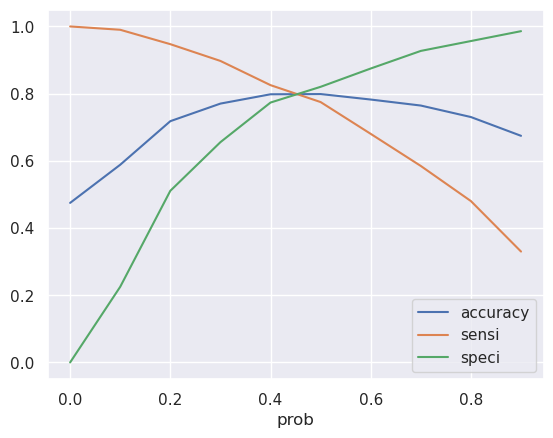

In [95]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [96]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.43 else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           1       0.844   533           1      1      1      1      1   
1           1       0.919   846           1      1      1      1      1   
2           1       0.844  7546           1      1      1      1      1   
3           0       0.589  8631           1      1      1      1      1   
4           0       0.051  7824           0      1      0      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900   final_predicted  
0      1      1      1      1      1      0                 1  
1      1      1      1      1      1      1                 1  
2      1      1      1      1      1      0                 1  
3      1      1      0      0      0      0                 1  
4      0      0      0      0      0      0                 0

In [97]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

0.7985691929353901

array([[1855,  494],
       [ 407, 1717]])

In [98]:
# taking values for TP , TN, FP, FN
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
Sensitivity = TP/(TP+FN)
# Calculate the specificity
Specificity = TN/(TN+FP)
# Calculate Precision
Precision = TP/(TP+FP)
# Calculate Recall
Recall = TP/(TP+FN)

print(f'Sensitivity - {round(Sensitivity,3)}\nspecificity - {round(Specificity,3)}\nPrecision - {round(Precision,3)}\nRecall - {round(Recall,3)}')

Sensitivity - 0.808
specificity - 0.79
Precision - 0.777
Recall - 0.808


####  ----------------------------------------------------------------------

#### ROC Curve and Precision - Recall Curve

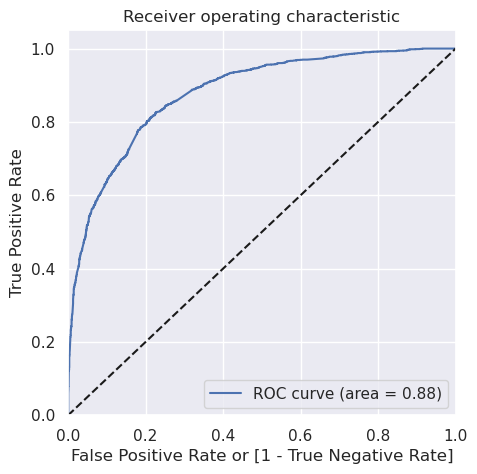

In [99]:
# created a function for the ROC curve creation and see the lables 
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [100]:
# we are looking for precision recall score using inbuilt function
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.7959381044487428

0.7749529190207156

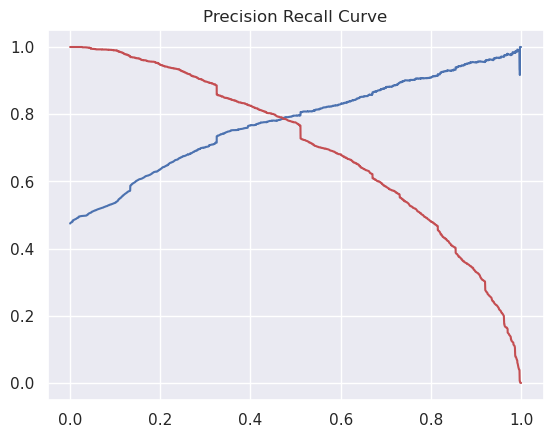

In [101]:
# plotting Precision and Recall curve and finding the cutoff for this.
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

we can see here that precision recall curve is intersecting at 0.43, so we are gonna use this cutoff to find out accuracy.

In [102]:
# used the cutoff value to see the prediction on train dataset.
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.45 else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           1       0.844   533           1      1      1      1      1   
1           1       0.919   846           1      1      1      1      1   
2           1       0.844  7546           1      1      1      1      1   
3           0       0.589  8631           1      1      1      1      1   
4           0       0.051  7824           0      1      0      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900   final_predicted  
0      1      1      1      1      1      0                 1  
1      1      1      1      1      1      1                 1  
2      1      1      1      1      1      0                 1  
3      1      1      0      0      0      0                 1  
4      0      0      0      0      0      0                 0

In [103]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

0.7990163201430807

array([[1873,  476],
       [ 423, 1701]])

In [104]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
Sensitivity = TP/(TP+FN)
# Calculate the specificity
Specificity = TN/(TN+FP)
# Calculate Precision
Precision = TP/(TP+FP)
# Calculate Recall
Recall = TP/(TP+FN)

print(f'Sensitivity - {round(Sensitivity,3)}\nspecificity - {round(Specificity,3)}\nPrecision - {round(Precision,3)}\nRecall - {round(Recall,3)}')

Sensitivity - 0.801
specificity - 0.797
Precision - 0.781
Recall - 0.801


###  ---------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [105]:
# we use these function to do the prediction on test data.
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

# this function is used to generate metrics.
def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
# using this function we can see VIF score for multicollinearity
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [106]:
# scaling the test data
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head(2)
X_test.shape

ttime_on_site  do_not_email_1  last_activity_Converted to Lead  \
2938          1.011          -0.269                           -0.220   
4301         -0.362           3.716                           -0.220   

      last_activity_Email Bounced  last_activity_Email Opened  \
2938                       -0.167                      -0.792   
4301                       -0.167                      -0.792   

      last_activity_Olark Chat Conversation  \
2938                                 -0.269   
4301                                 -0.269   

      last_activity_Page Visited on Website  lead_origin_Lead Add Form  \
2938                                 -0.271                     -0.315   
4301                                 -0.271                     -0.315   

      lead_source_Olark Chat  lead_source_Welingak Website  \
2938                  -0.406                        -0.145   
4301                   2.461                        -0.145   

      lead_profile_Potential Lead  lead_profile_Student of SomeSchool  \
2938                       -0.574                              -0.194   
4301                        1.742                              -0.194   

      curr_occupation_Working Professional  
2938                                 2.915  
4301                                -0.343

(1918, 83)

In [107]:
# our sensitivity and specificity is 0.43 so we are gonna use in this.
cutoff = 0.43
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

print('\nConfusion_Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy: {accuracy}\n')  # Accuracy Score:


Confusion_Matrix:


array([[782, 195],
       [187, 754]])


Accuracy: 0.8008342022940563



In [108]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
Sensitivity = TP/(TP+FN)
# Calculate the specificity
Specificity = TN/(TN+FP)
# Calculate Precision
Precision = TP/(TP+FP)
# Calculate Recall
Recall = TP/(TP+FN)

print(f'Sensitivity - {round(Sensitivity,3)}\nspecificity - {round(Specificity,3)}\nPrecision - {round(Precision,3)}\nRecall - {round(Recall,3)}')

Sensitivity - 0.801
specificity - 0.8
Precision - 0.795
Recall - 0.801


In [109]:
# our precision and recall cutoff is 0.45 so we are gonna use in this. 

cutoff = 0.45
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

print('\nConfusion_Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy: {accuracy}\n')  # Accuracy Score:


Confusion_Matrix:


array([[789, 188],
       [195, 746]])


Accuracy: 0.8003128258602711



In [110]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
Sensitivity = TP/(TP+FN)
# Calculate the specificity
Specificity = TN/(TN+FP)
# Calculate Precision
Precision = TP/(TP+FP)
# Calculate Recall
Recall = TP/(TP+FN)

print(f'Sensitivity - {round(Sensitivity,3)}\nspecificity - {round(Specificity,3)}\nPrecision - {round(Precision,3)}\nRecall - {round(Recall,3)}')

Sensitivity - 0.793
specificity - 0.808
Precision - 0.799
Recall - 0.793


The Overall accuracy for Approach 02 is ~80%, the precision recall curve provides a higher cutoff value compared to sensitivity and specificity
The metrics Sensitivity specificity Pecision are in the range the of 79% to 80%.